In [1]:
#Amplitude calculation 
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.image as mpimg
import os, copy, time, pickle
from urllib.request import urlretrieve
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp
import os
import json
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py as h5
import glob

from Utils import get_avg_AMP, get_scale, find_amp_index #,get_AMP

In [2]:
def load_data(file):   
    f = h5.File(file, 'r')
    data = np.array(f['Dataset1'][:,:,0:2])
    return data

In [3]:
#edge weight from one fixed node to all nodes in same dataset  
def get_dist_2(data): 
    dist = []
    for i in range(len(data)): #first loop goes into each trajecotry "sheet"
        dist2=[]
        for k in range(len(data[i])):
            #fixed_node = data[i, k, :]
            for j in range(len(data[i])):#second loop goes into seach trajectory "row" which holds an (x,y)
                #print(j)
                if j < 999:
                    temp = np.sqrt((data[i, k, 0]- data[i, j, 0]) ** 2 + (data[i, k, 1]- data[i, j, 1]) ** 2) #distance from a node to the next 
                    dist2.append(temp)
                if j == 999: 
                    temp = np.sqrt((data[i, 0, 0]- data[i, j, 0]) ** 2 + (data[i, 0, 1]- data[i, j, 1]) ** 2) #distance from a node to the next 
                    dist2.append(temp)
            #print(np.shape(dist2)) #want 1 x 1000
            dist3 = np.array(dist2) 
            dist3.sort() 
            dist.append(dist3[0]) #only store smallest edge weight
            print(np.shape(dist))
    dist = np.array(dist) 
    return dist  

In [4]:
#edge weight from one fixed node to all nodes in same dataset  
def get_dist_3(data, i): 
    dist = [] #first loop goes into each trajecotry "sheet"
    idx = []
    for k in range(len(data[i])):
        dist2=[]
        #fixed_node = data[i, k, :]
        for j in range(len(data[i])):#second loop goes into seach trajectory "row" which holds an (x,y)
            #print(j)
            if j < 999 and j != k:
                temp = np.sqrt((data[i, k, 0]- data[i, j, 0]) ** 2 + (data[i, k, 1]- data[i, j, 1]) ** 2) #distance from a node to the next 
                dist2.append(temp)
            if j == 999 and j != k: 
                temp = np.sqrt((data[i, 0, 0]- data[i, j, 0]) ** 2 + (data[i, 0, 1]- data[i, j, 1]) ** 2) #distance from a node to the next 
                dist2.append(temp)
        #print(np.shape(dist2)) #want 1 x 1000
        dist3 = np.array(dist2) 
        dist3.sort() 
        dist.append(dist3[0]) #only store smallest edge weight
        idx_arr = np.argsort(dist2)
        idx.append(idx_arr[0])
        #print(np.shape(dist))
    dist = np.array(dist) 
    return dist, idx

In [5]:
FILE = 'Trajectories400.hdf5' 
data = load_data(FILE)
print(np.shape(data))

(400, 1000, 2)


In [6]:
#plotting dist from one fixed node to all nodes in same dataset
# Dist_2 = get_dist_2(data)
# print(np.shape(Dist_2))
# print(Dist_2)

#Want the index of the original array 

traj_list = list(range(400))
traj_list2 = traj_list[0::20]
#print(traj_list2)

main_dict={}

avg_ew = []

for i in traj_list2:
    Dist_3 = []
    idx = []
    if i != 0: 
        Dist_3, idx = get_dist_3(data, i)
        #print(np.shape(Dist_3))
        #print(Dist_3)
        #print(idx)
        
        avg = np.mean(Dist_3)
        avg_ew.append(avg)

        tpad = 7
        plt.figure(figsize=[10,10], dpi=200)

        plt.title('Fixed Nodes for Traj %s ' %i, pad=tpad) 
        plt.xlabel('Edege Weight') 
        plt.ylabel('Index of Coordinate') 
        plt.plot(Dist_3, idx, 'ks', markersize = 2)
        #plt.savefig(os.path.join("/global/u2/m/mmeitz/FRNN/NearestNode{0}.png".format(str(i).zfill(3))))
        #plt.show()
        plt.close()
        
    ith_traj = {"Index": idx, "Edge Weight": Dist_3}
        
    traj_num = str(i) 
    traj_dict = {traj_num: ith_traj}
        
    main_dict.update(traj_dict)

In [7]:
print(avg_ew)
#print('Sort', np.sort(avg_ew))
print(np.argsort(avg_ew))

[0.0017007115353941612, 0.003030590226430654, 0.0027112600668984257, 0.0073183148173419635, 0.006485007382944817, 0.005450428610625608, 0.012882005895925535, 0.014141181509346918, 0.008518183915161593, 0.009480508496705295, 0.018146887624043956, 0.0006372295126419, 0.019583271446346195, 0.024782336638307343, 0.03356186190794035, 0.010851410398693742, 0.013535440398227277, 0.052343595305752555, 0.1190223628889283]
[11  0  2  1  5  4  3  8  9 15  6 16  7 10 12 13 14 17 18]


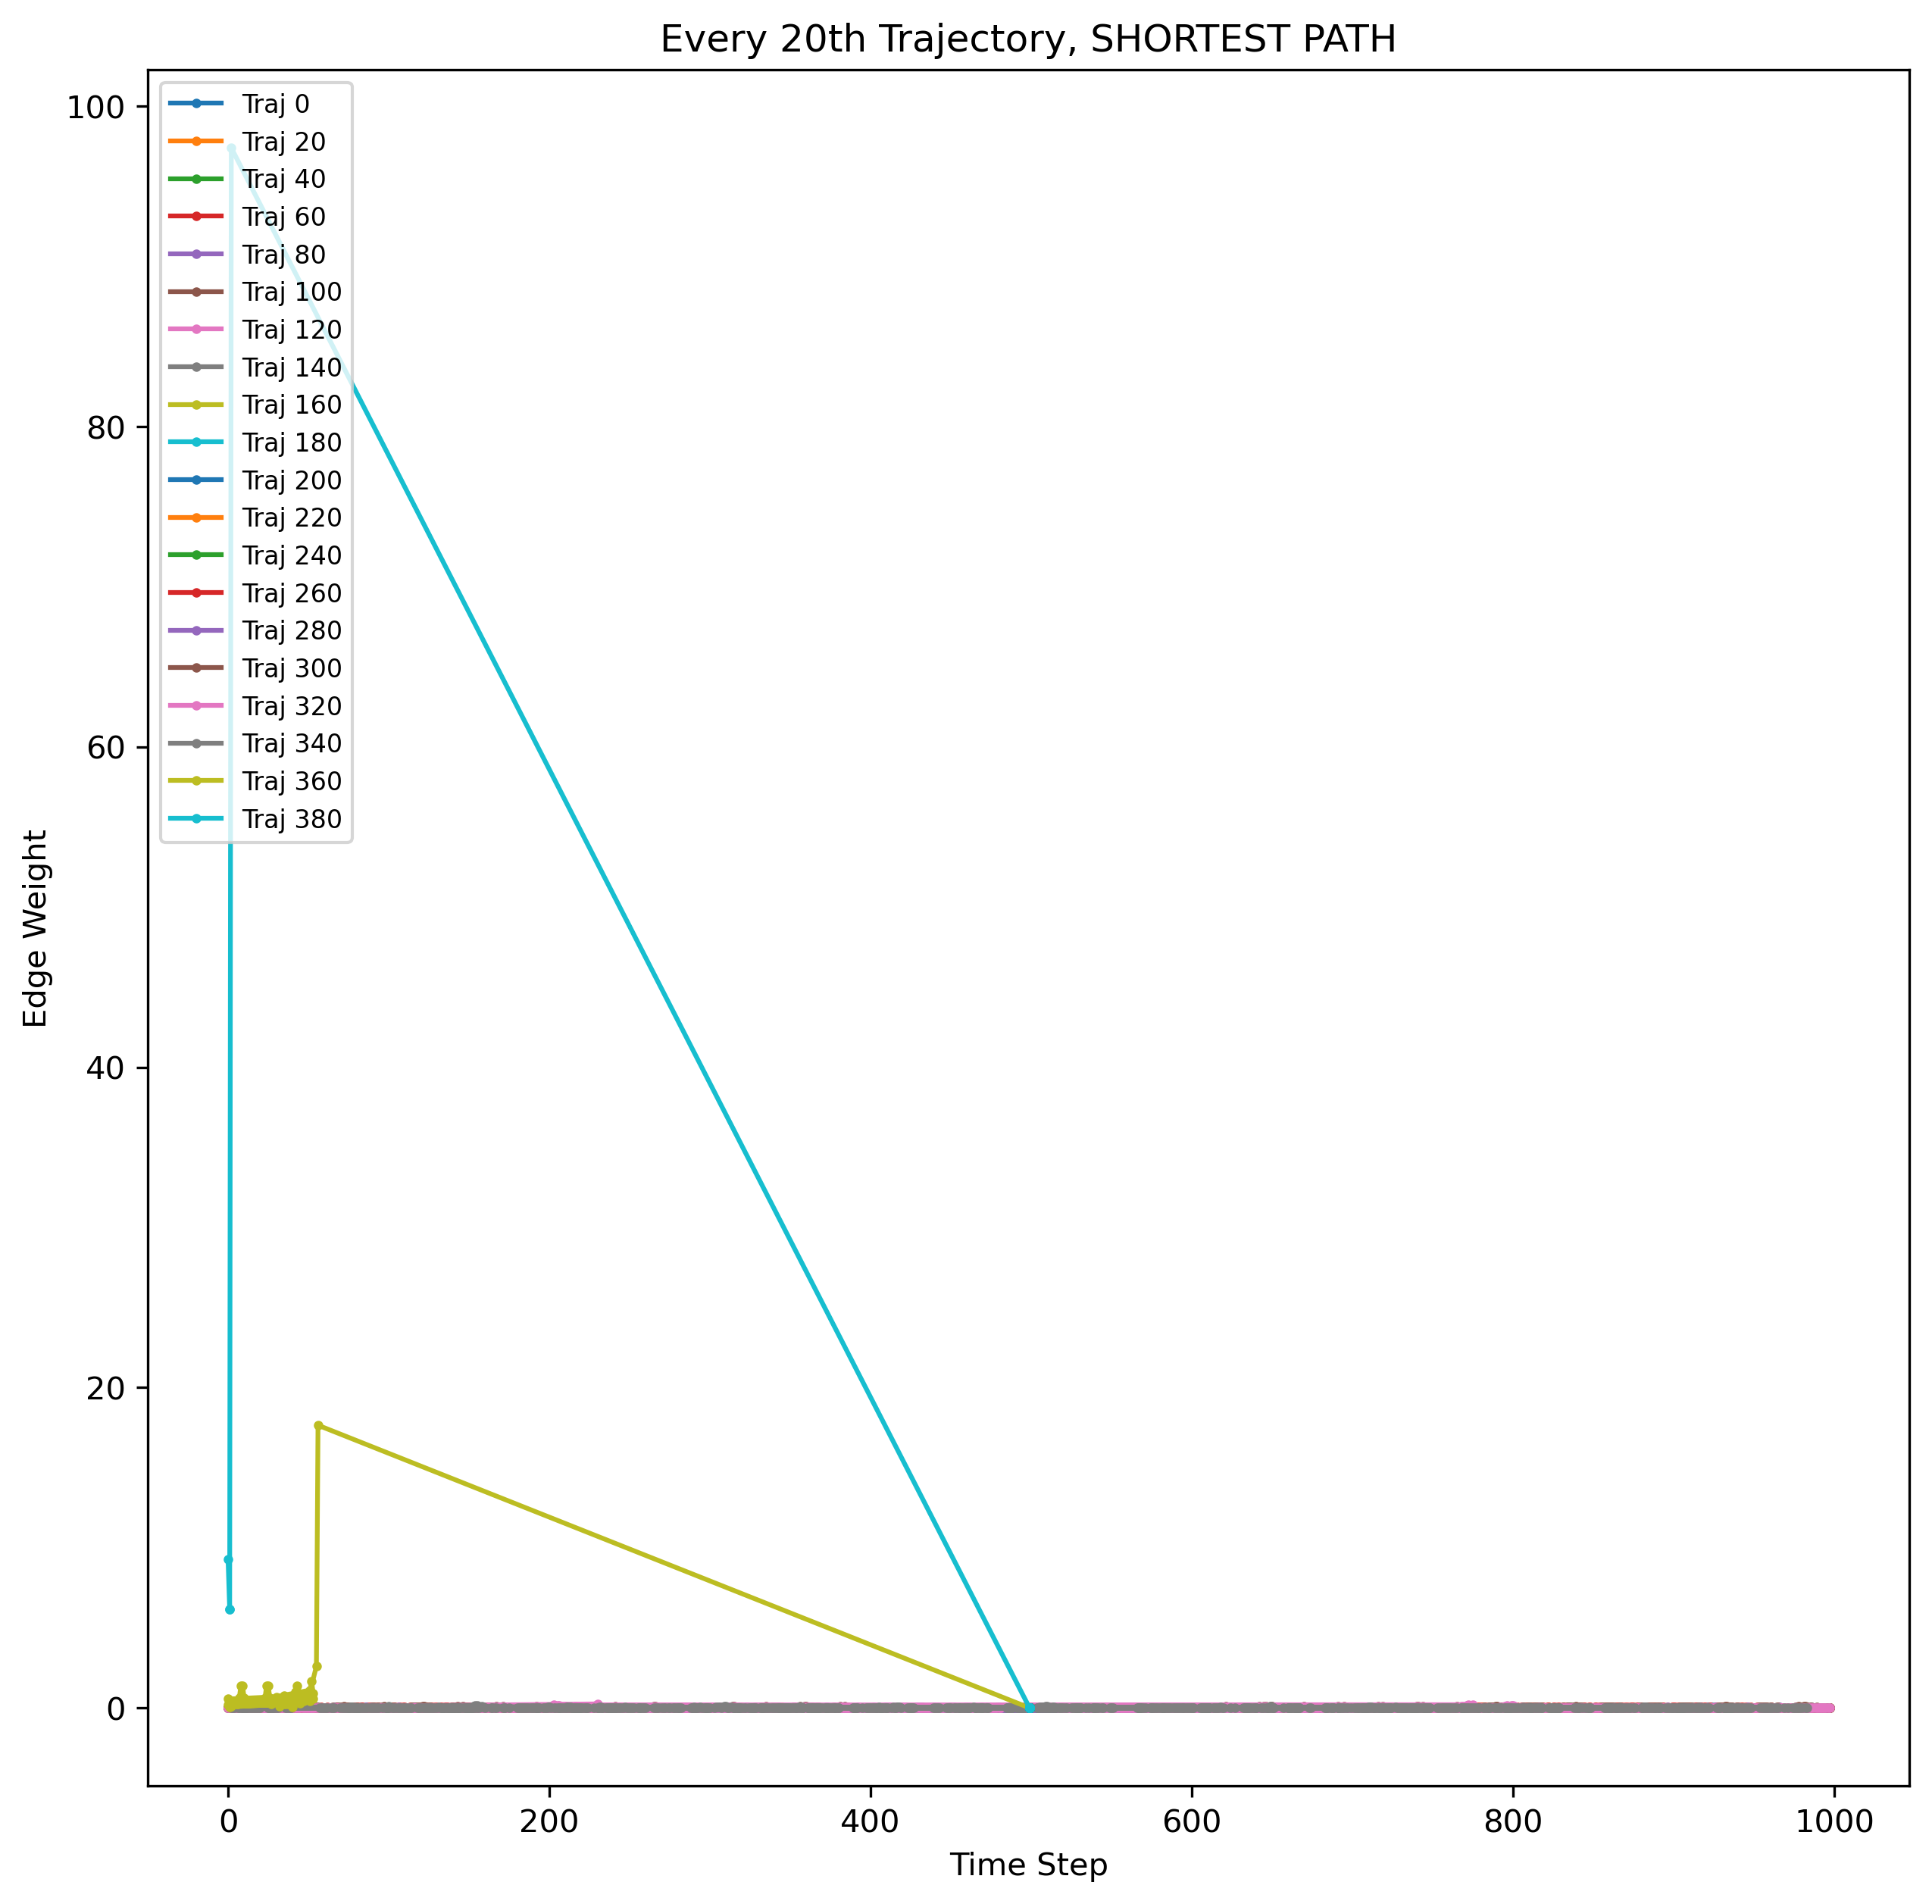

In [8]:
tpad = 7

plt.figure(figsize=[10,10], dpi=300)
plt.title('Every 20th Trajectory, SHORTEST PATH')
plt.xlabel('Time Step') ; plt.ylabel('Edge Weight')

#i = 20
#print(main_dict)

for i in range(len(data)):
    if (i % 20) == 0: #display every 10th traj 
        plt.plot(main_dict[str(i)]["Index"], main_dict[str(i)]["Edge Weight"], '-o', label='Traj %s' %i, markersize = 2)

plt.legend(fontsize=8, loc='upper left')
#plt.xlim(-15,8)
#plt.ylim(-7,7)
plt.show

plt.savefig(os.path.join("/global/u2/m/mmeitz/FRNN/ALL_ShortestPath.png"))

In [9]:
for i in range(len(data)):
    if (i % 20) == 0: #display every 10th traj 
        if i != 0: 
            tpad = 7
            plt.figure(figsize=[10,10], dpi=300)
            plt.title('%s Trajectory, SHORTEST PATH' %i)
            plt.xlabel('Time Step') 
            plt.ylabel('Edge Weight')
            plt.plot(main_dict[str(i)]["Index"], main_dict[str(i)]["Edge Weight"], '-o', label='Traj %s' %i, markersize = 2)
            #plt.savefig(os.path.join("/global/u2/m/mmeitz/FRNN/ShortestPath{0}.png".format(str(i).zfill(3))))
            #plt.show()
            plt.close()

In [10]:
print(data[20,753,:])

[0.22668571 0.2243994 ]


(1000, 2)
[0.22668571 0.2243994 ]


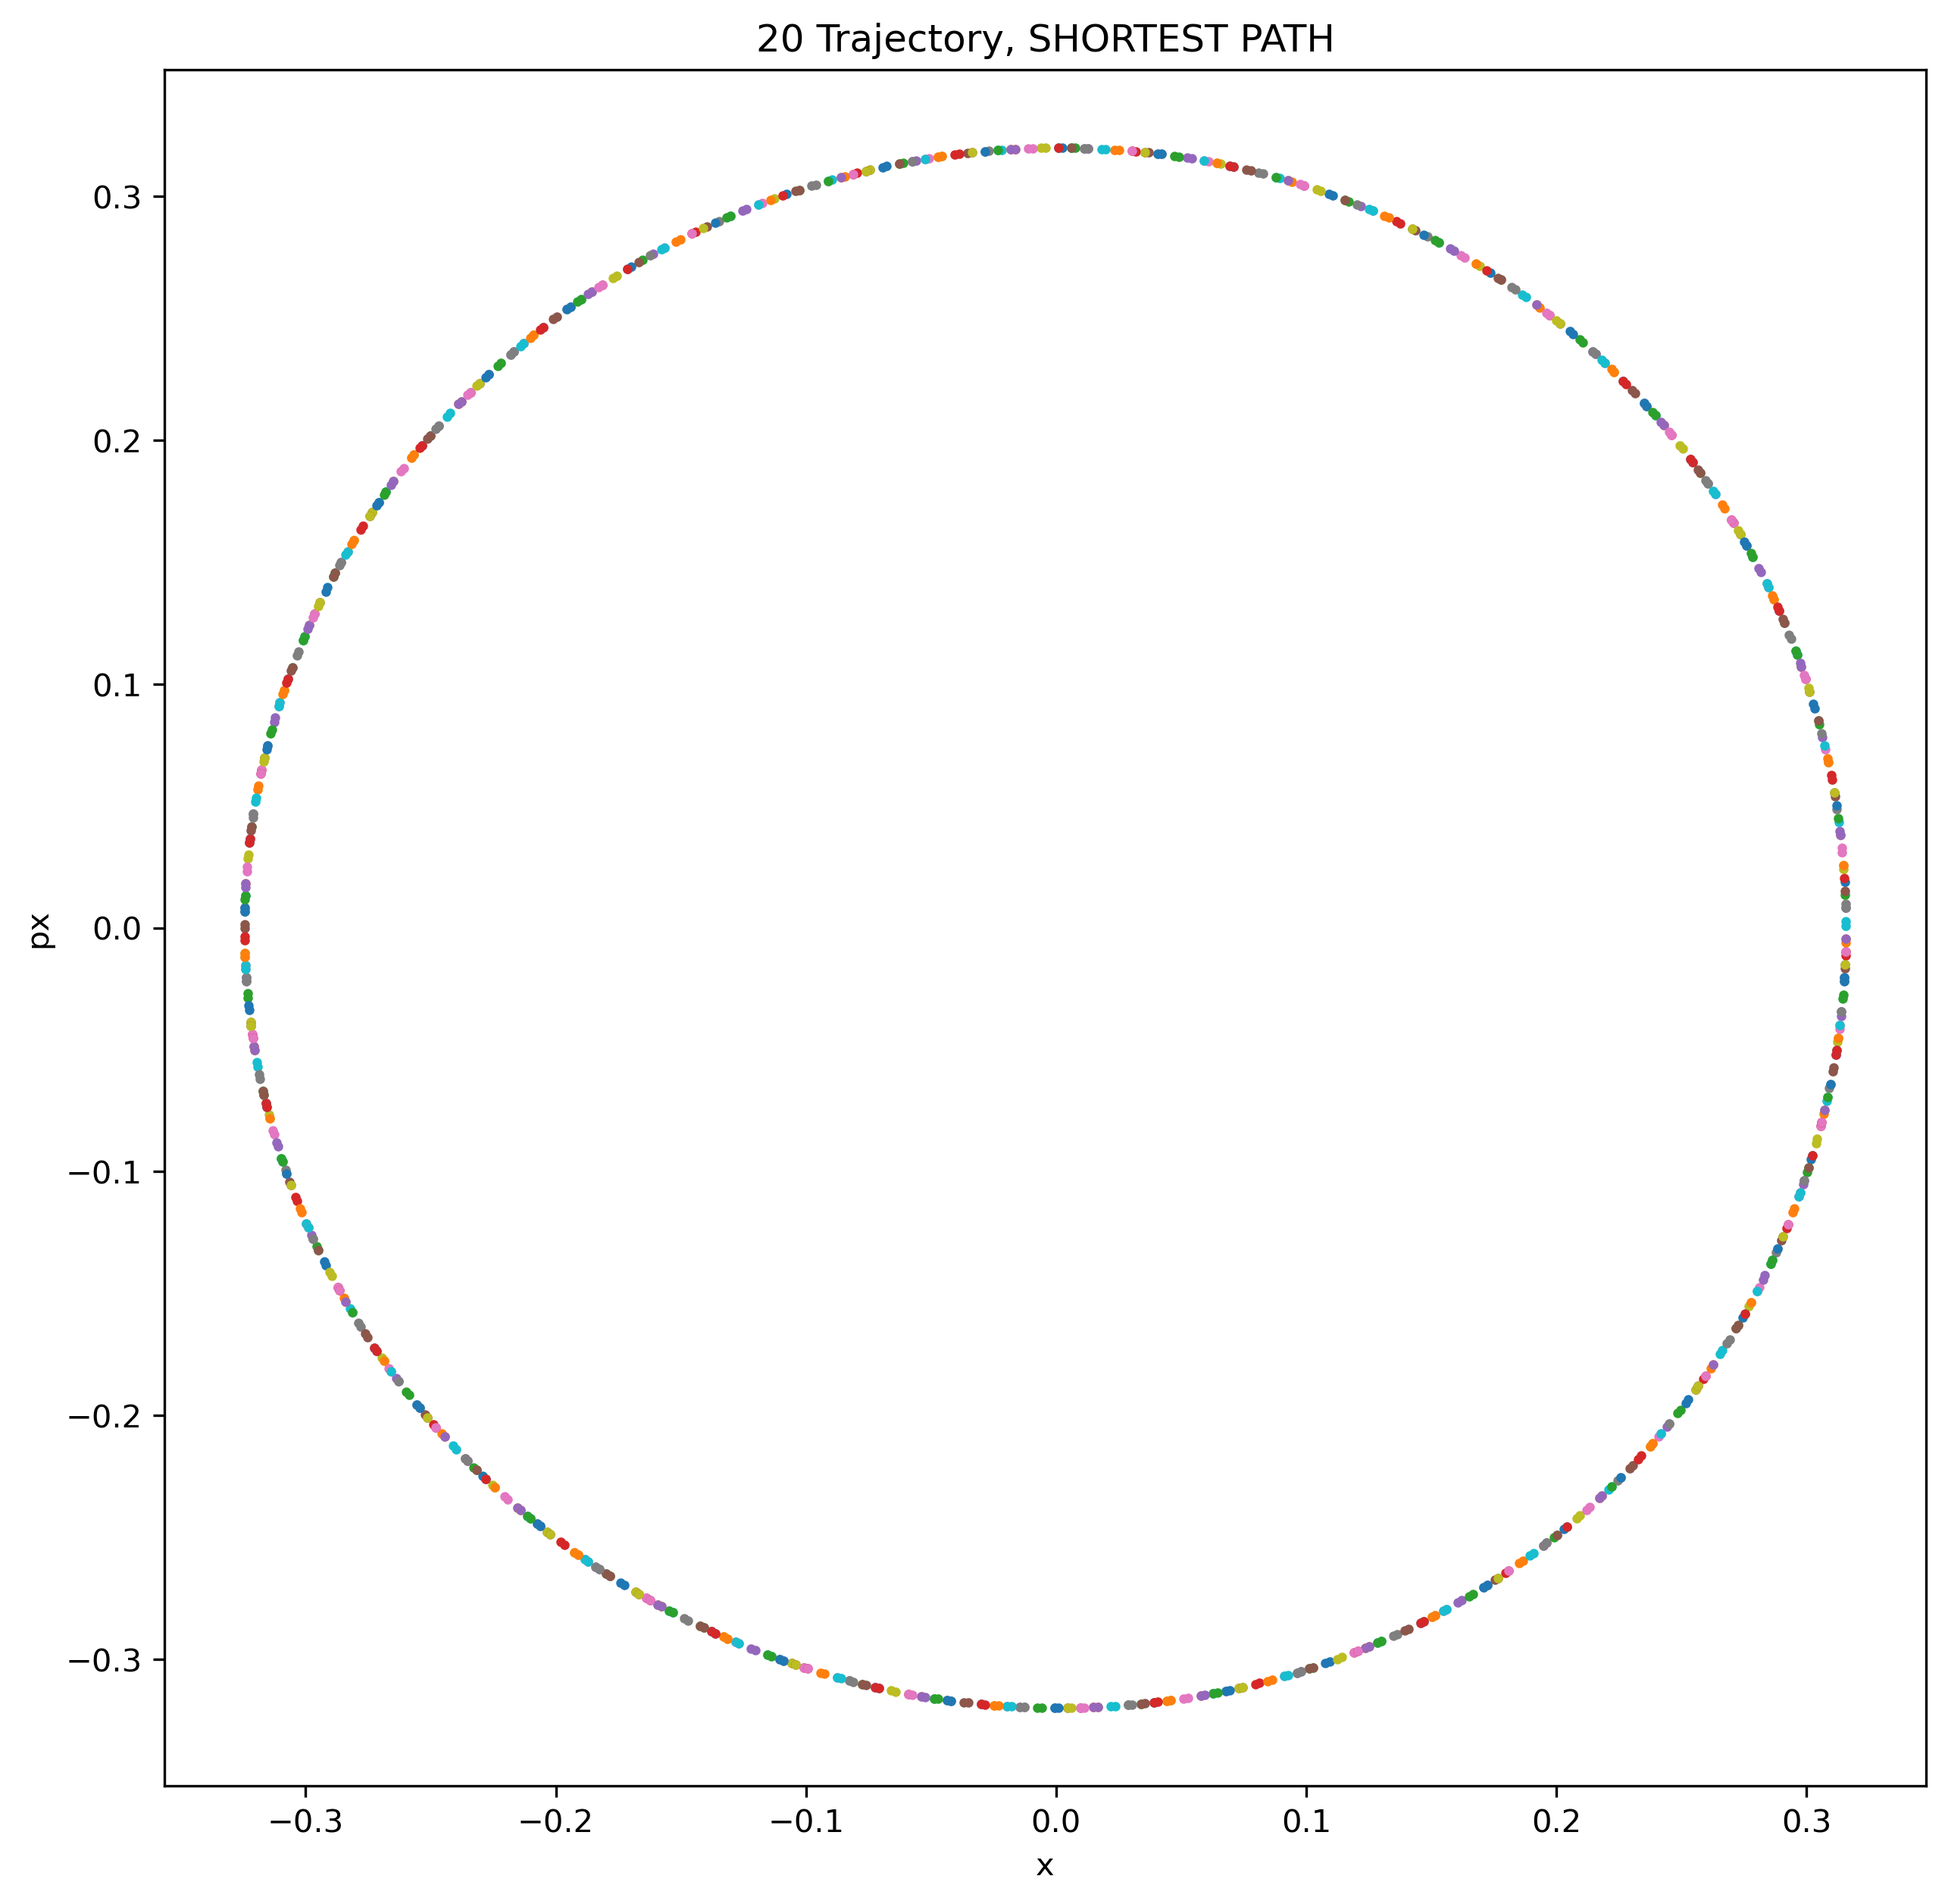

(1000, 2)
[0.45230715 0.44986628]


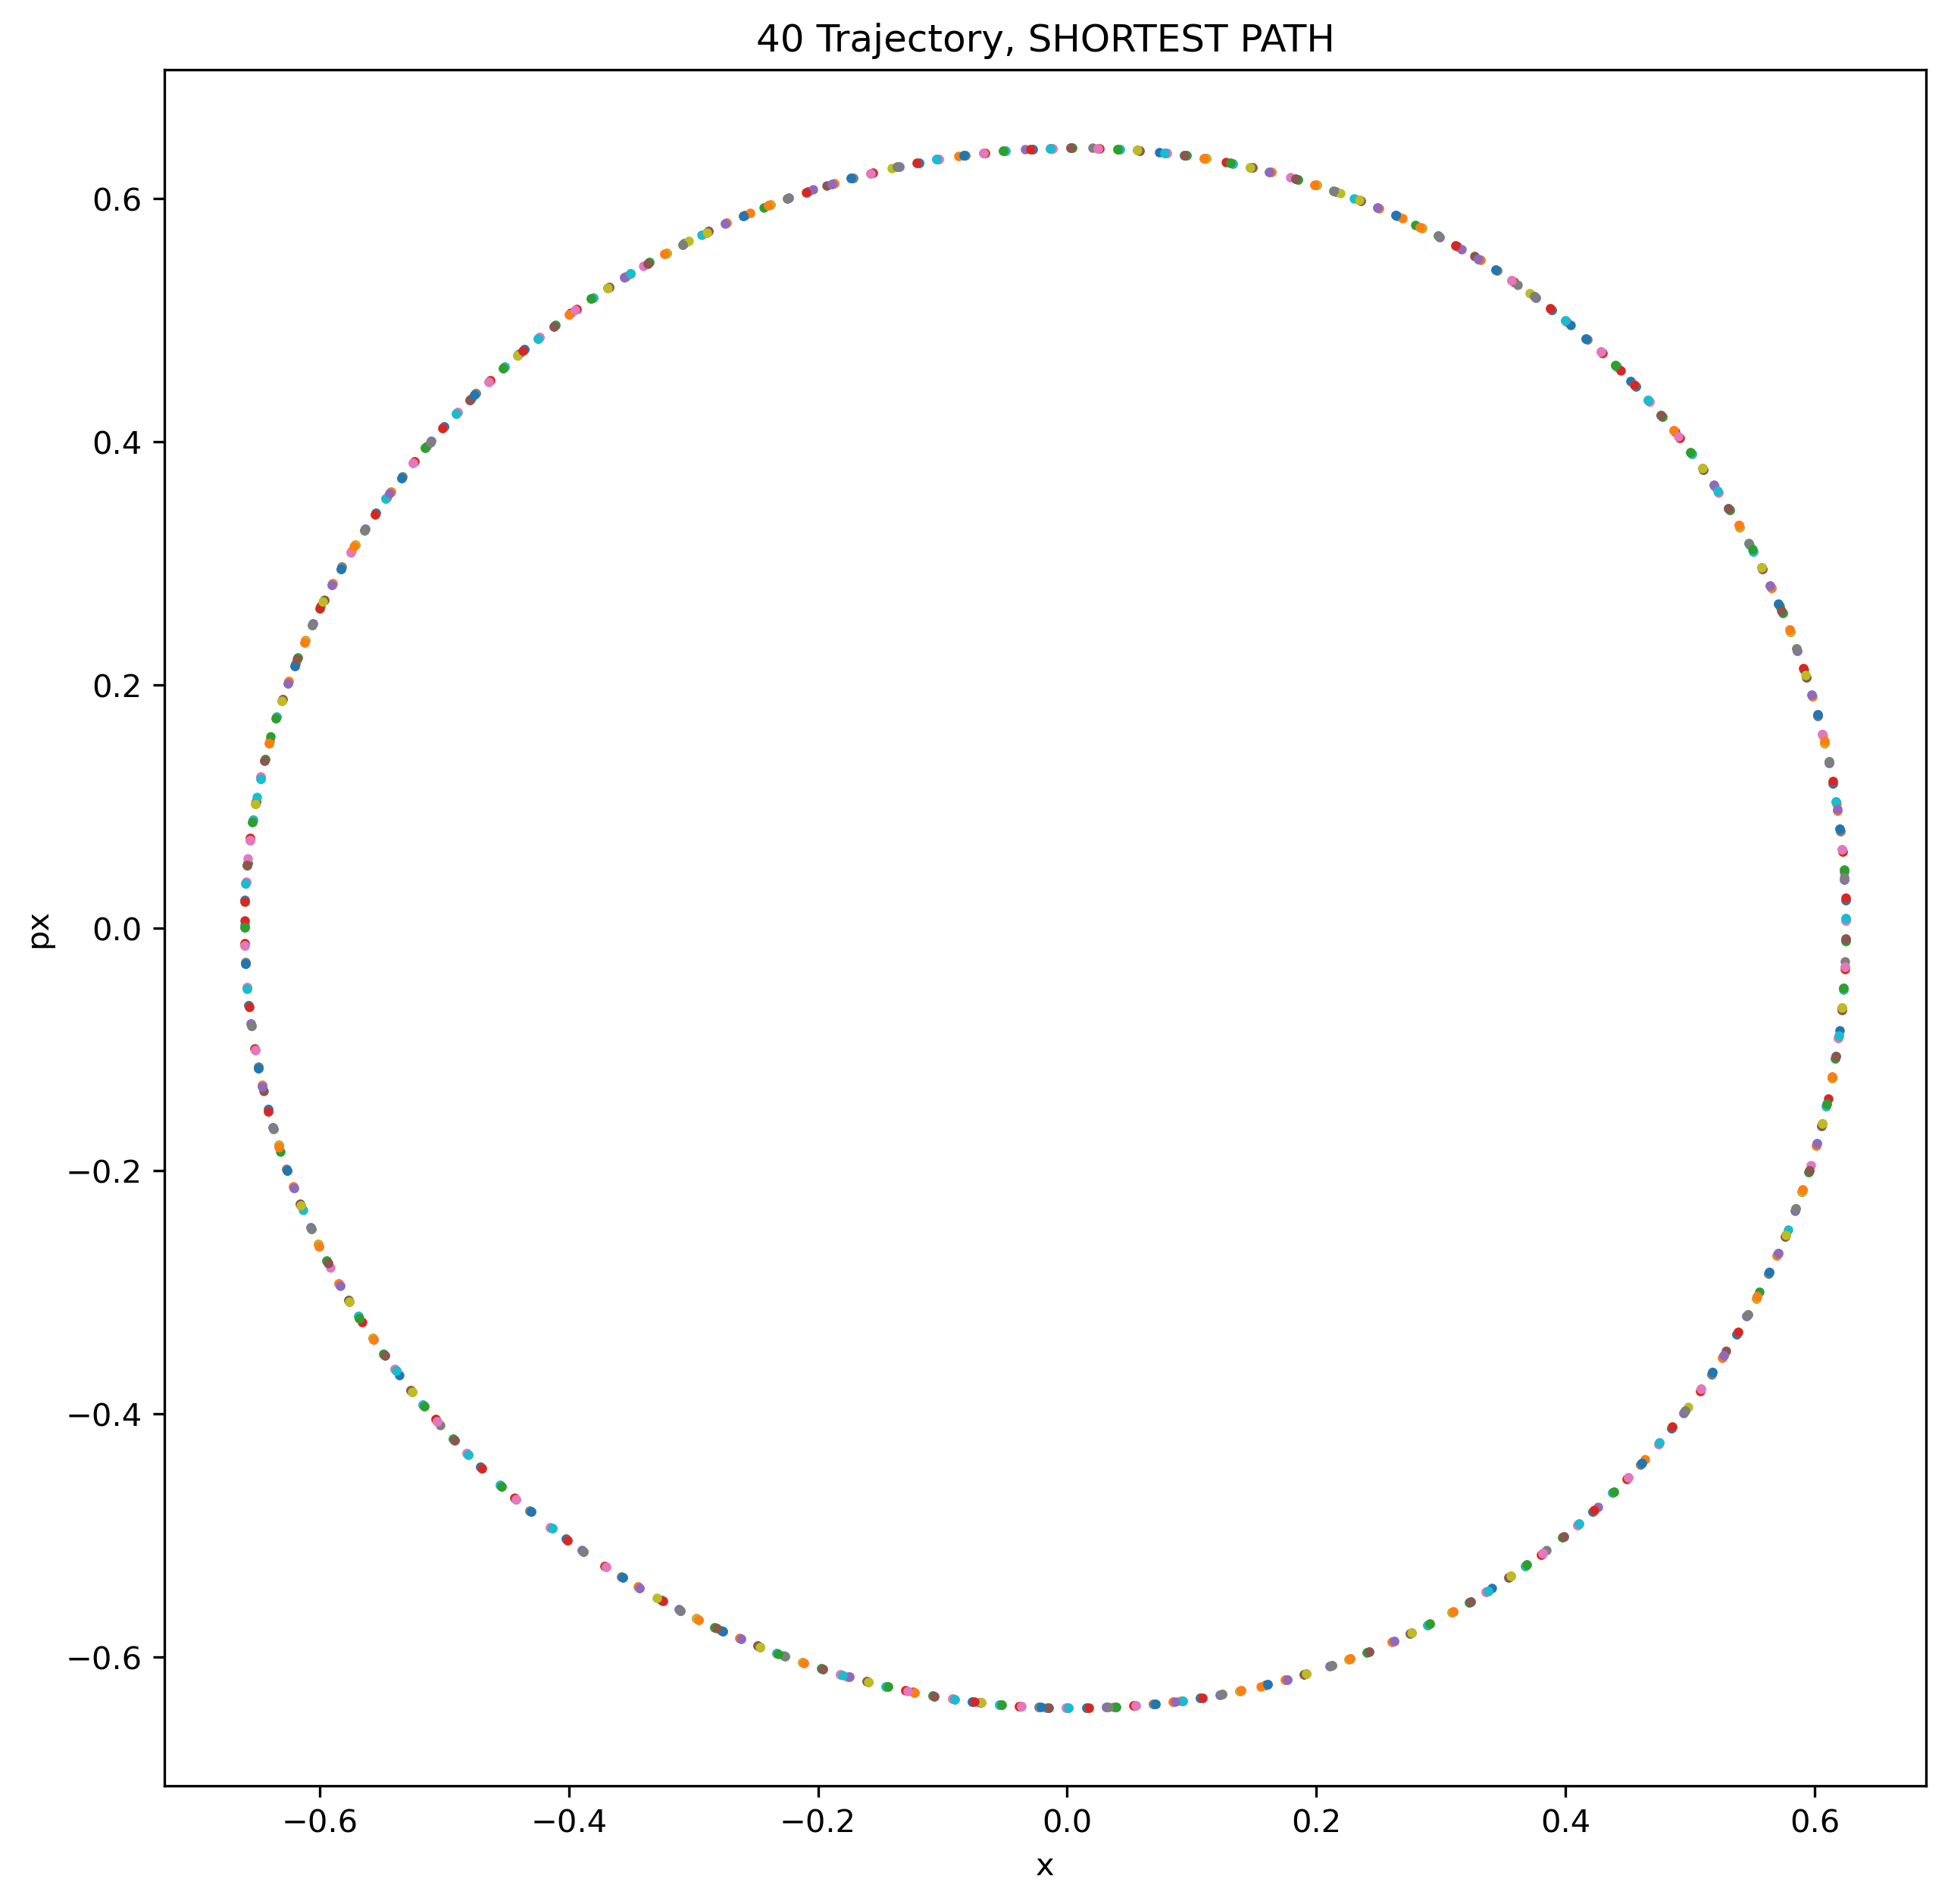

(1000, 2)
[0.67855169 0.67463499]


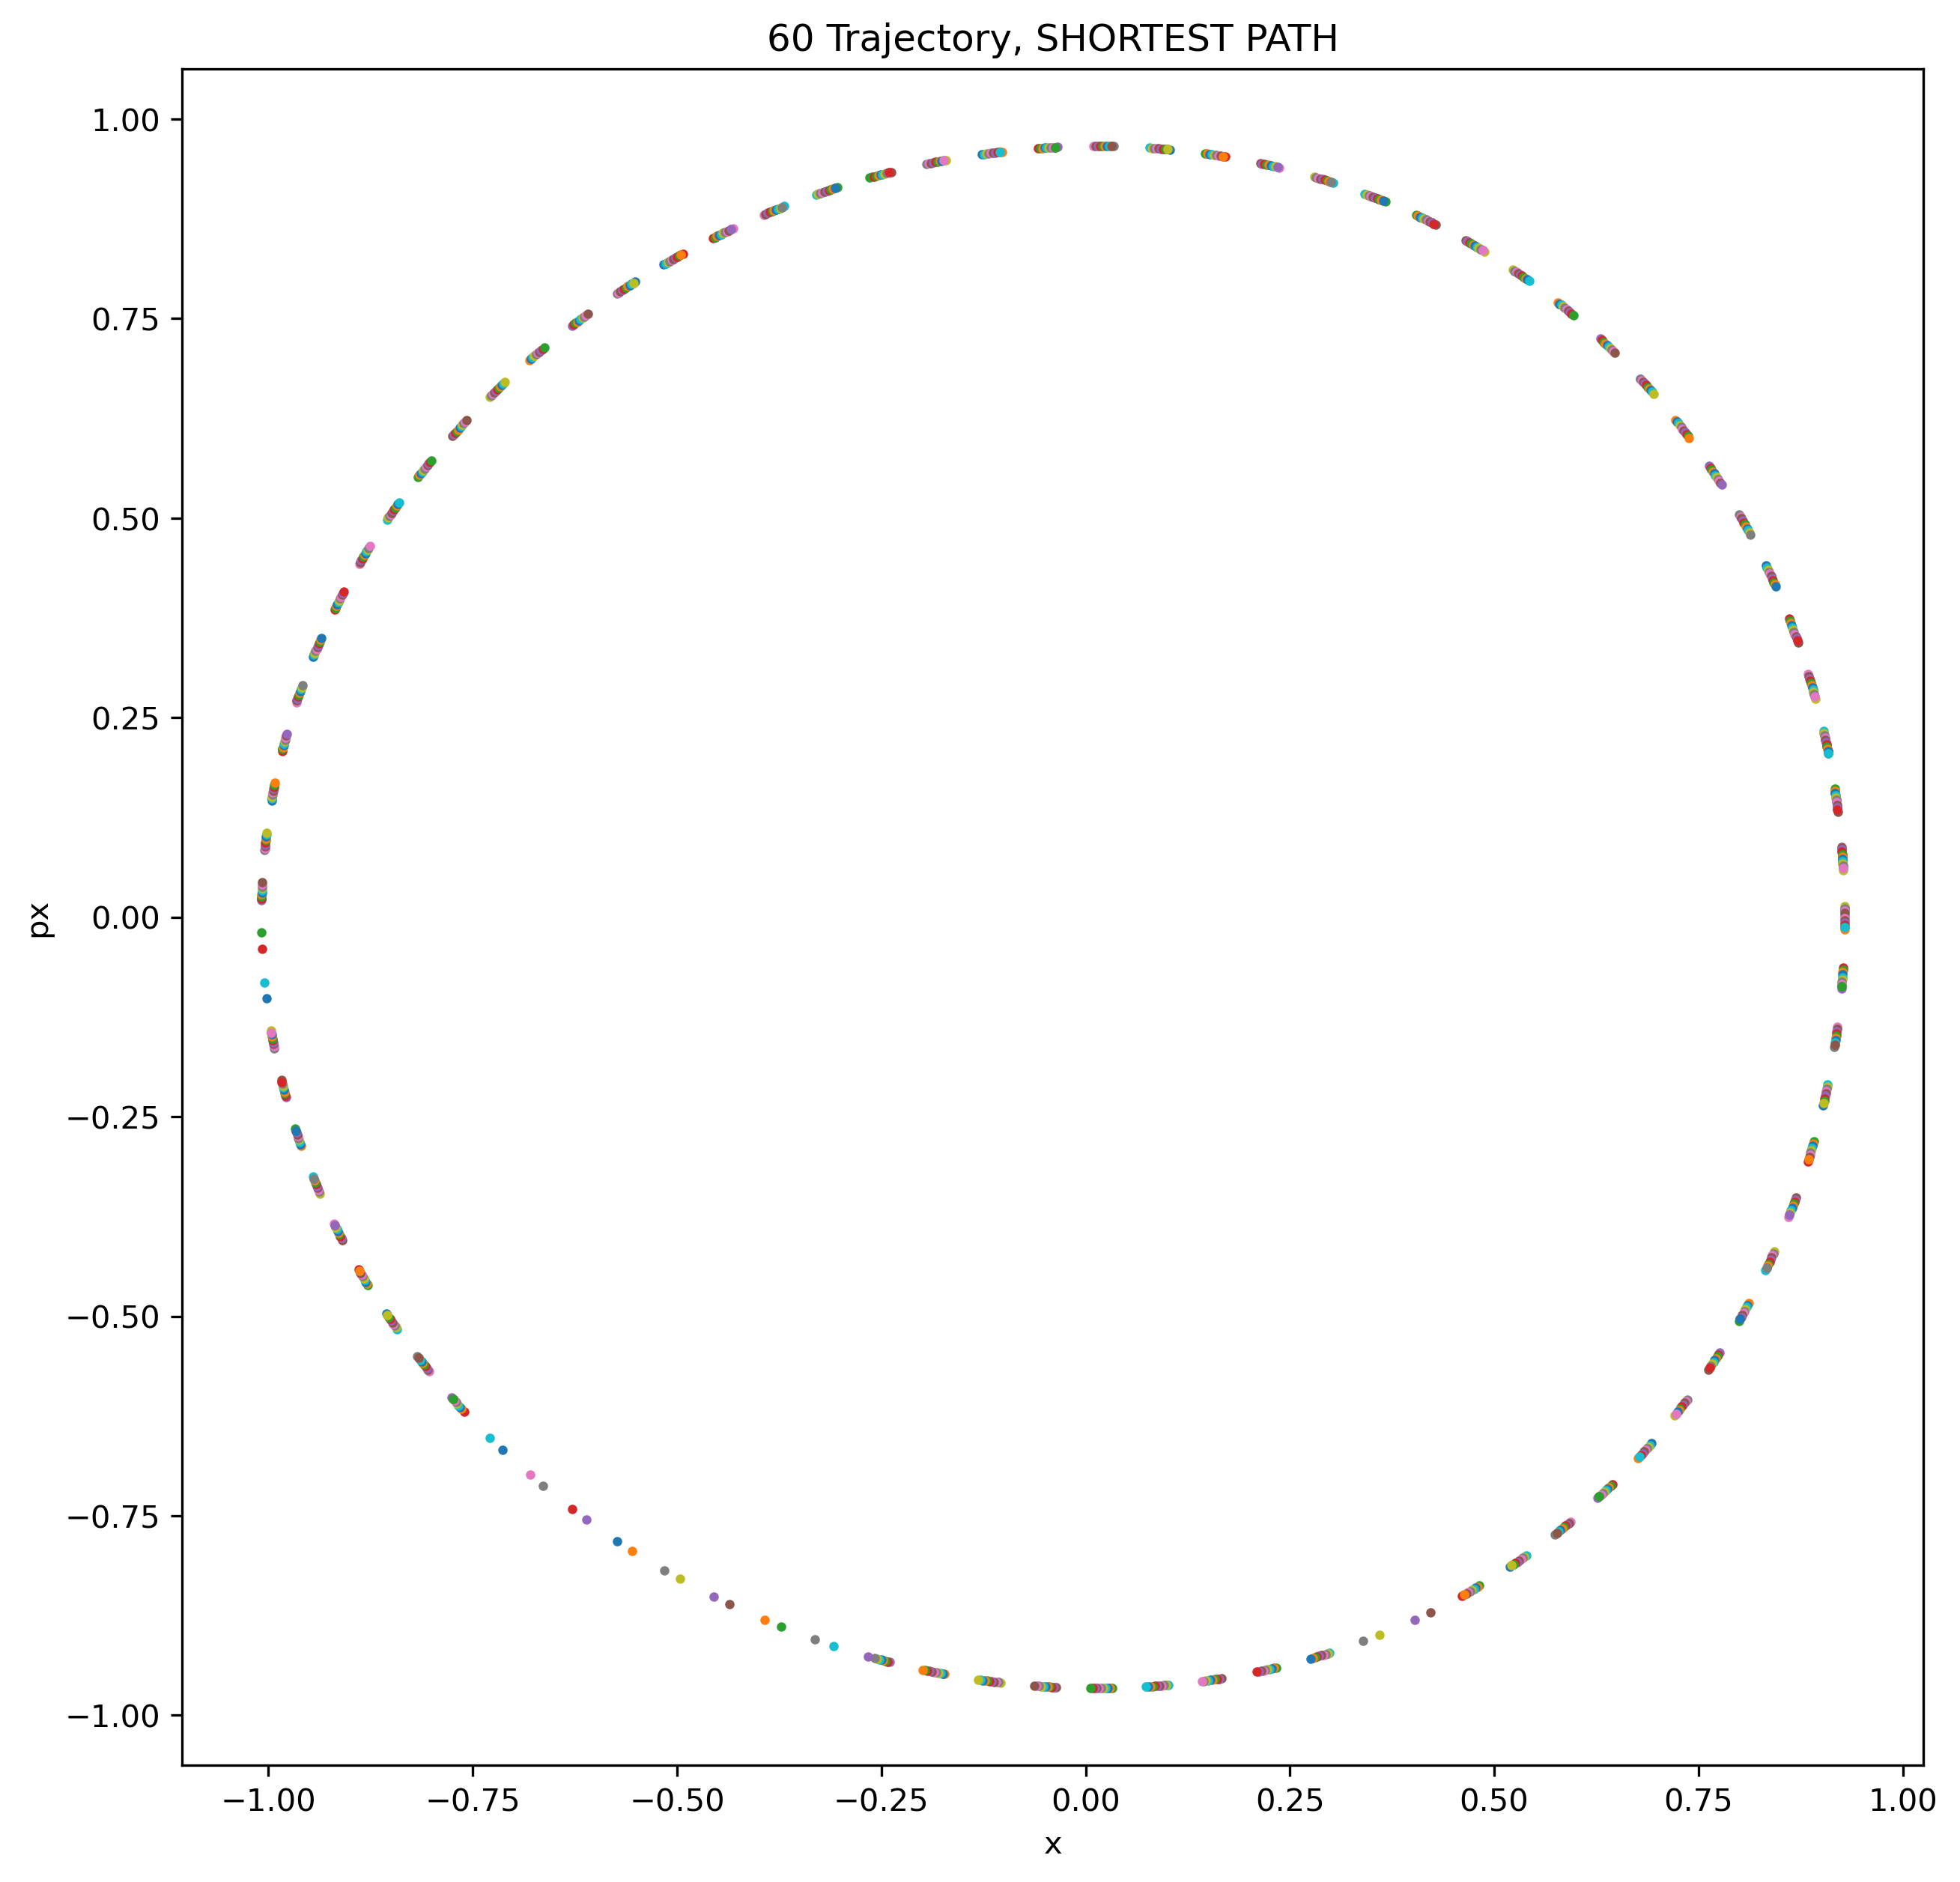

(1000, 2)
[0.89725934 0.90792027]


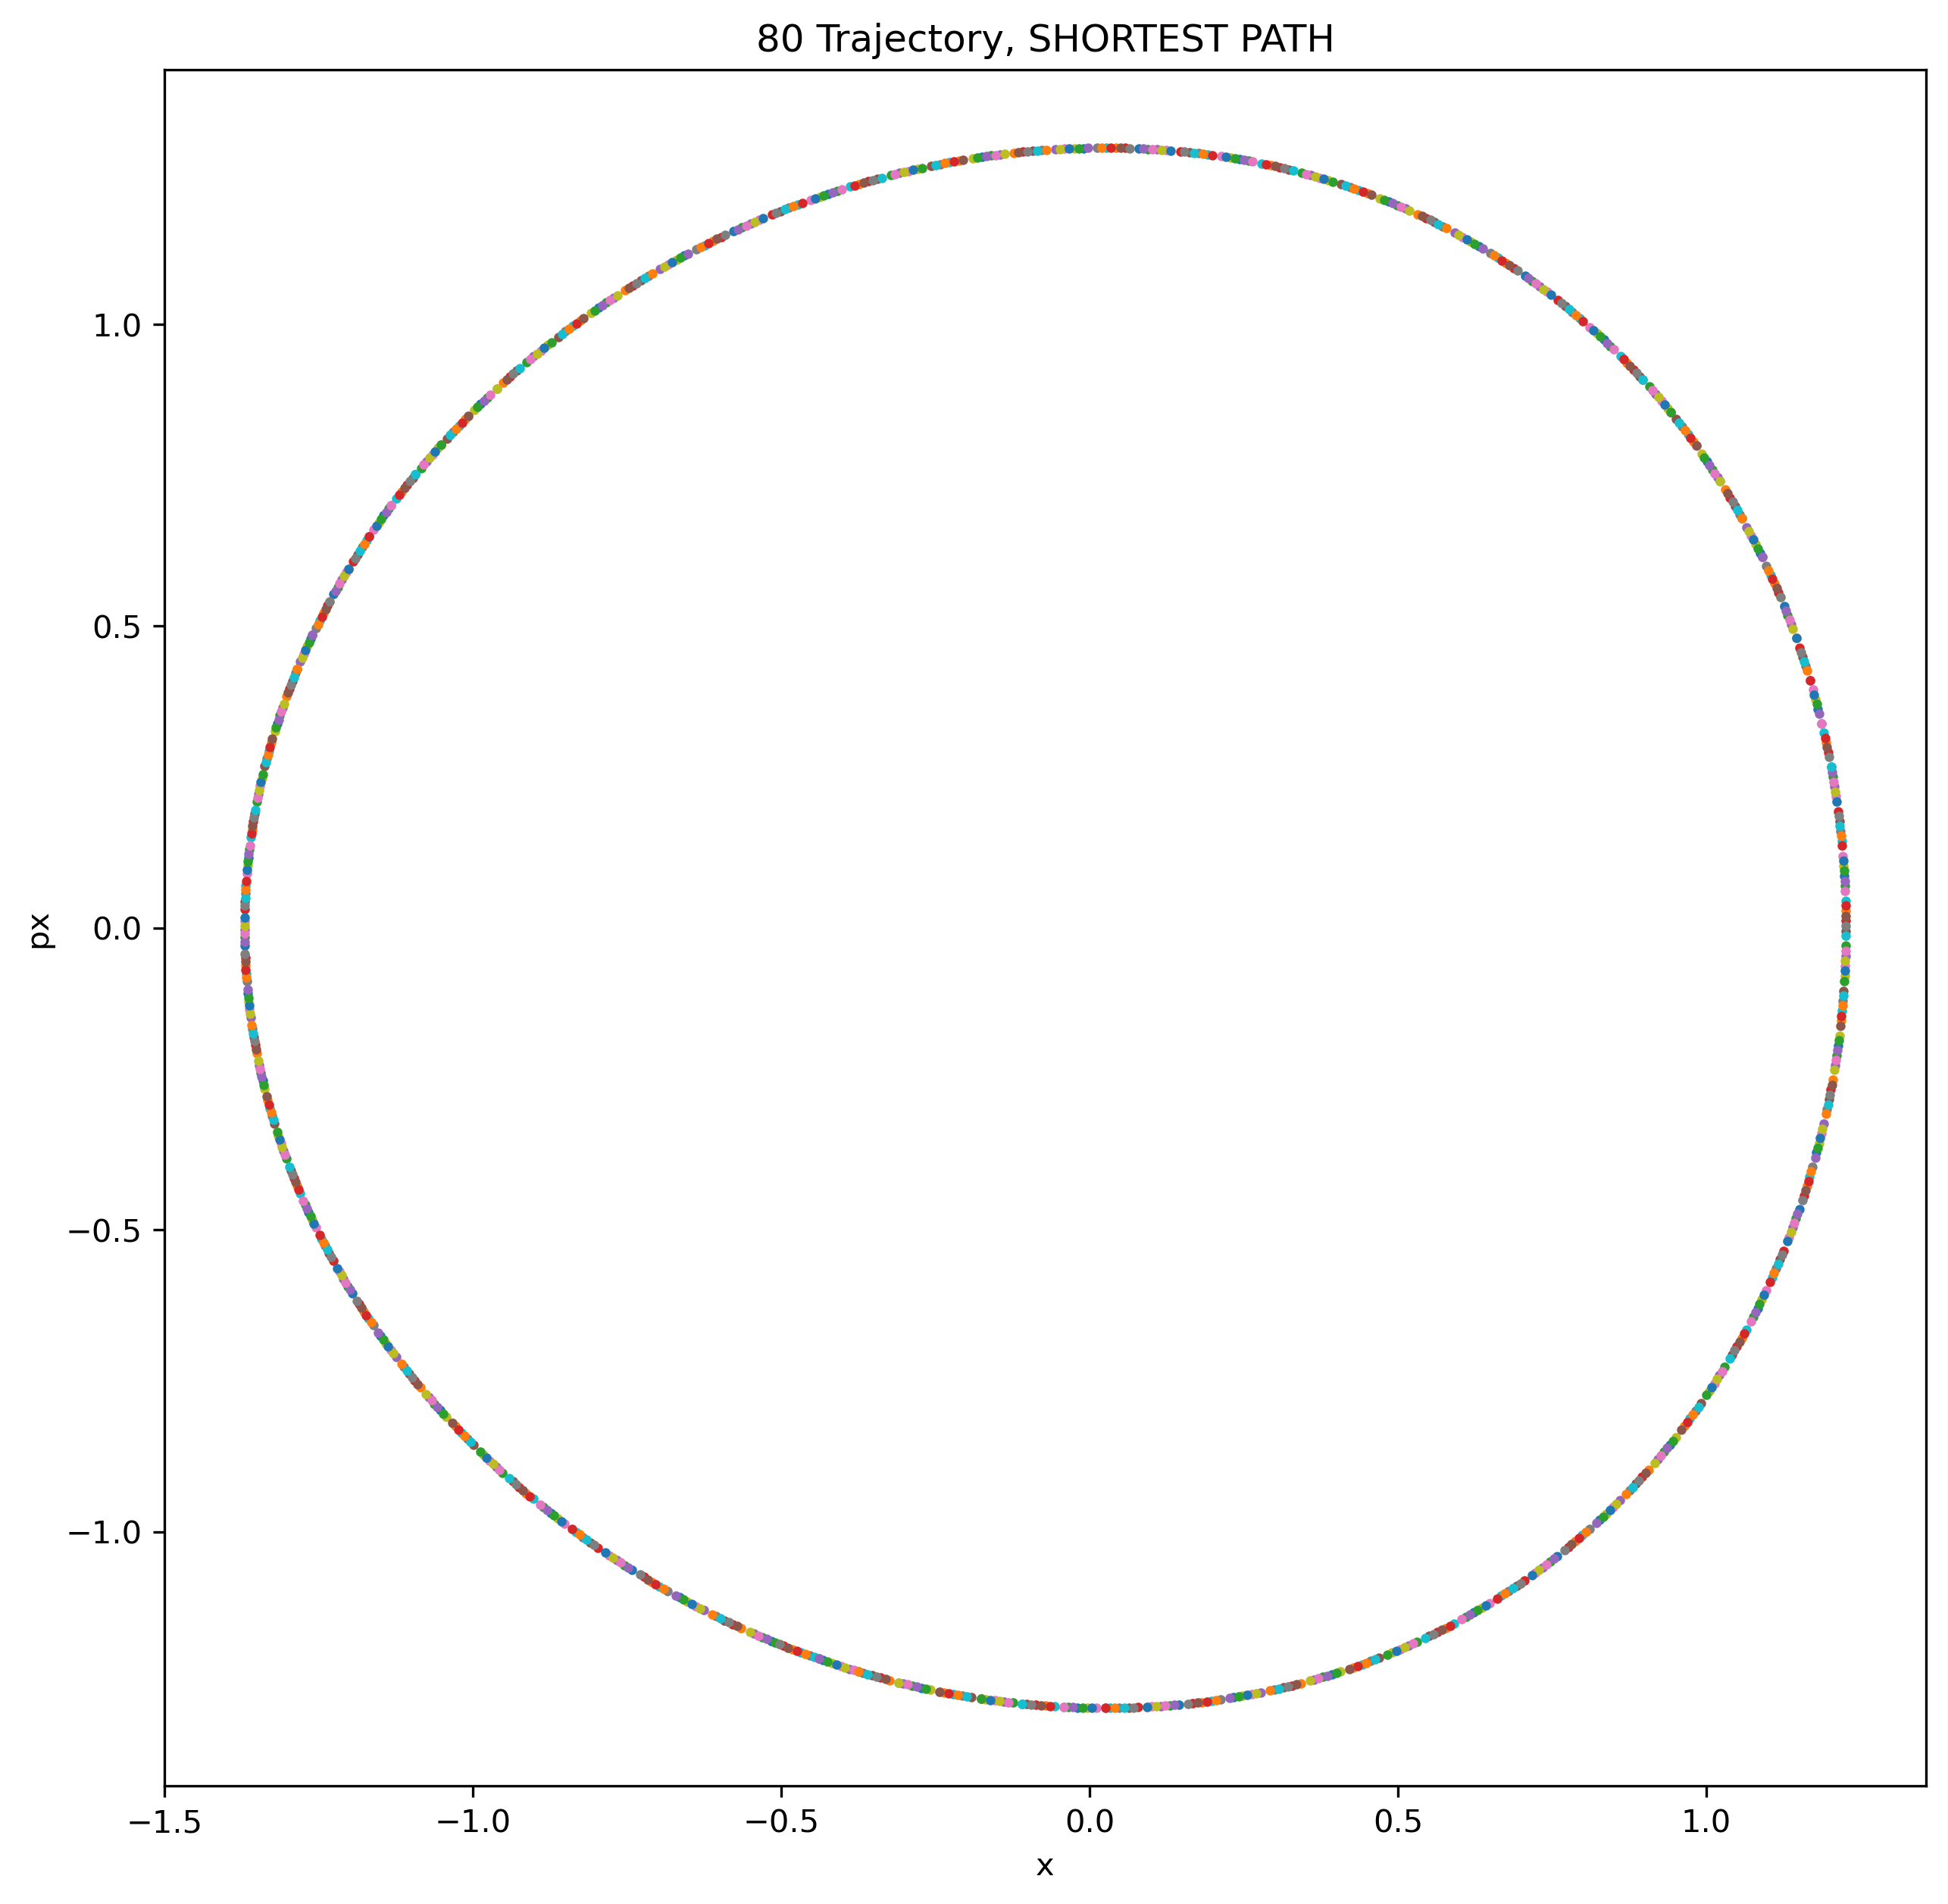

(1000, 2)
[1.12896783 1.12645265]


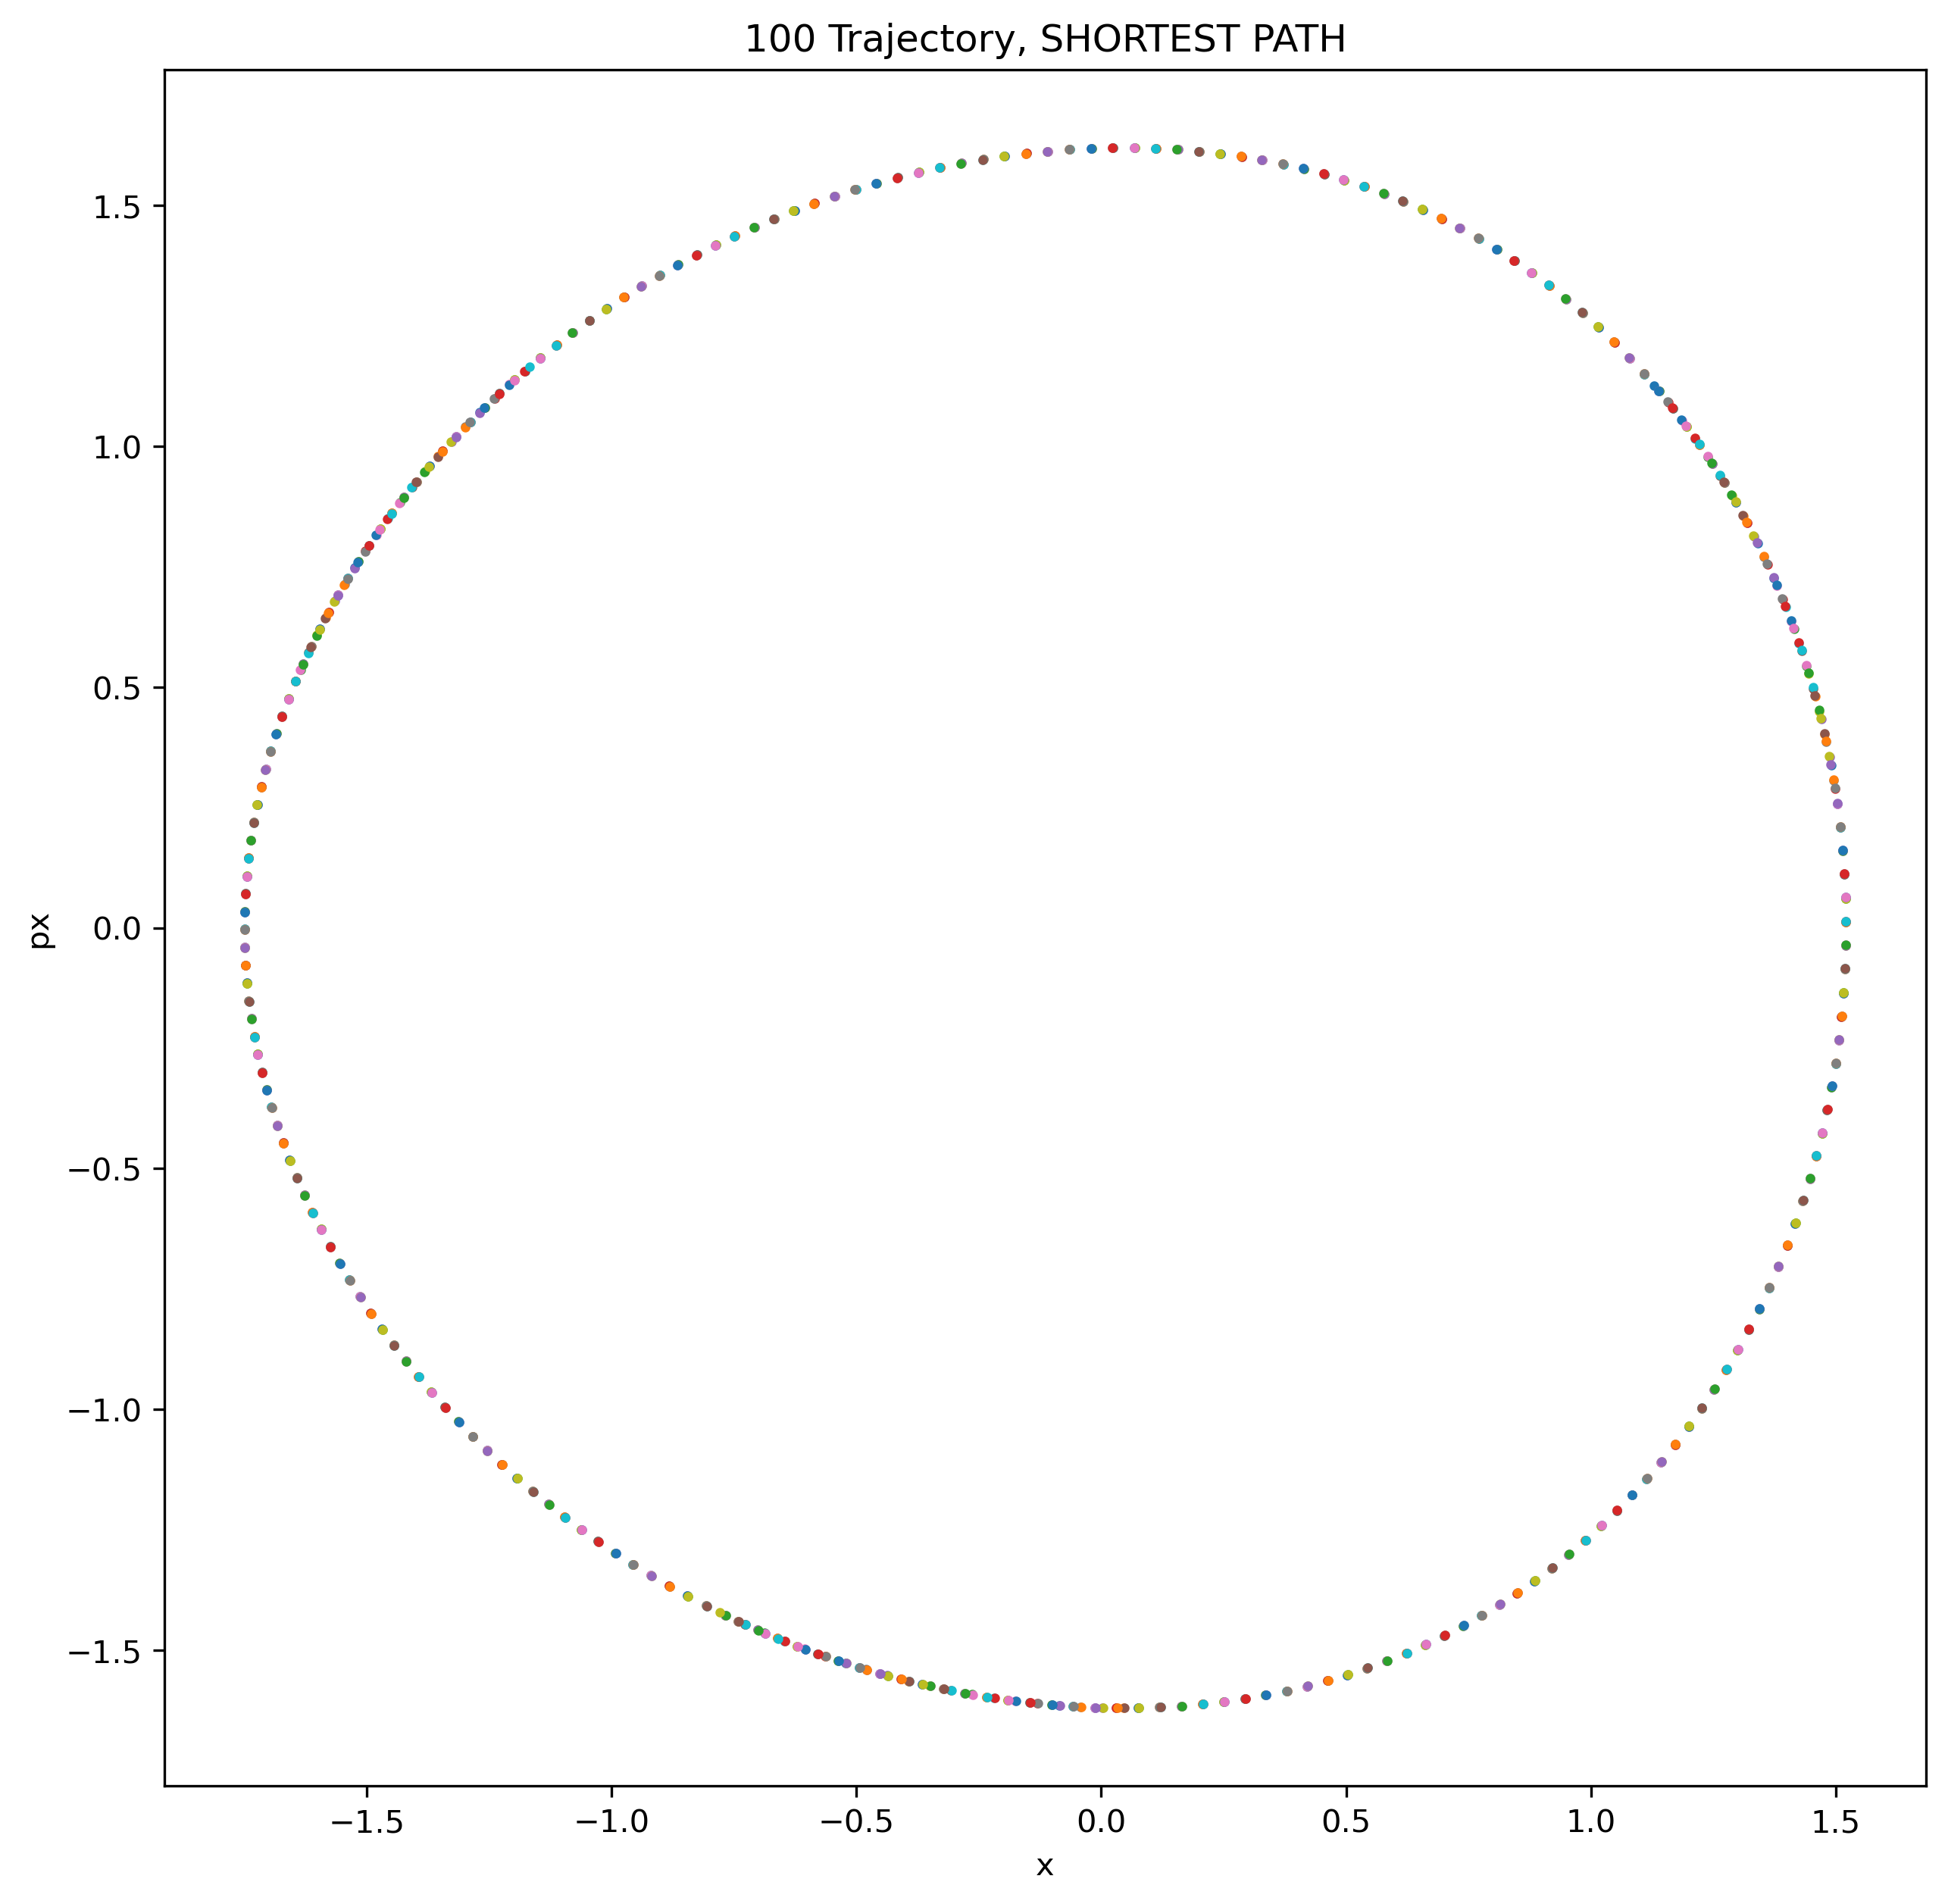

(1000, 2)
[1.34734587 1.35984084]


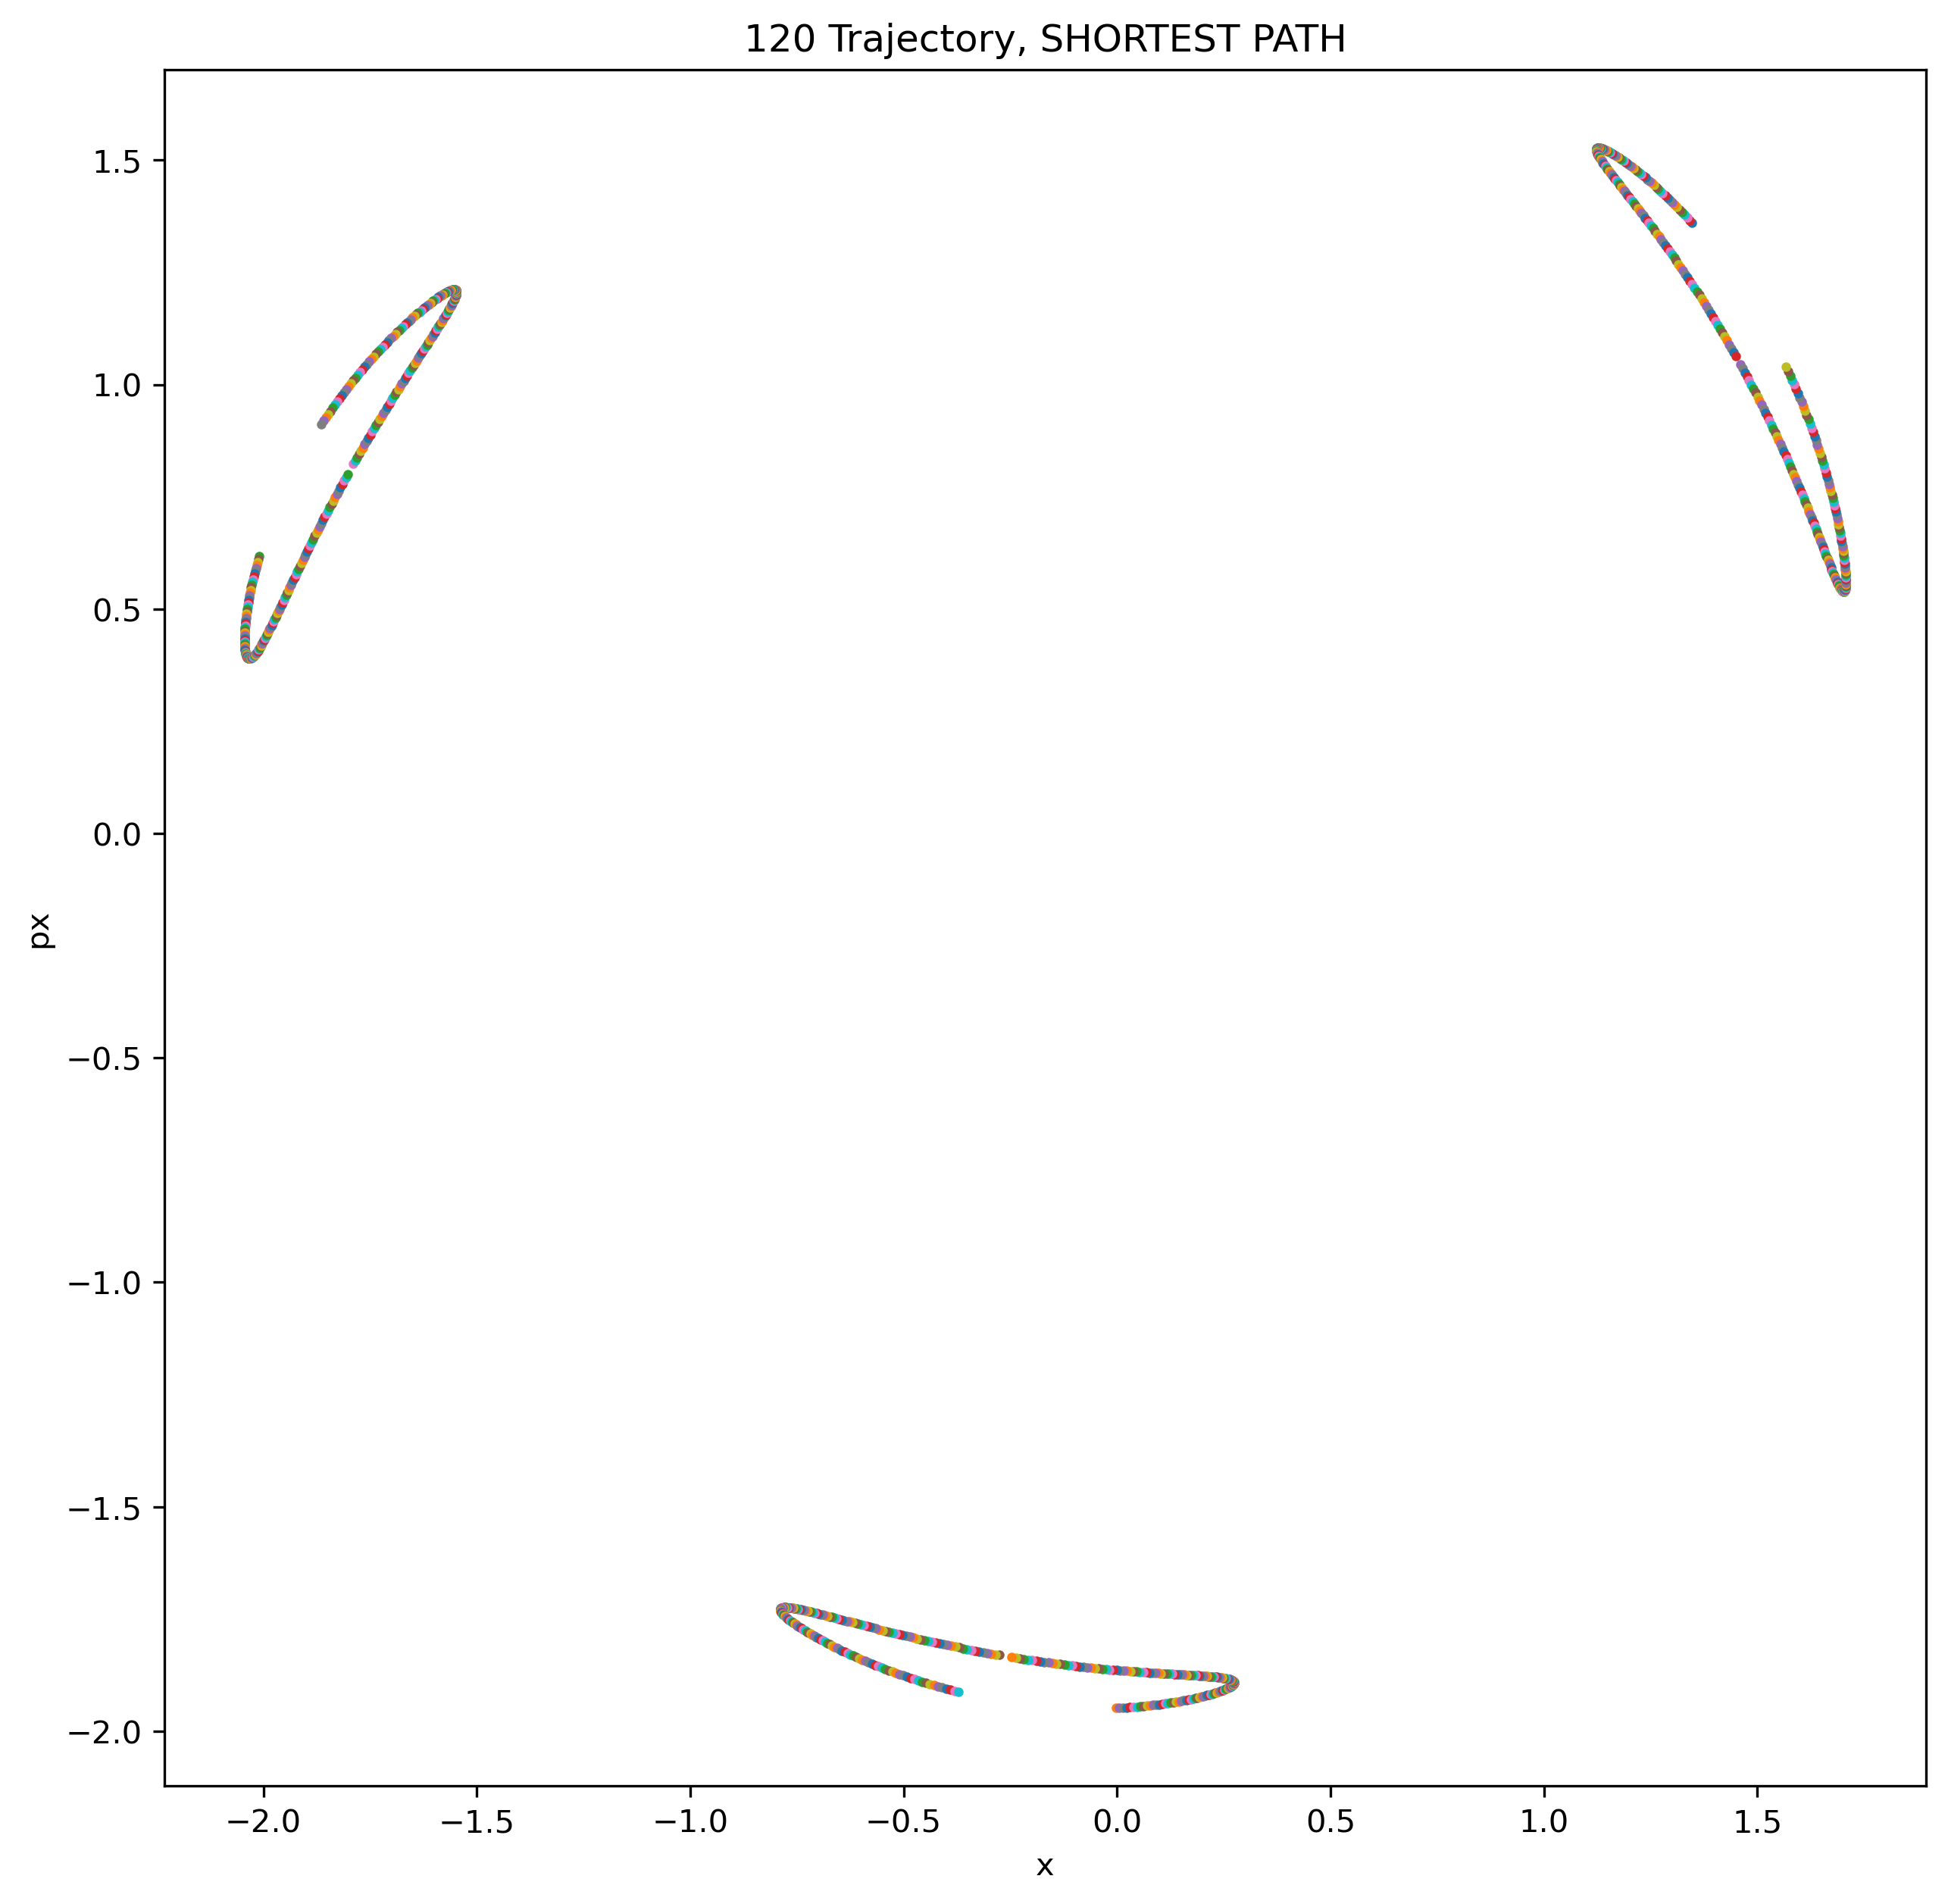

(1000, 2)
[1.58455397 1.57199461]


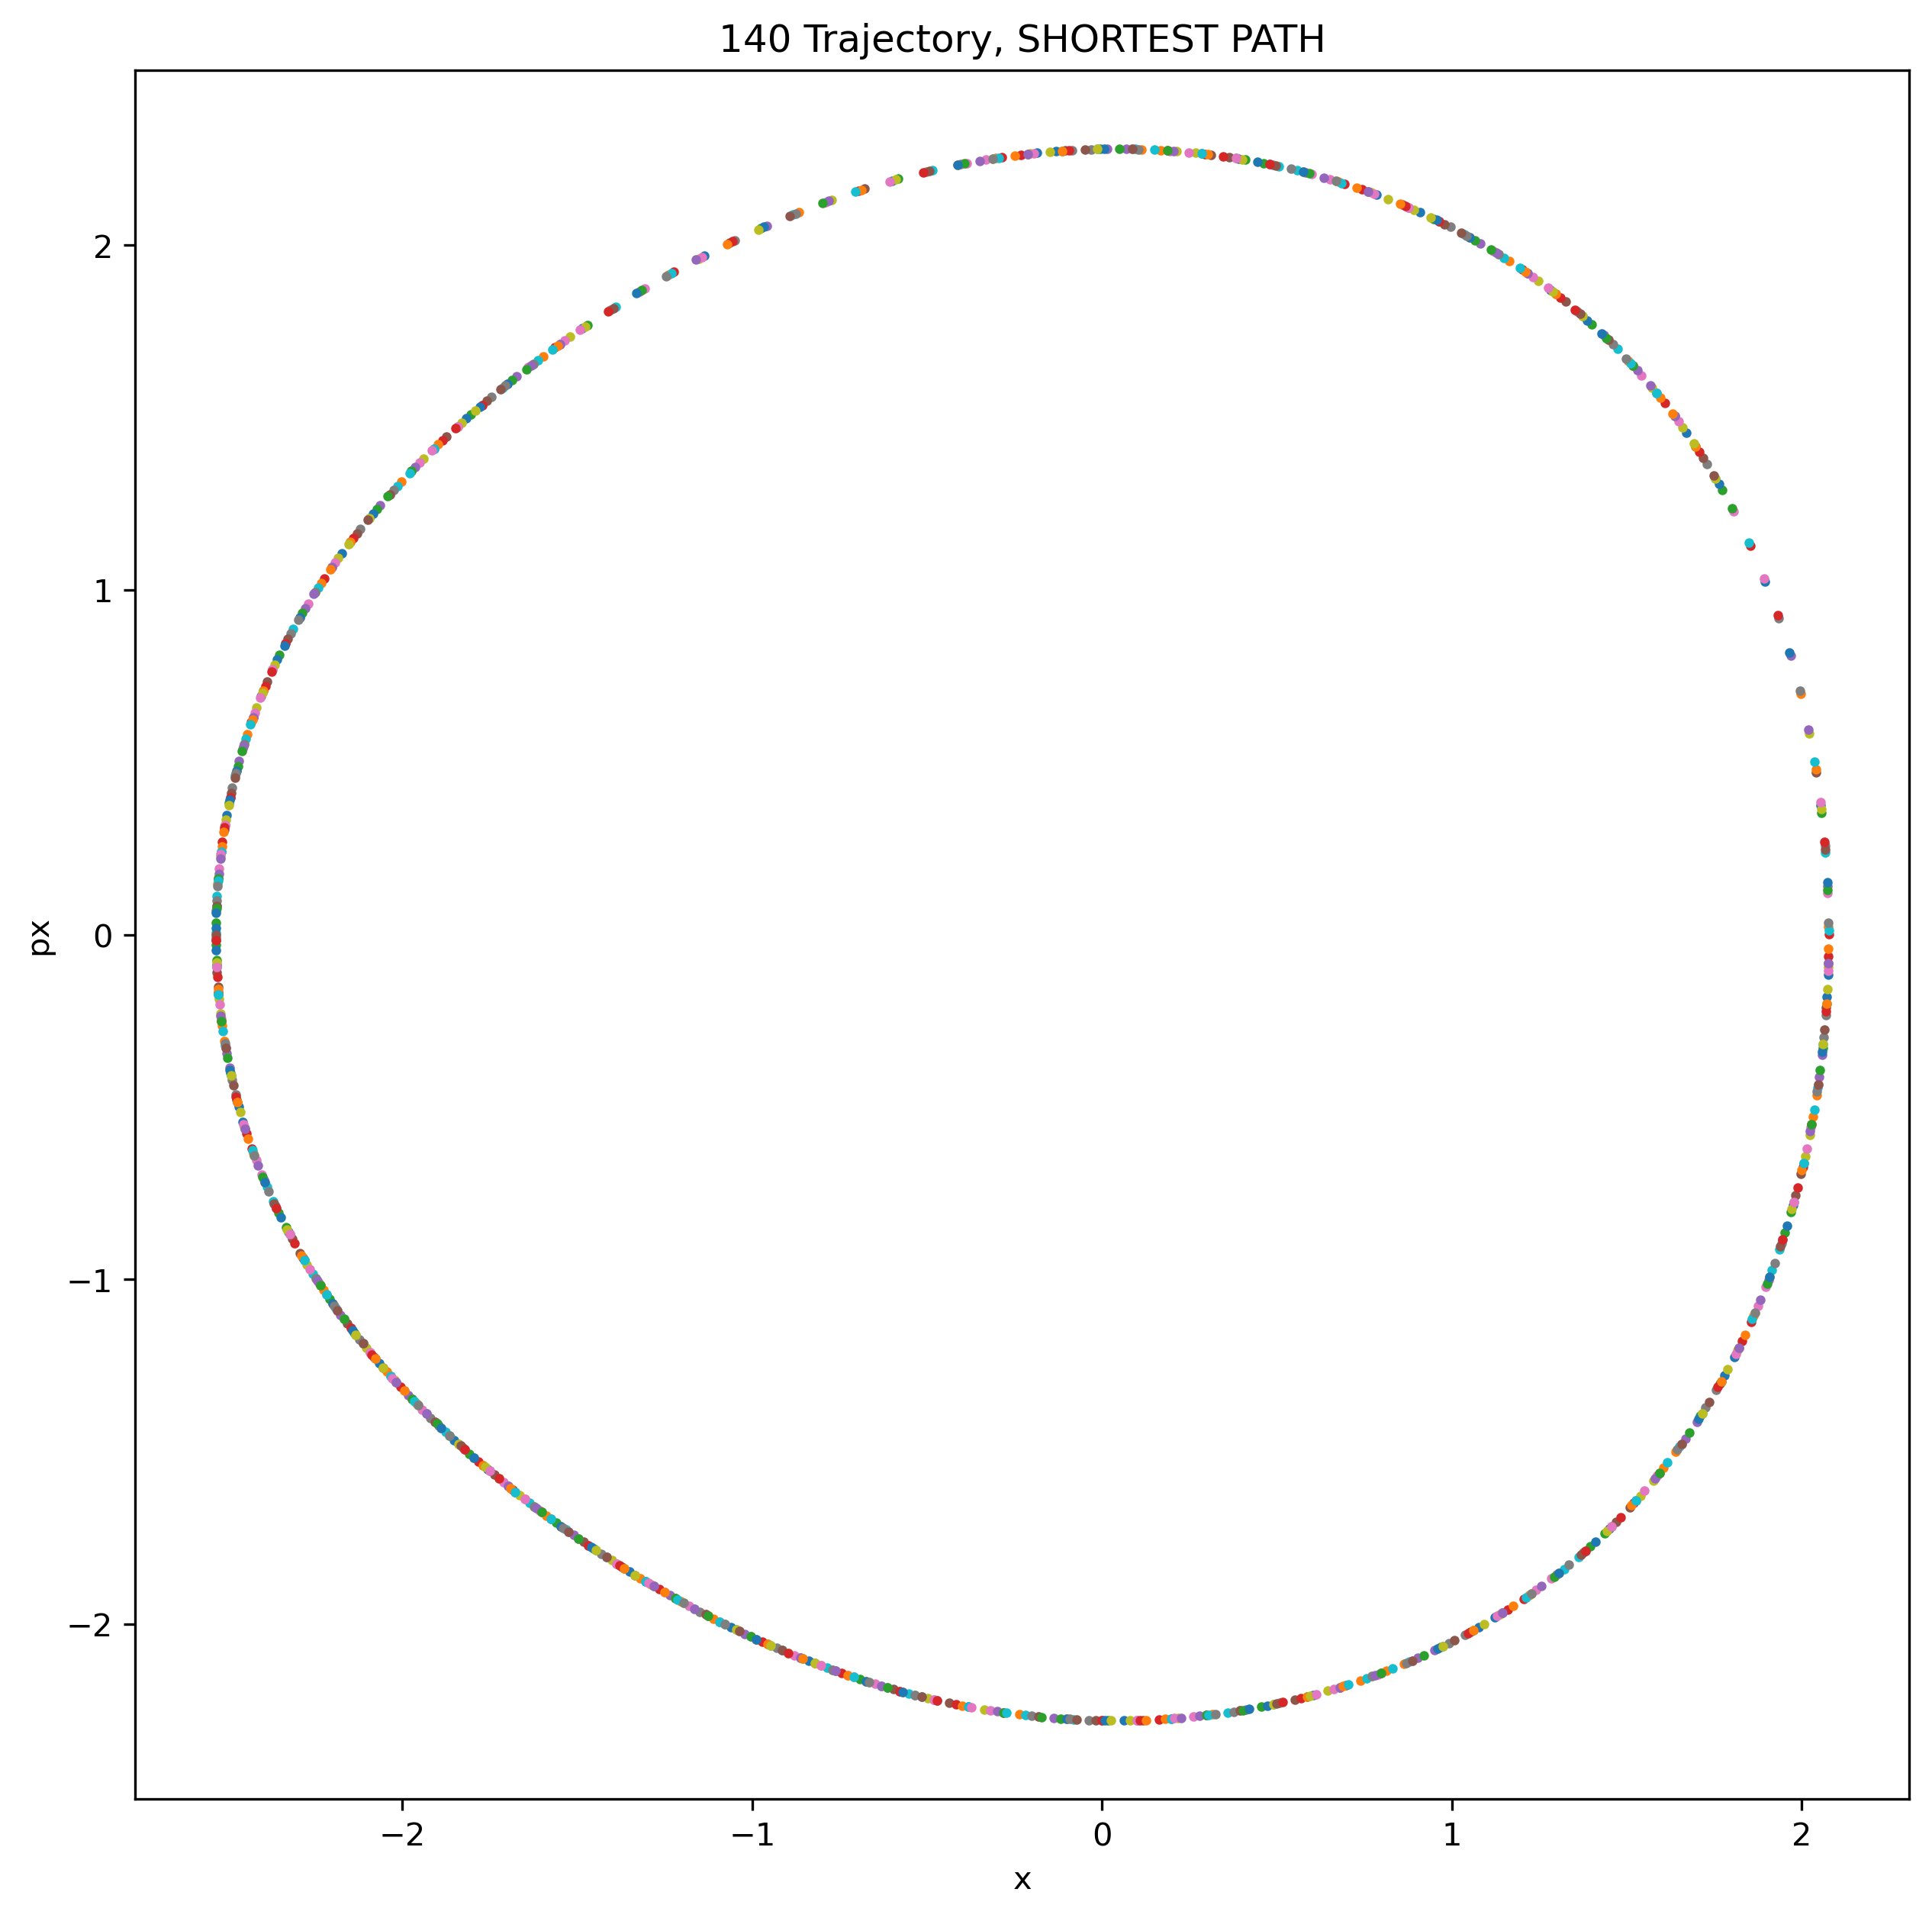

(1000, 2)
[1.79511884 1.81650059]


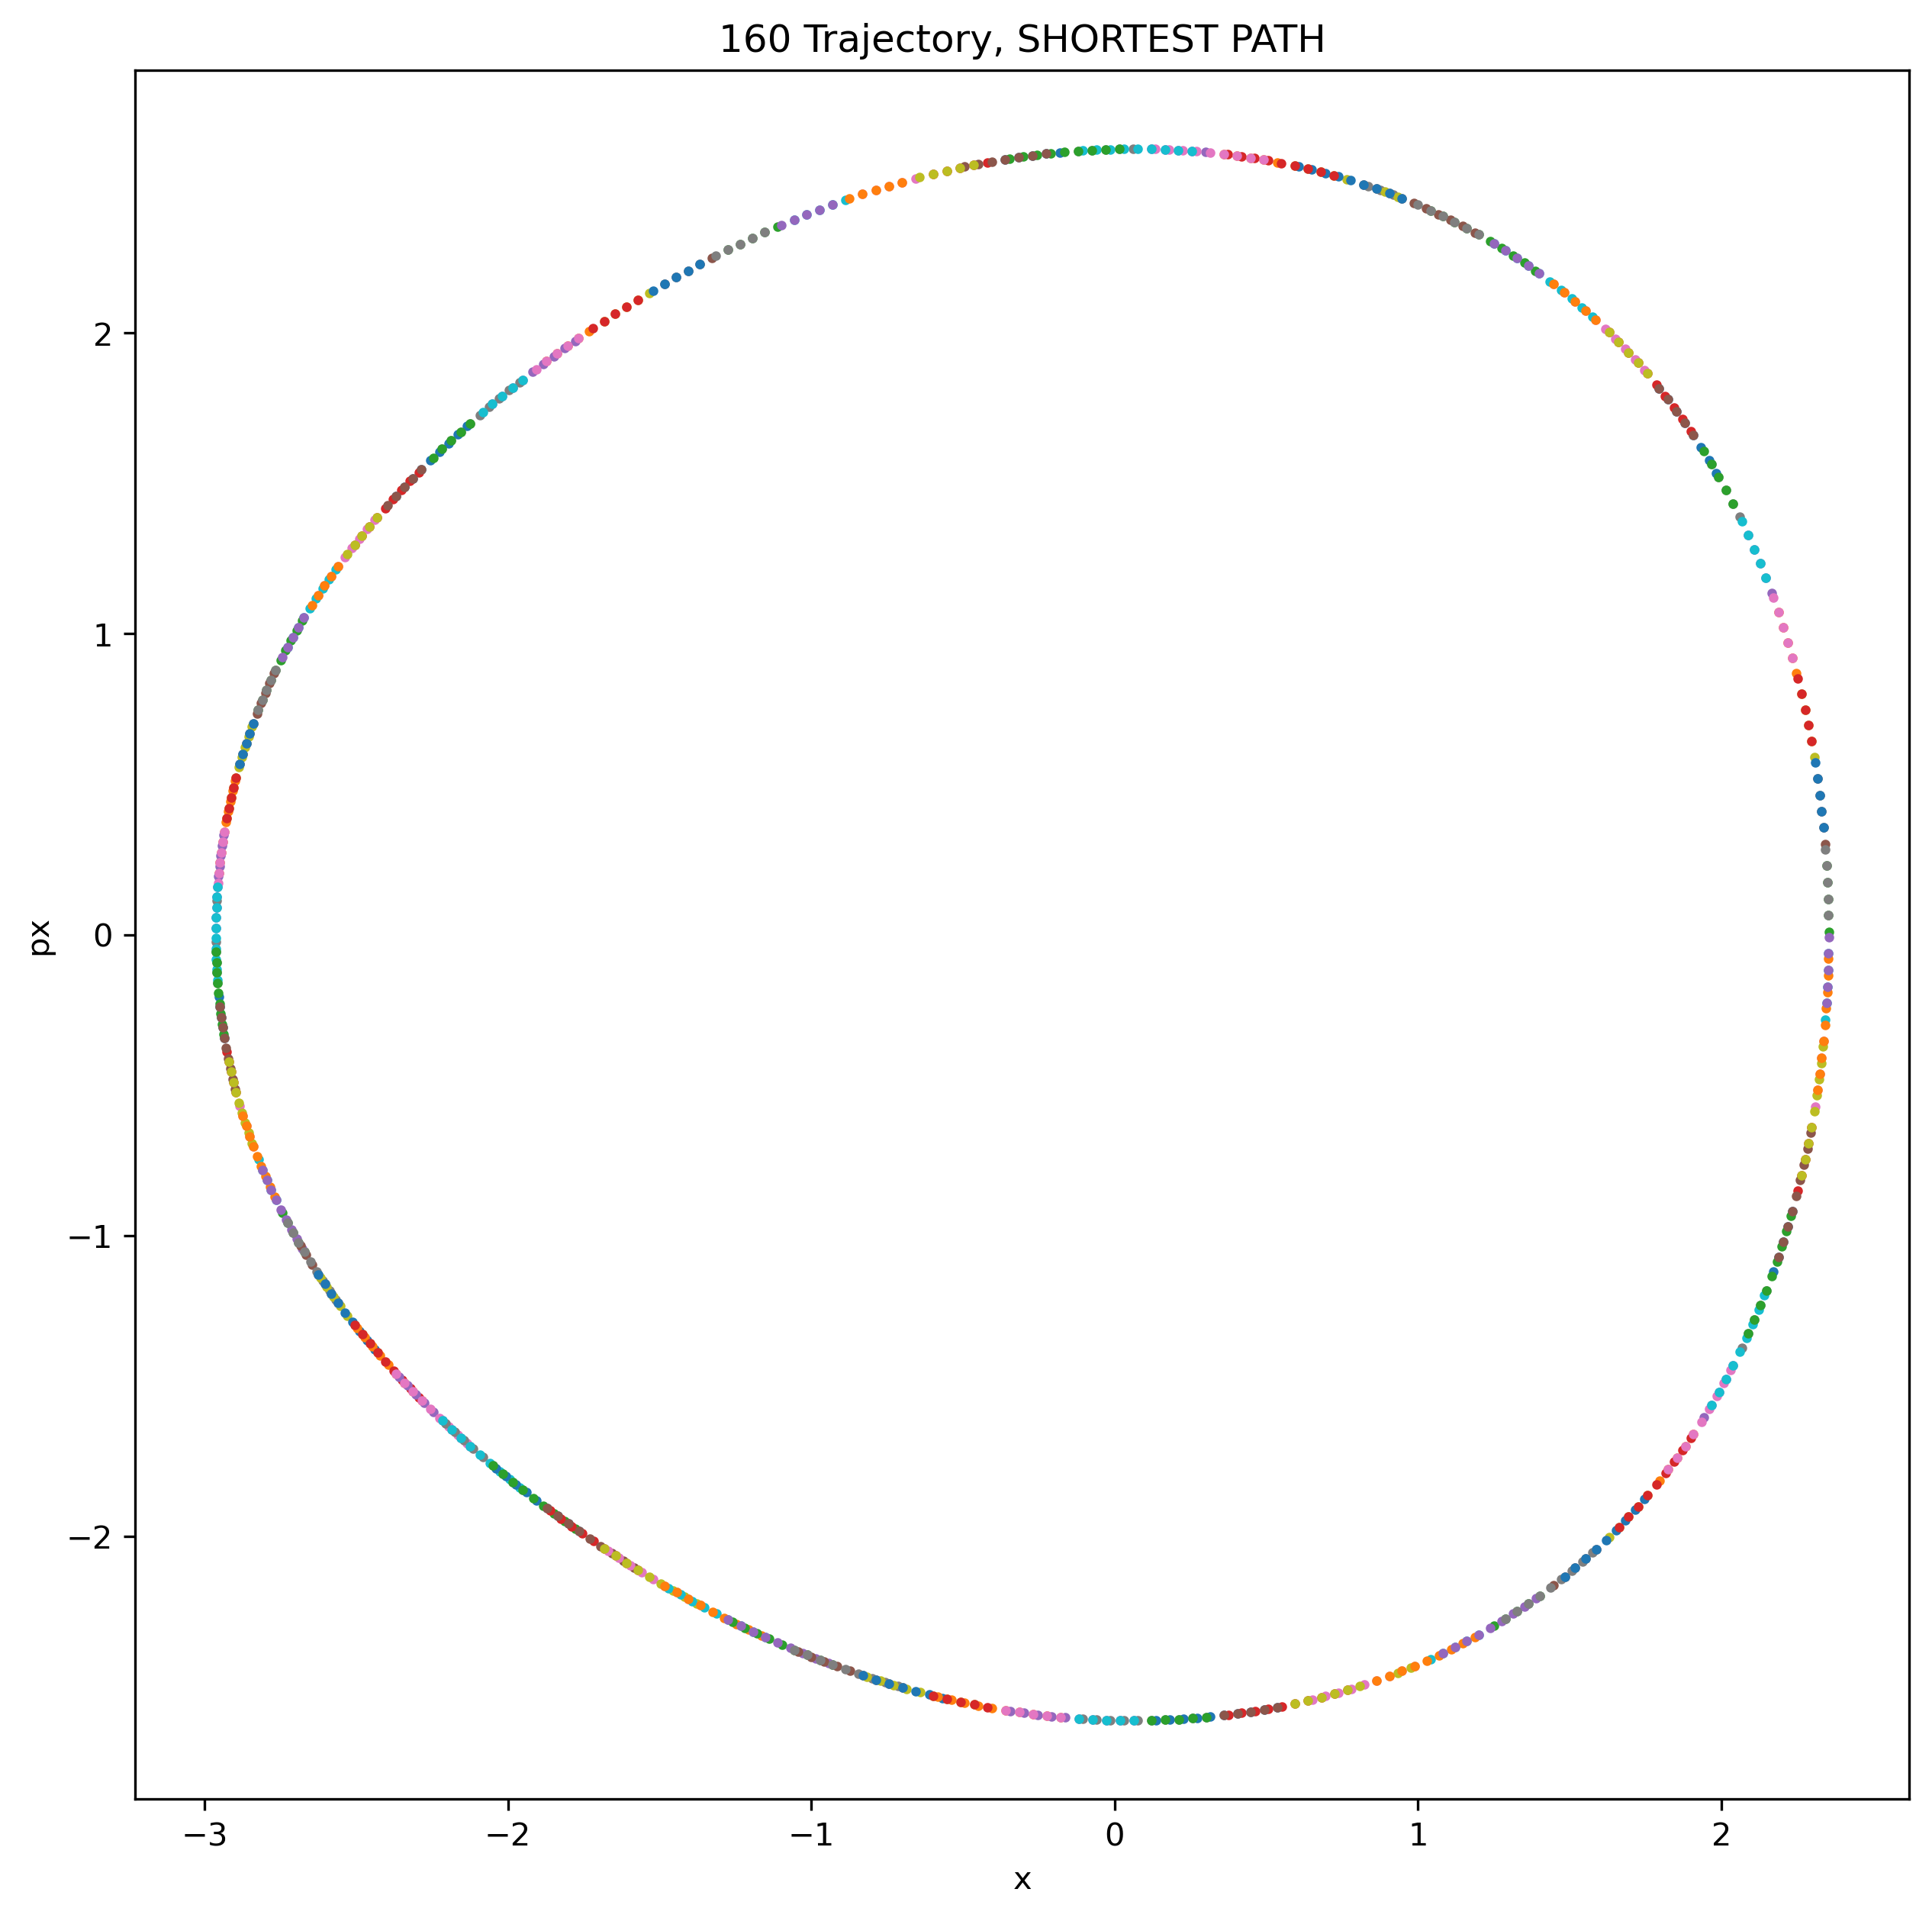

(1000, 2)
[2.02449225 2.03750913]


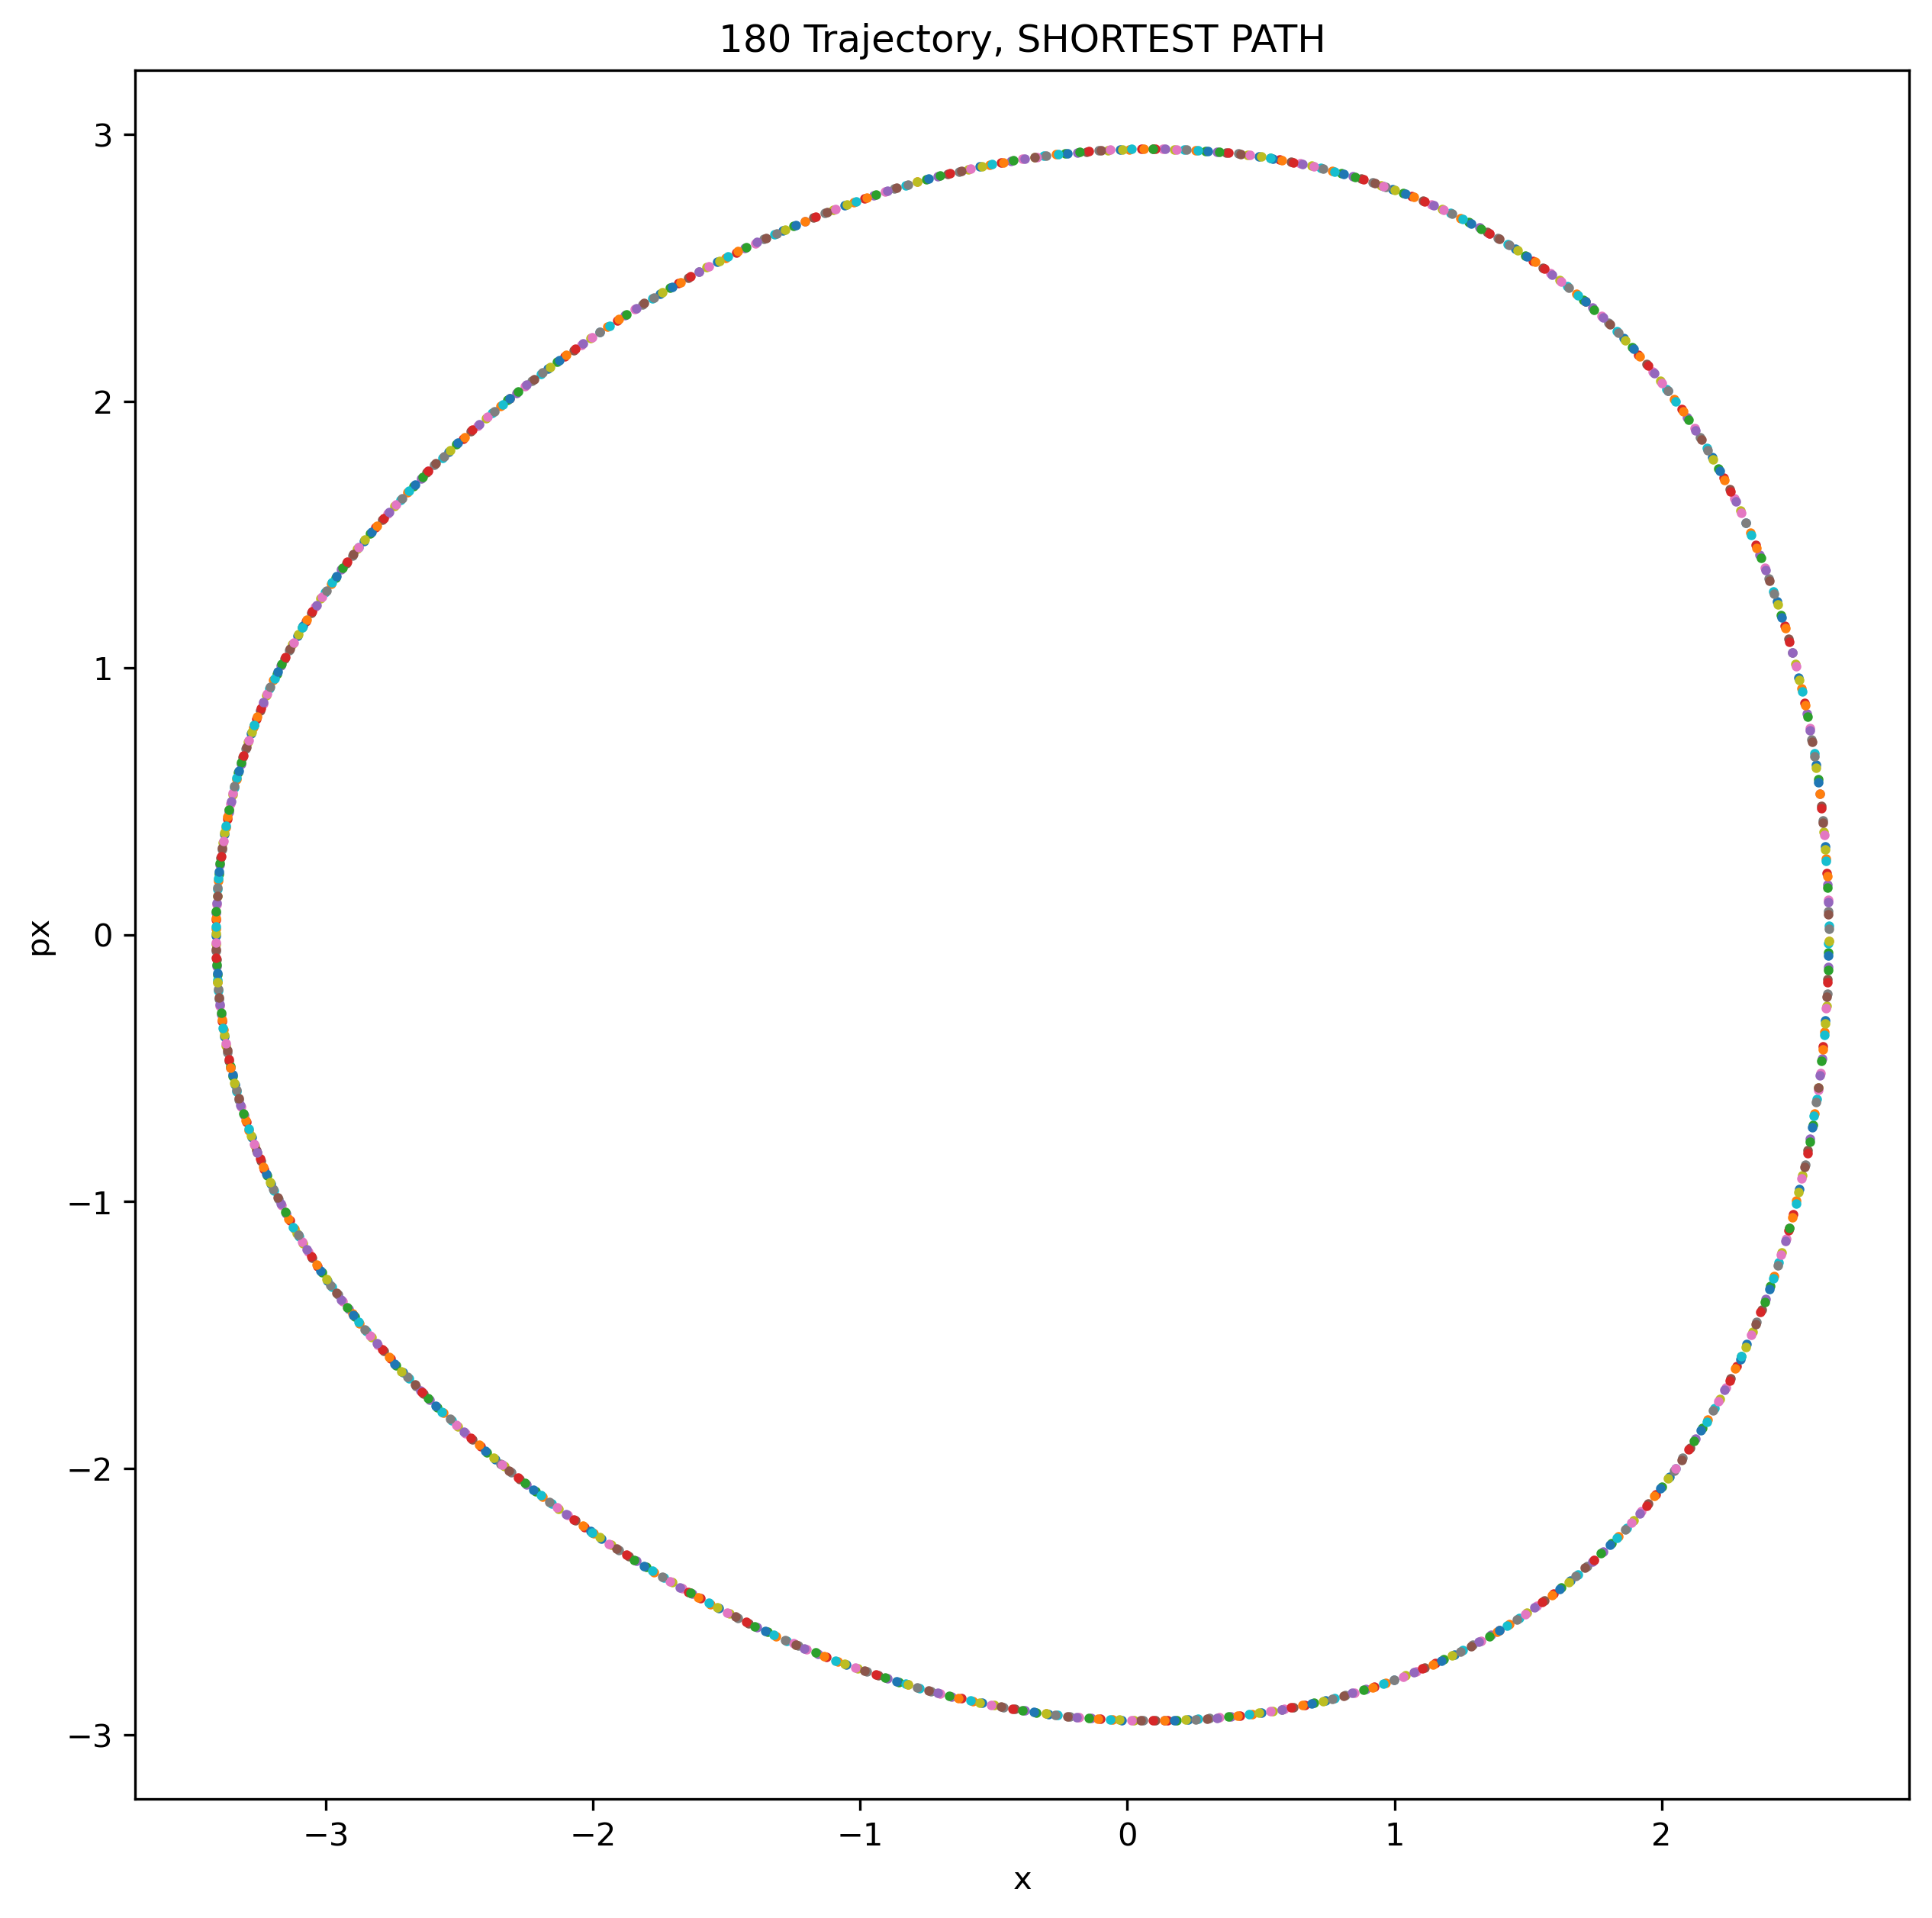

(1000, 2)
[2.24979621 2.2637344 ]


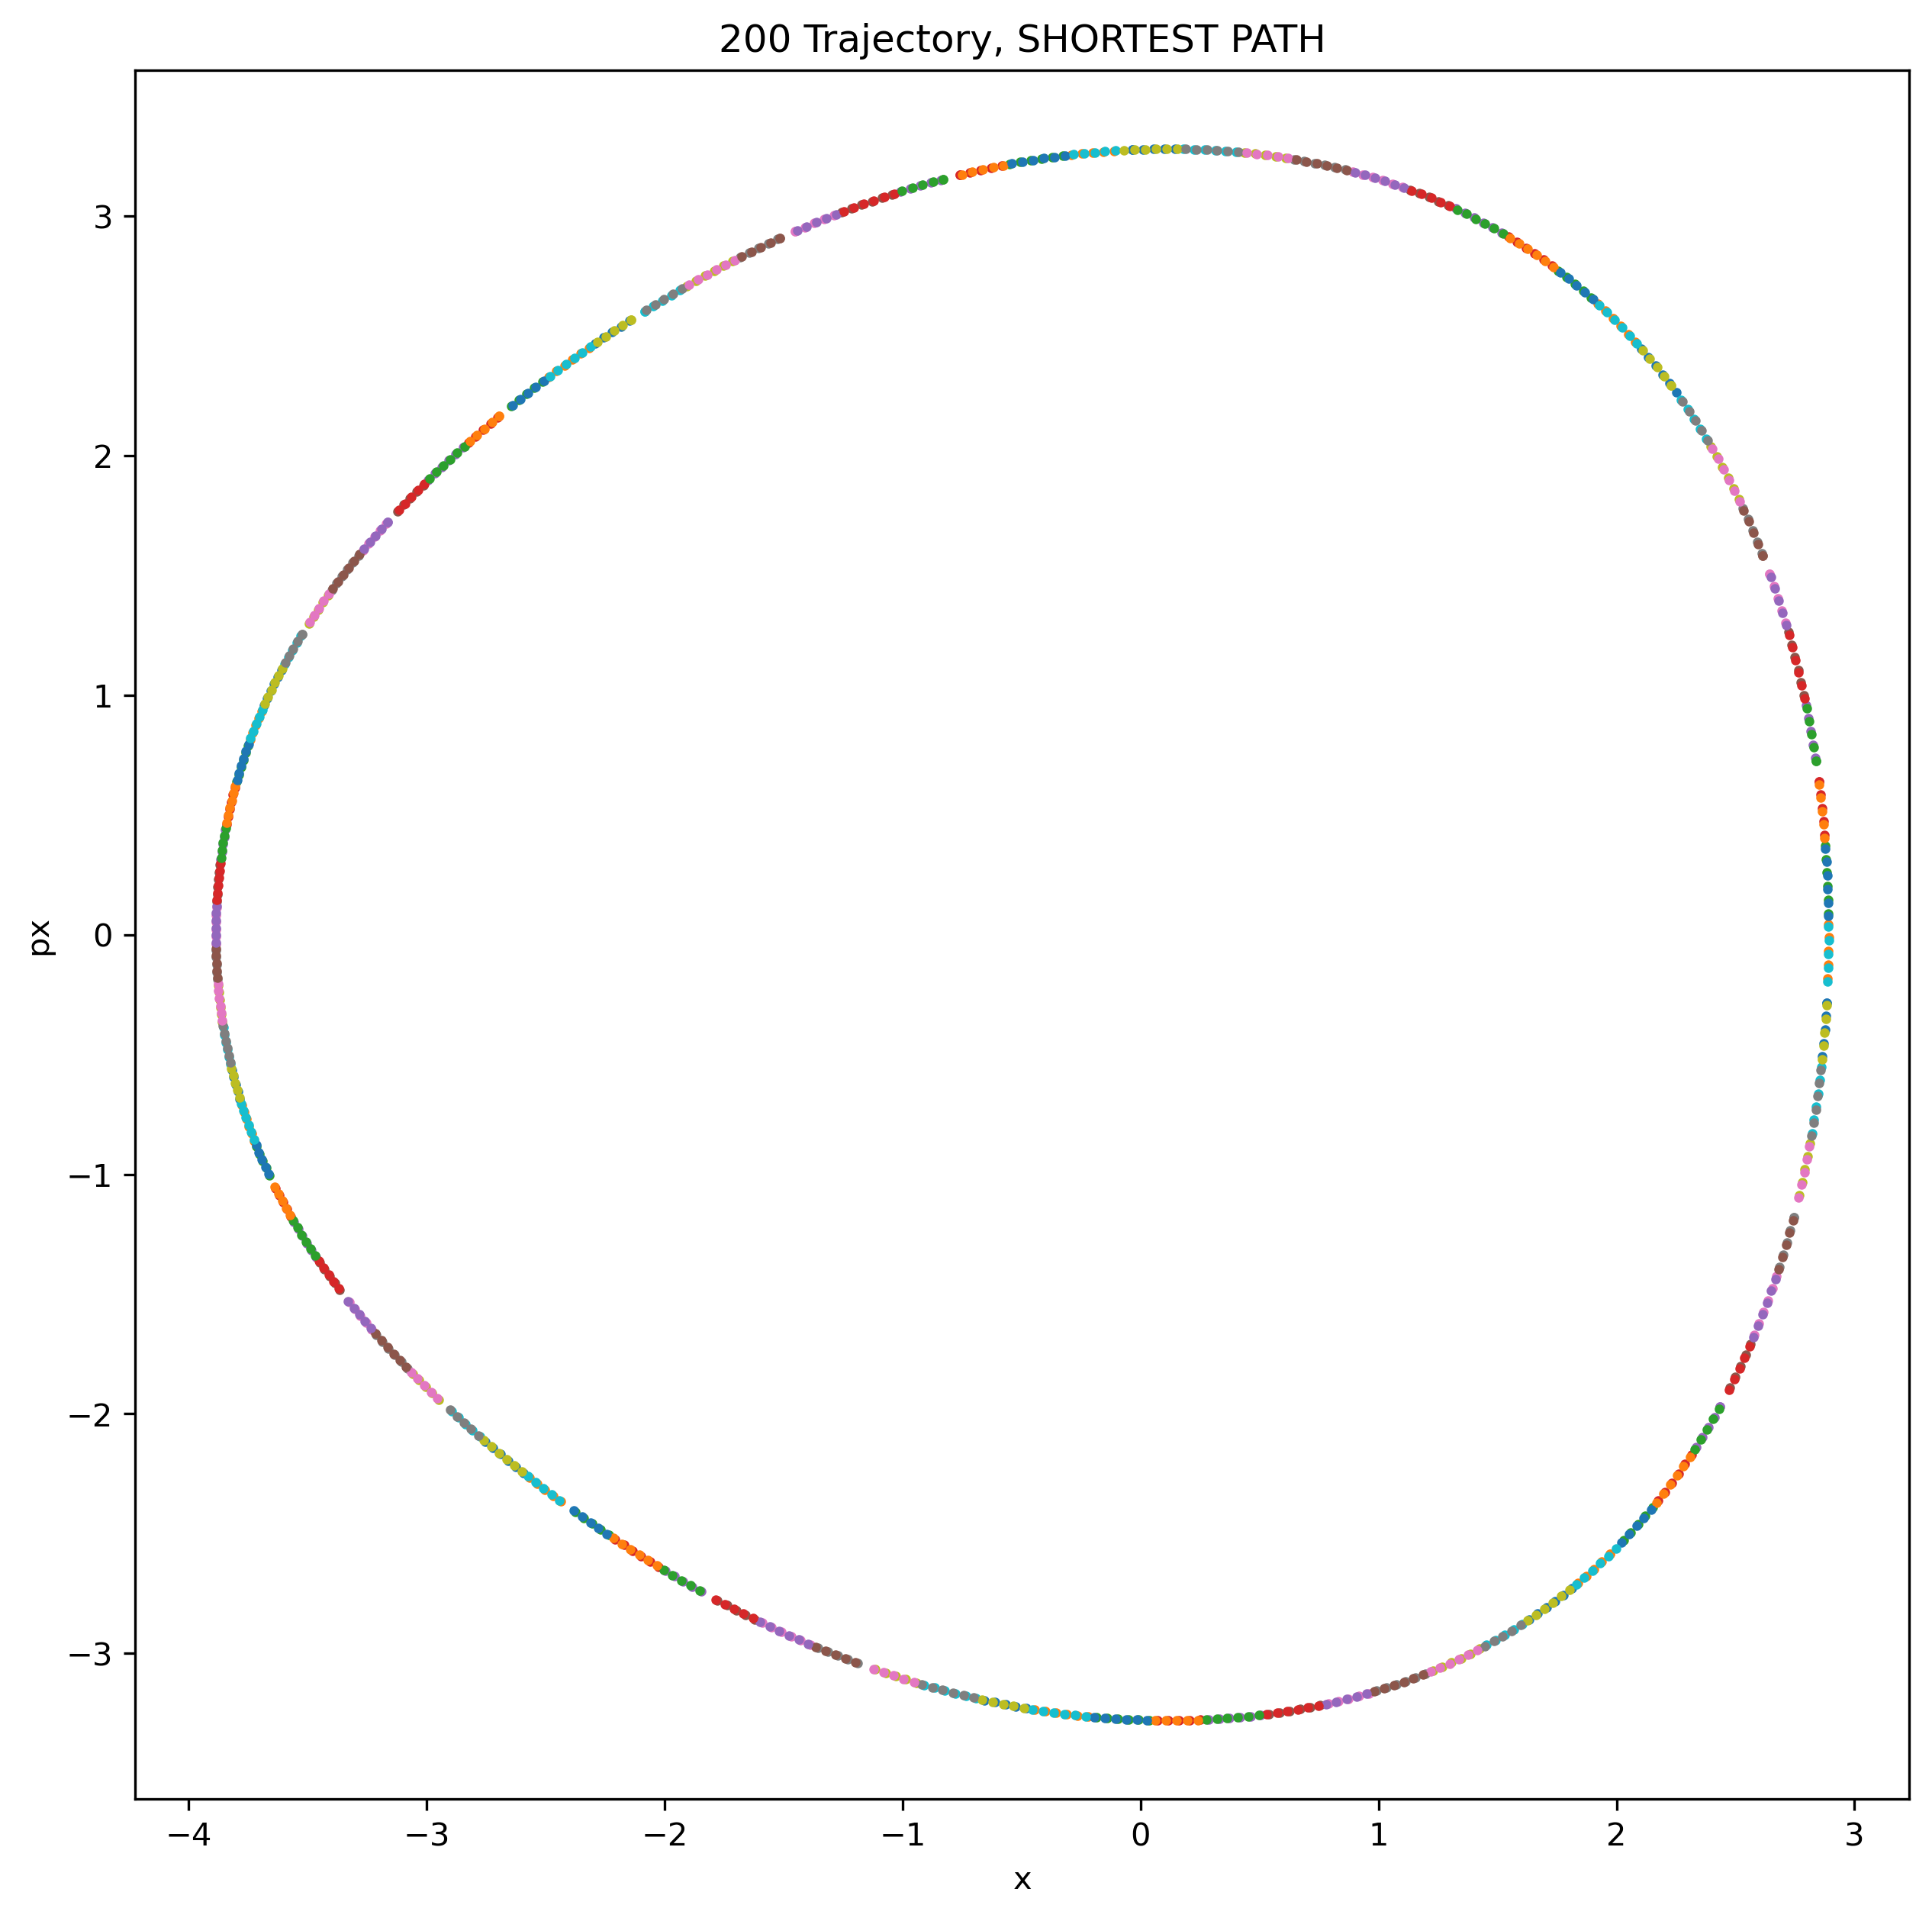

(1000, 2)
[2.48491834 2.47580468]


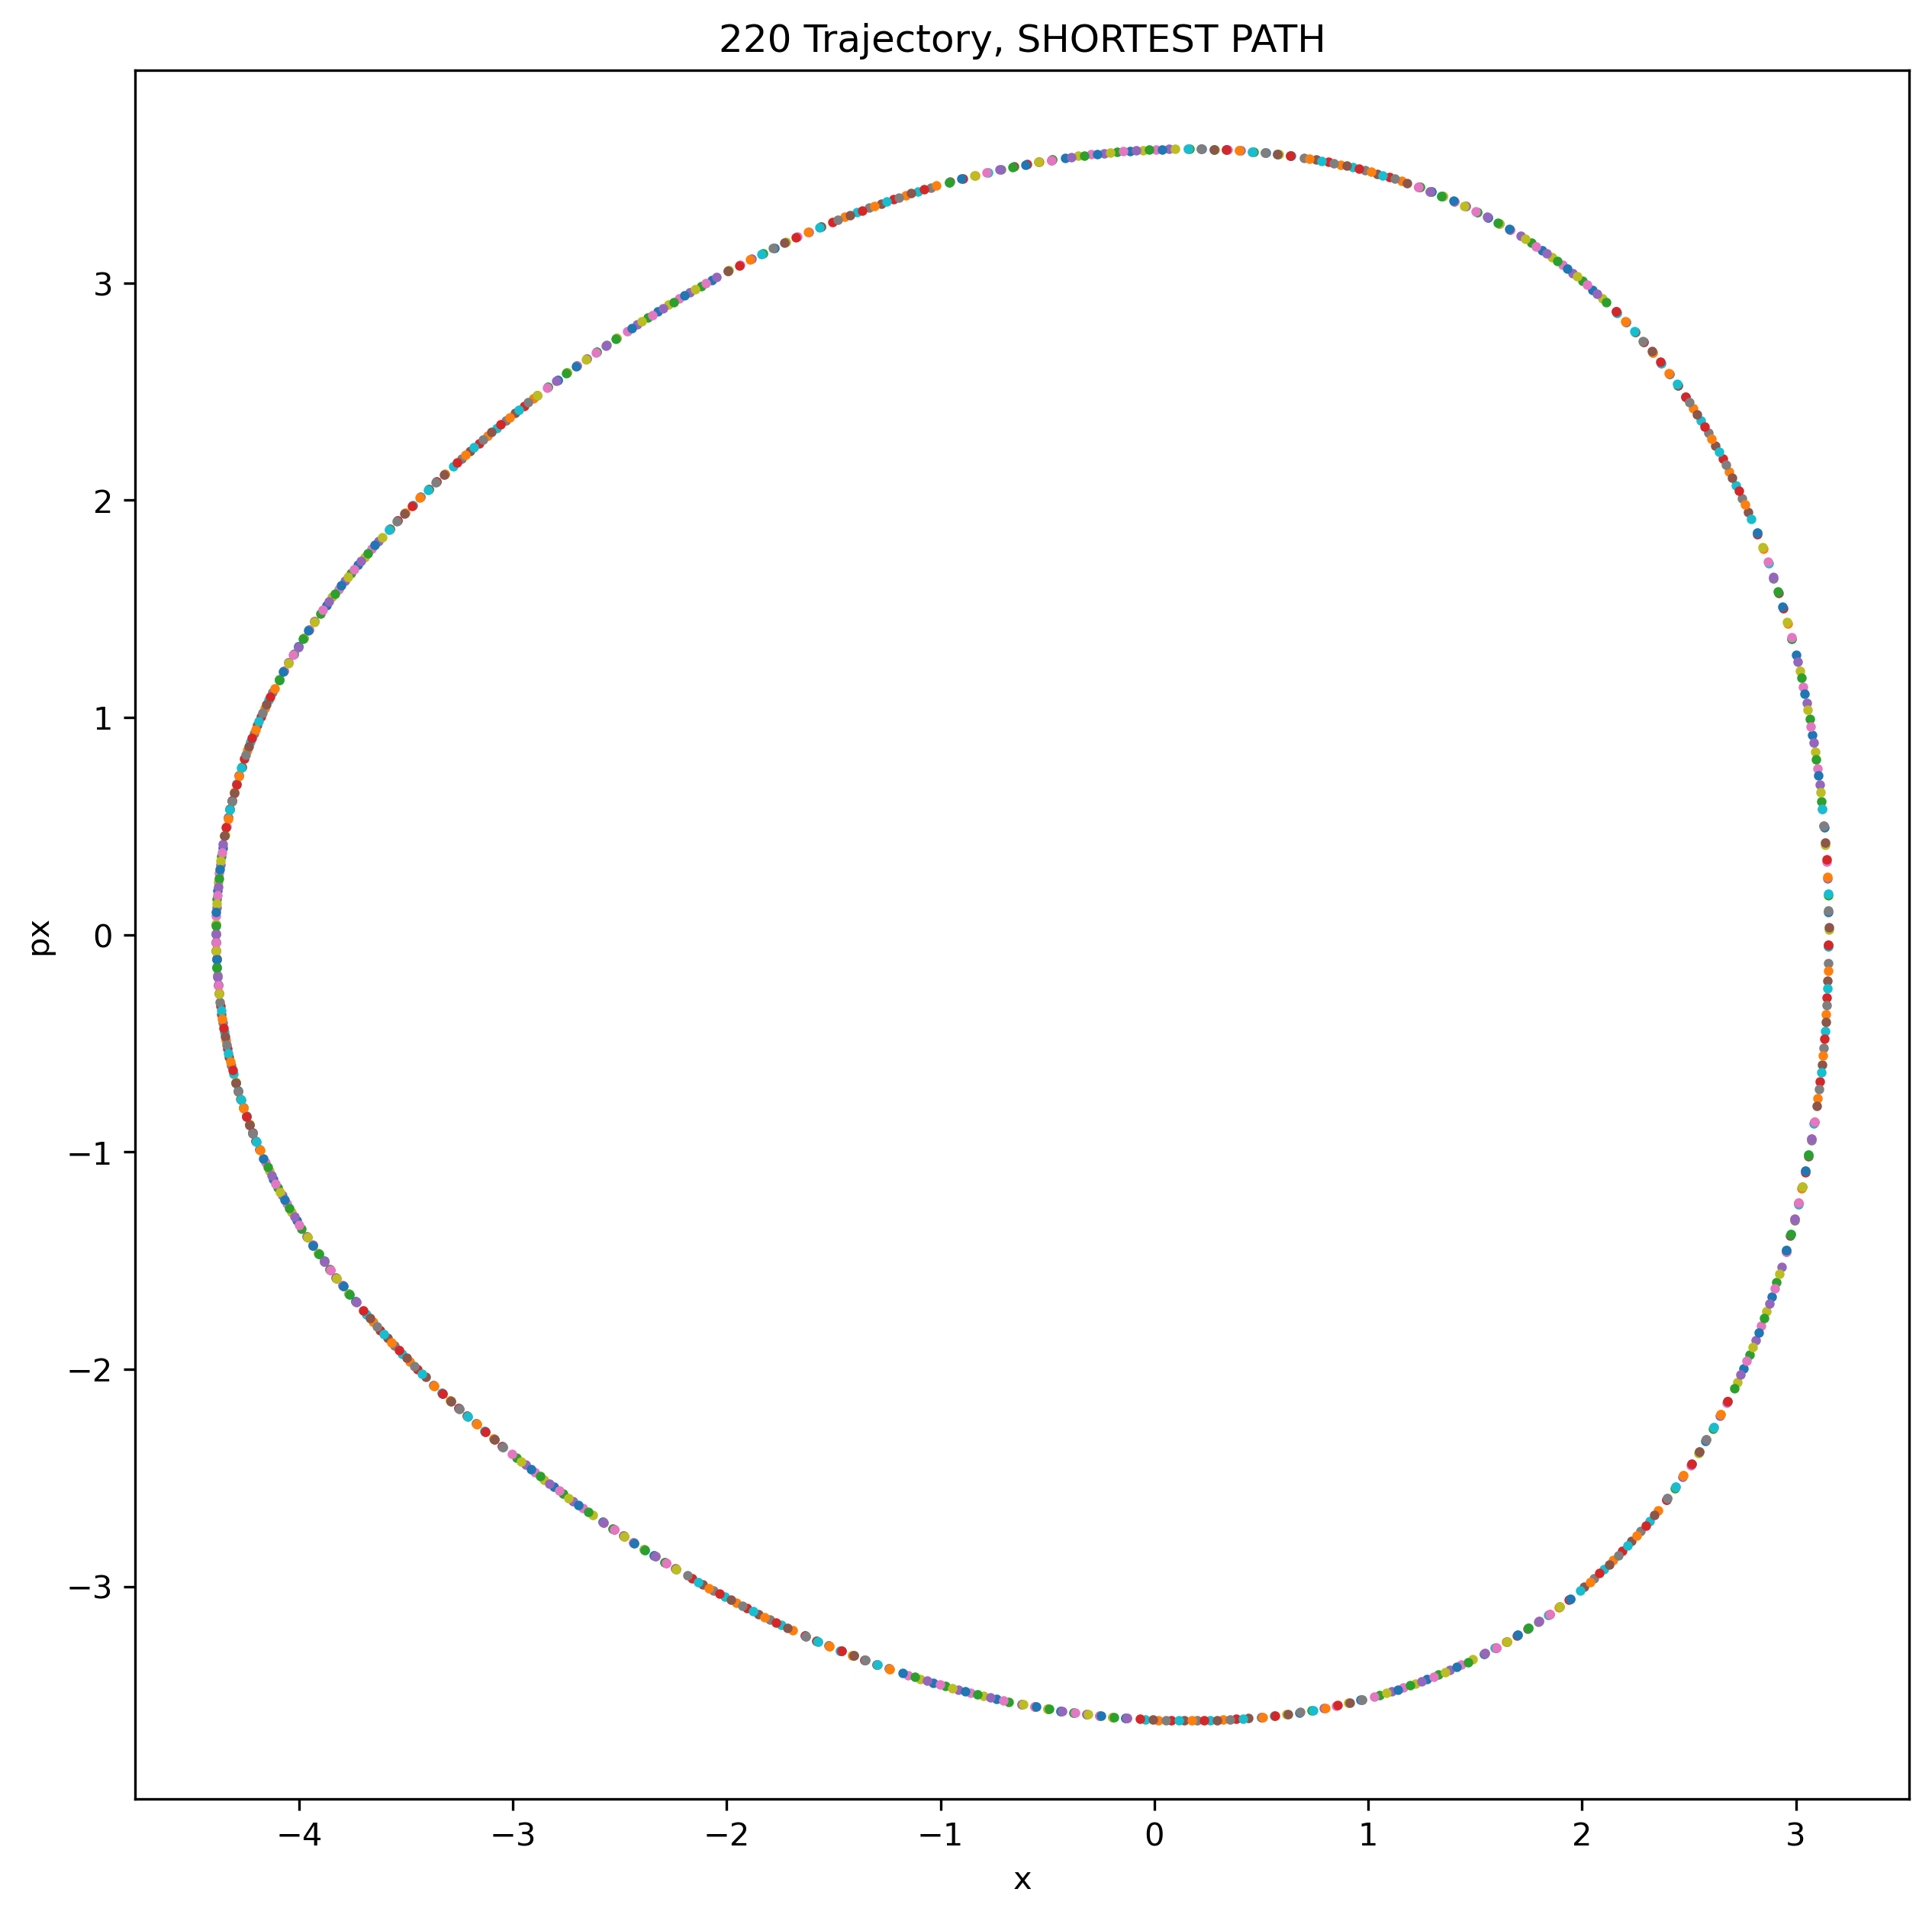

(1000, 2)
[2.70717582 2.70614813]


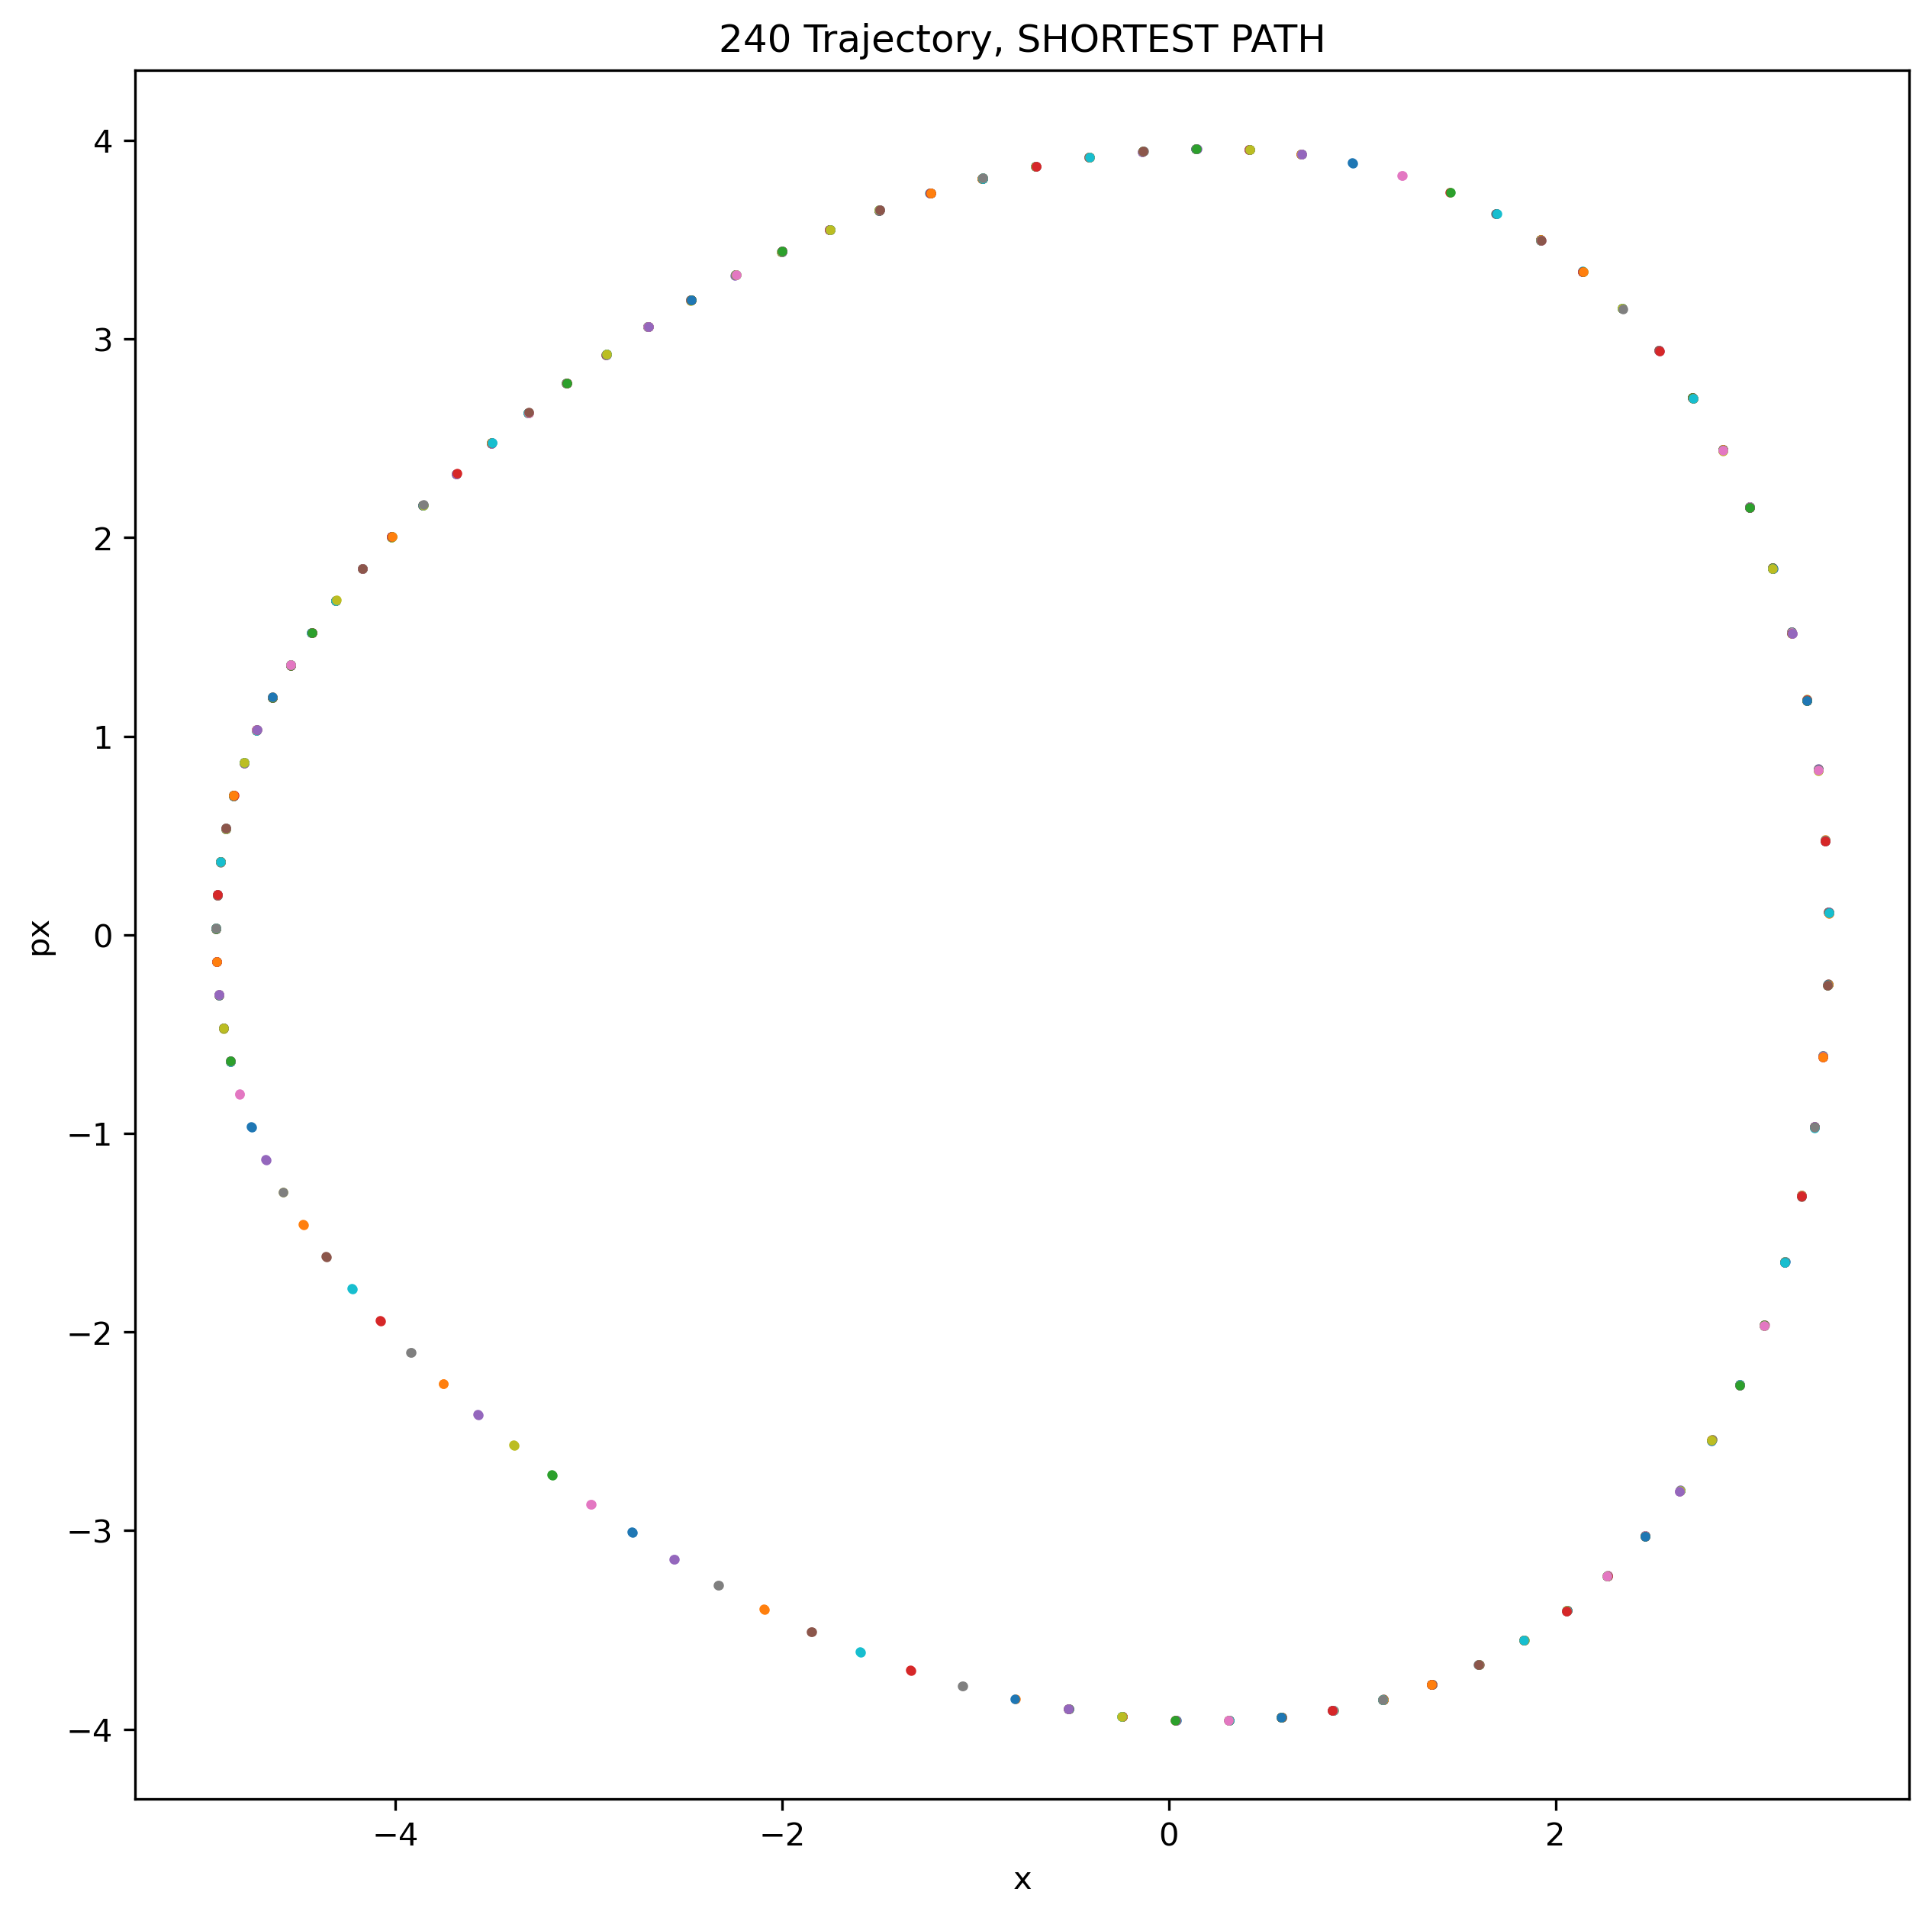

(1000, 2)
[2.93642629 2.92585524]


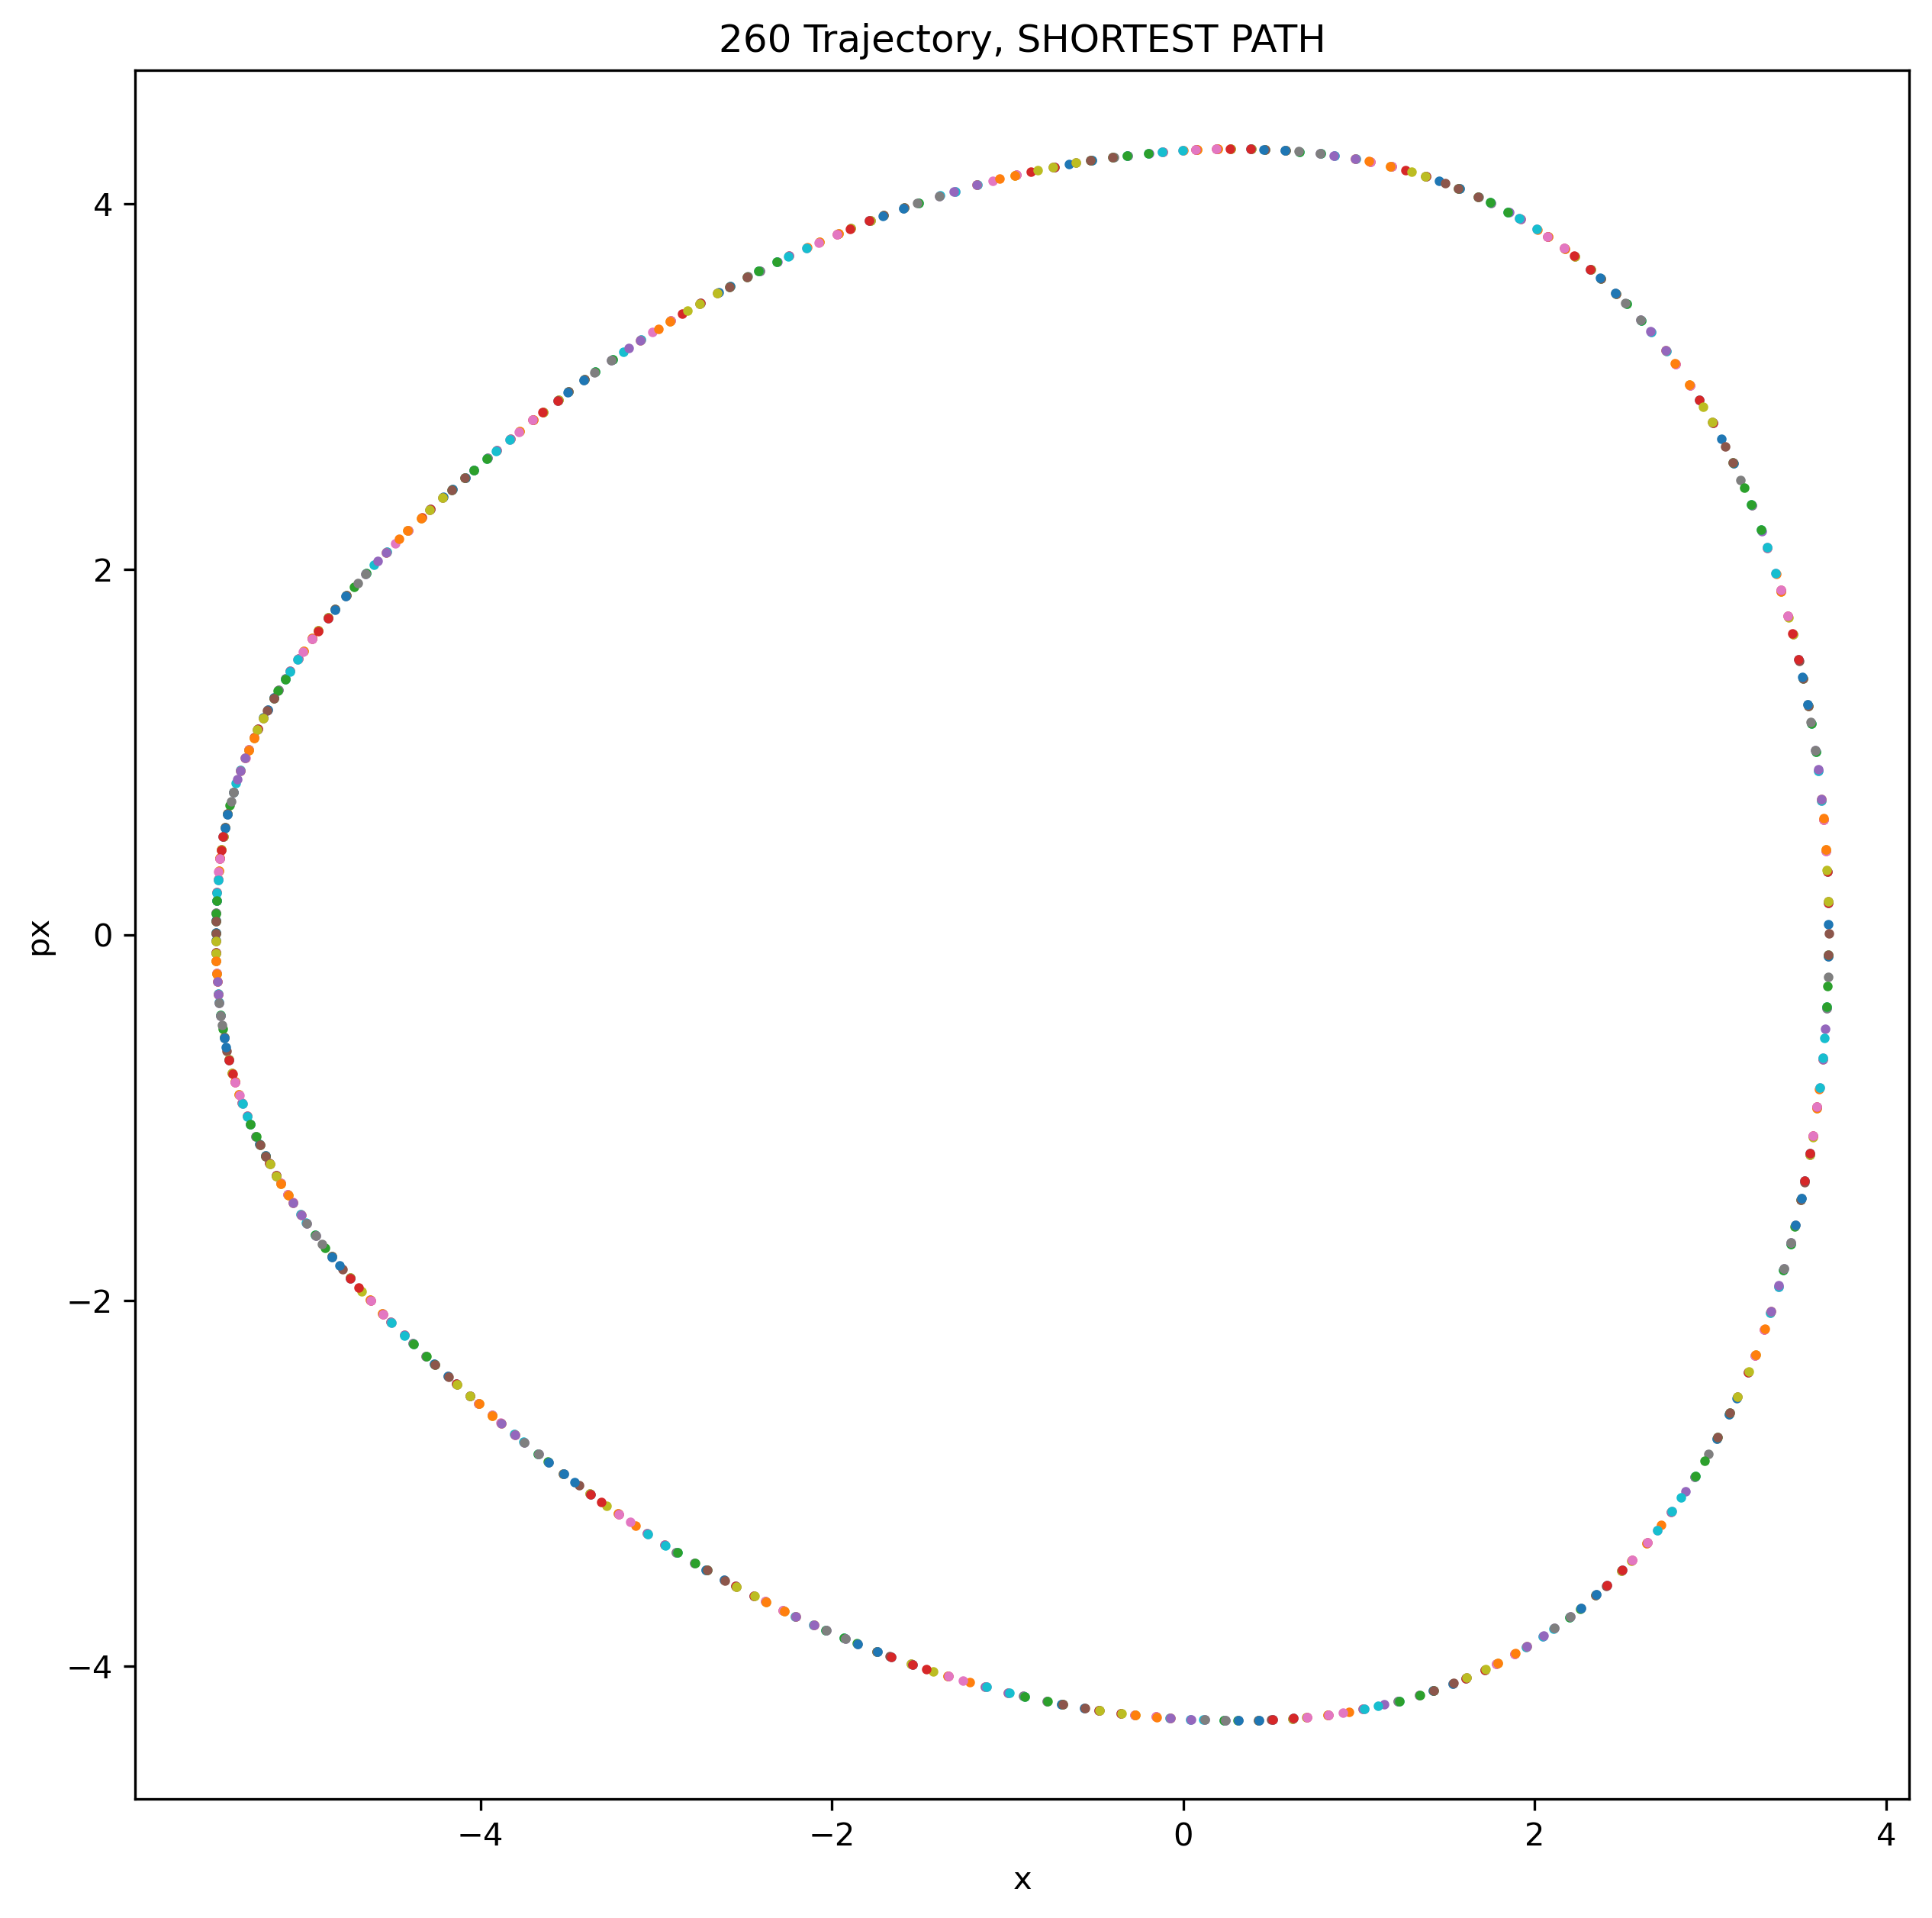

(1000, 2)
[3.14111747 3.18536913]


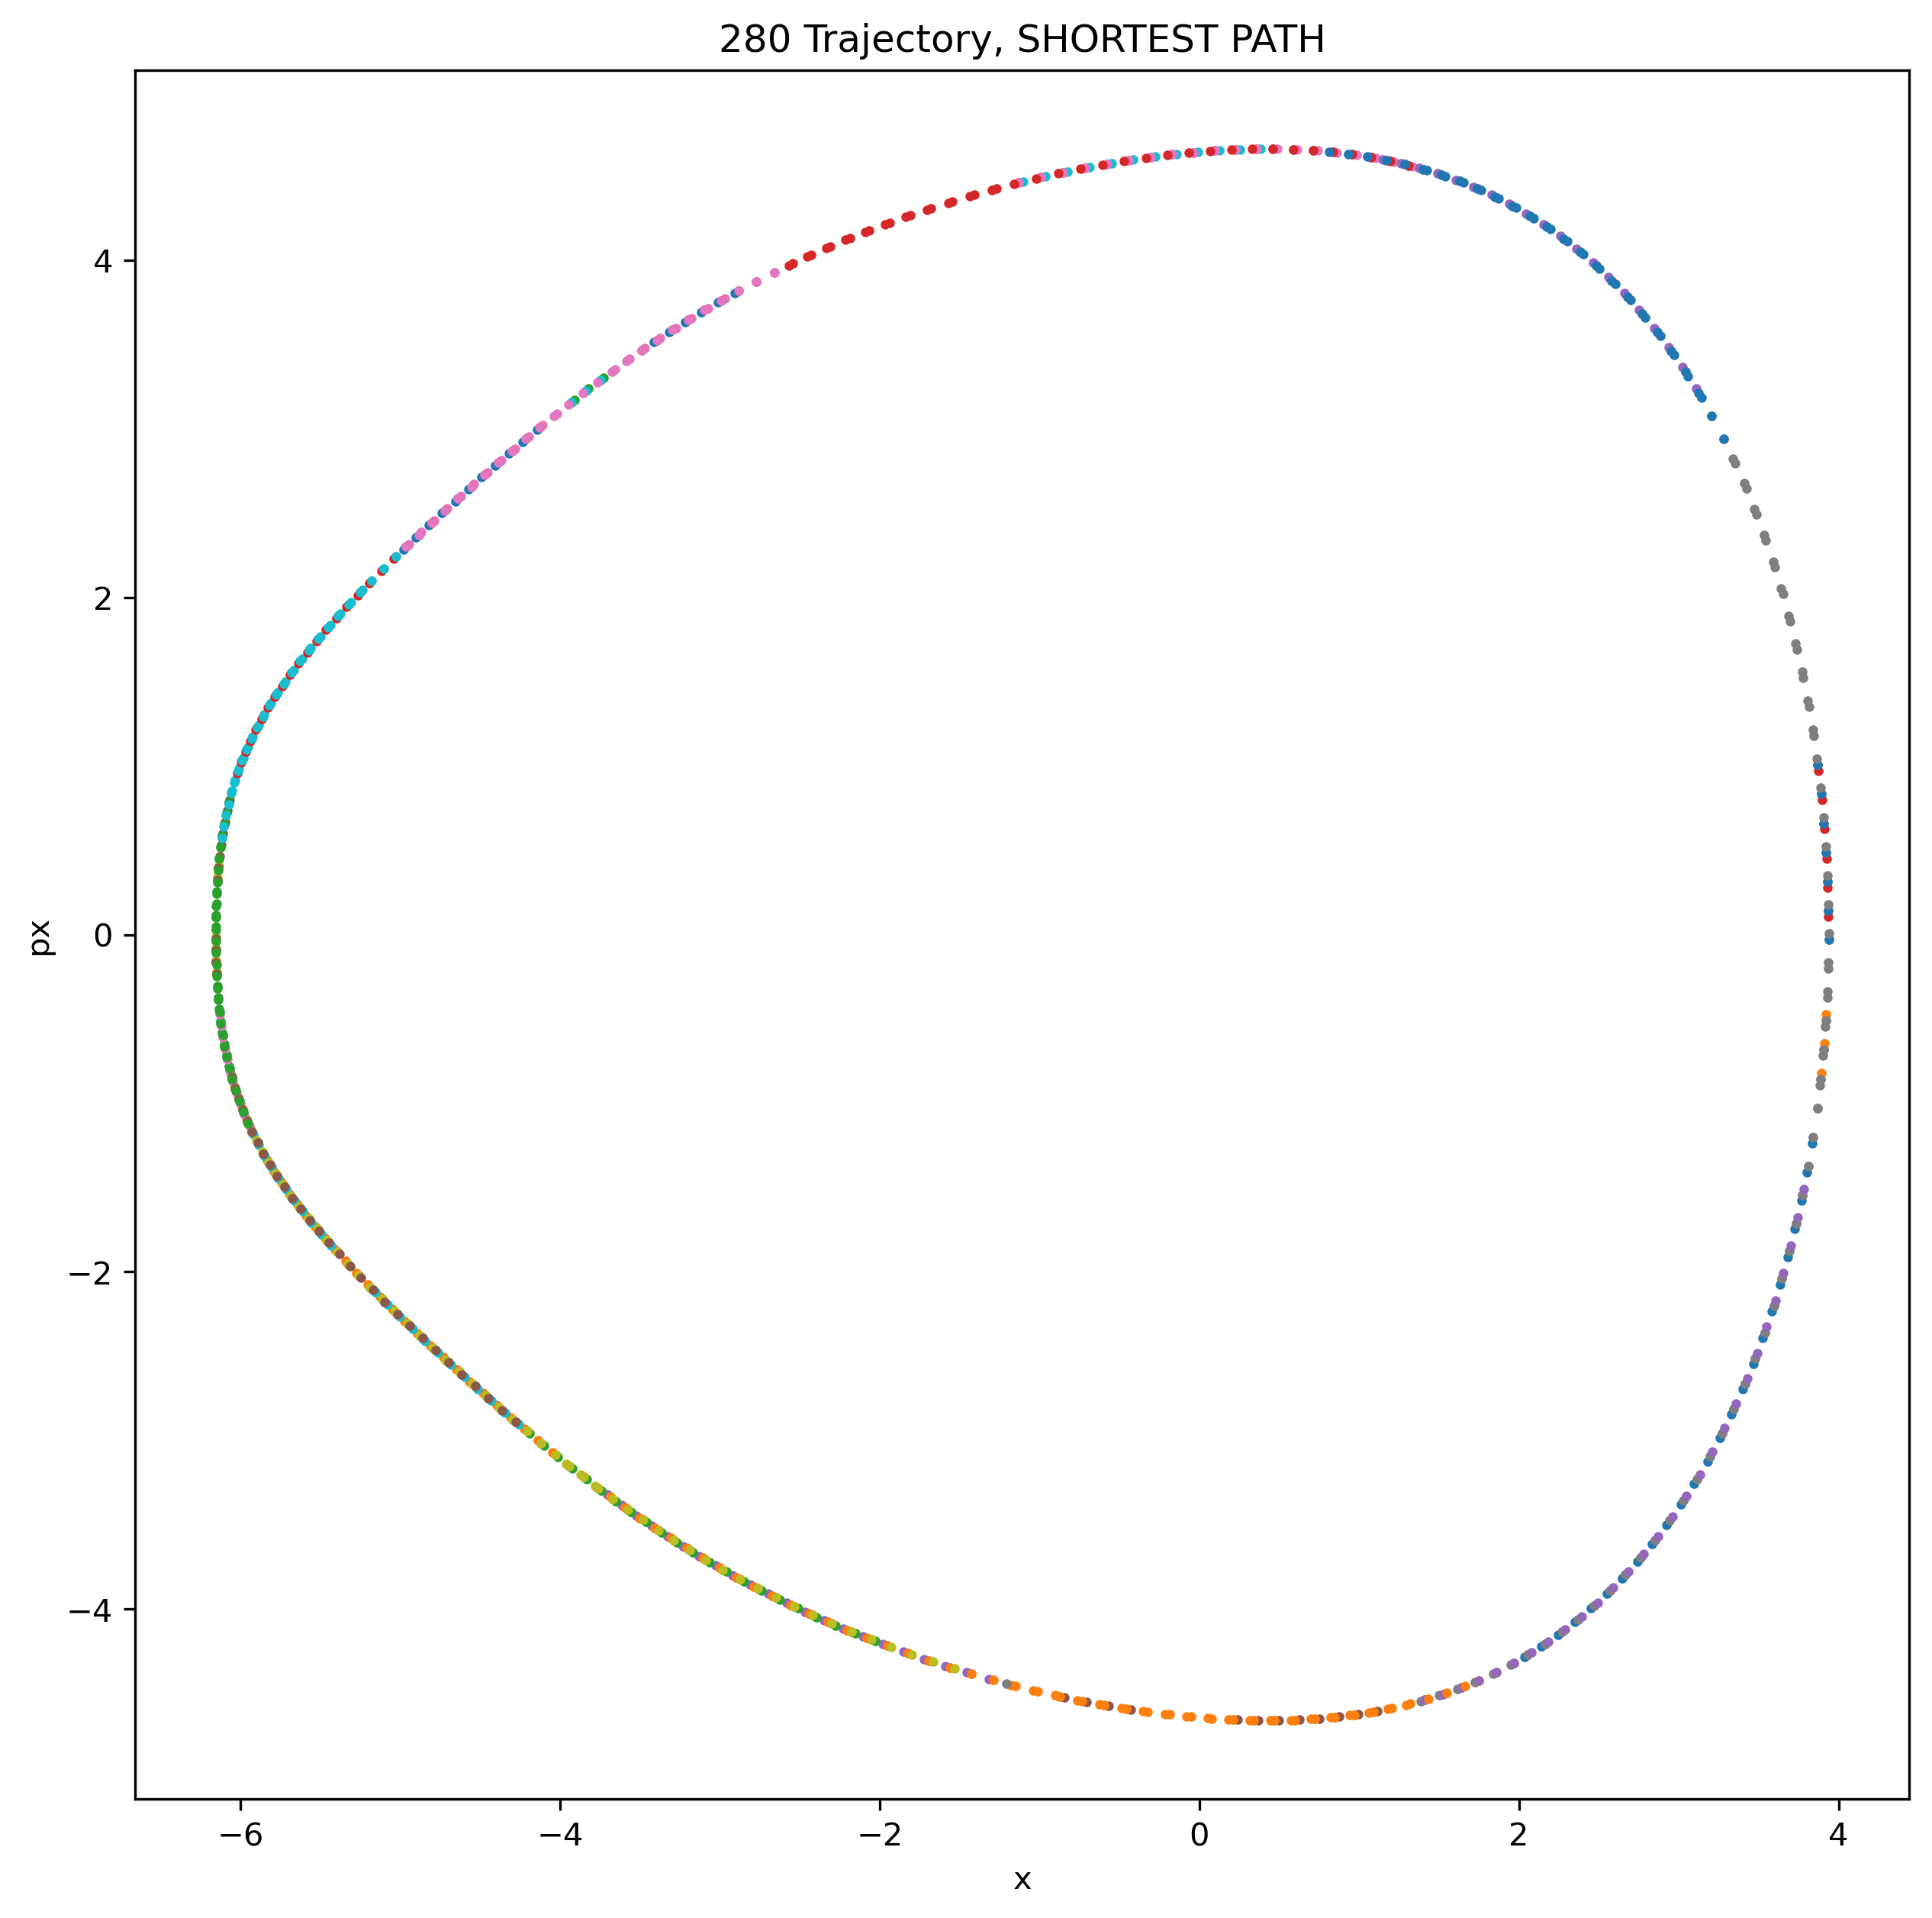

(1000, 2)
[3.40861826 3.33970224]


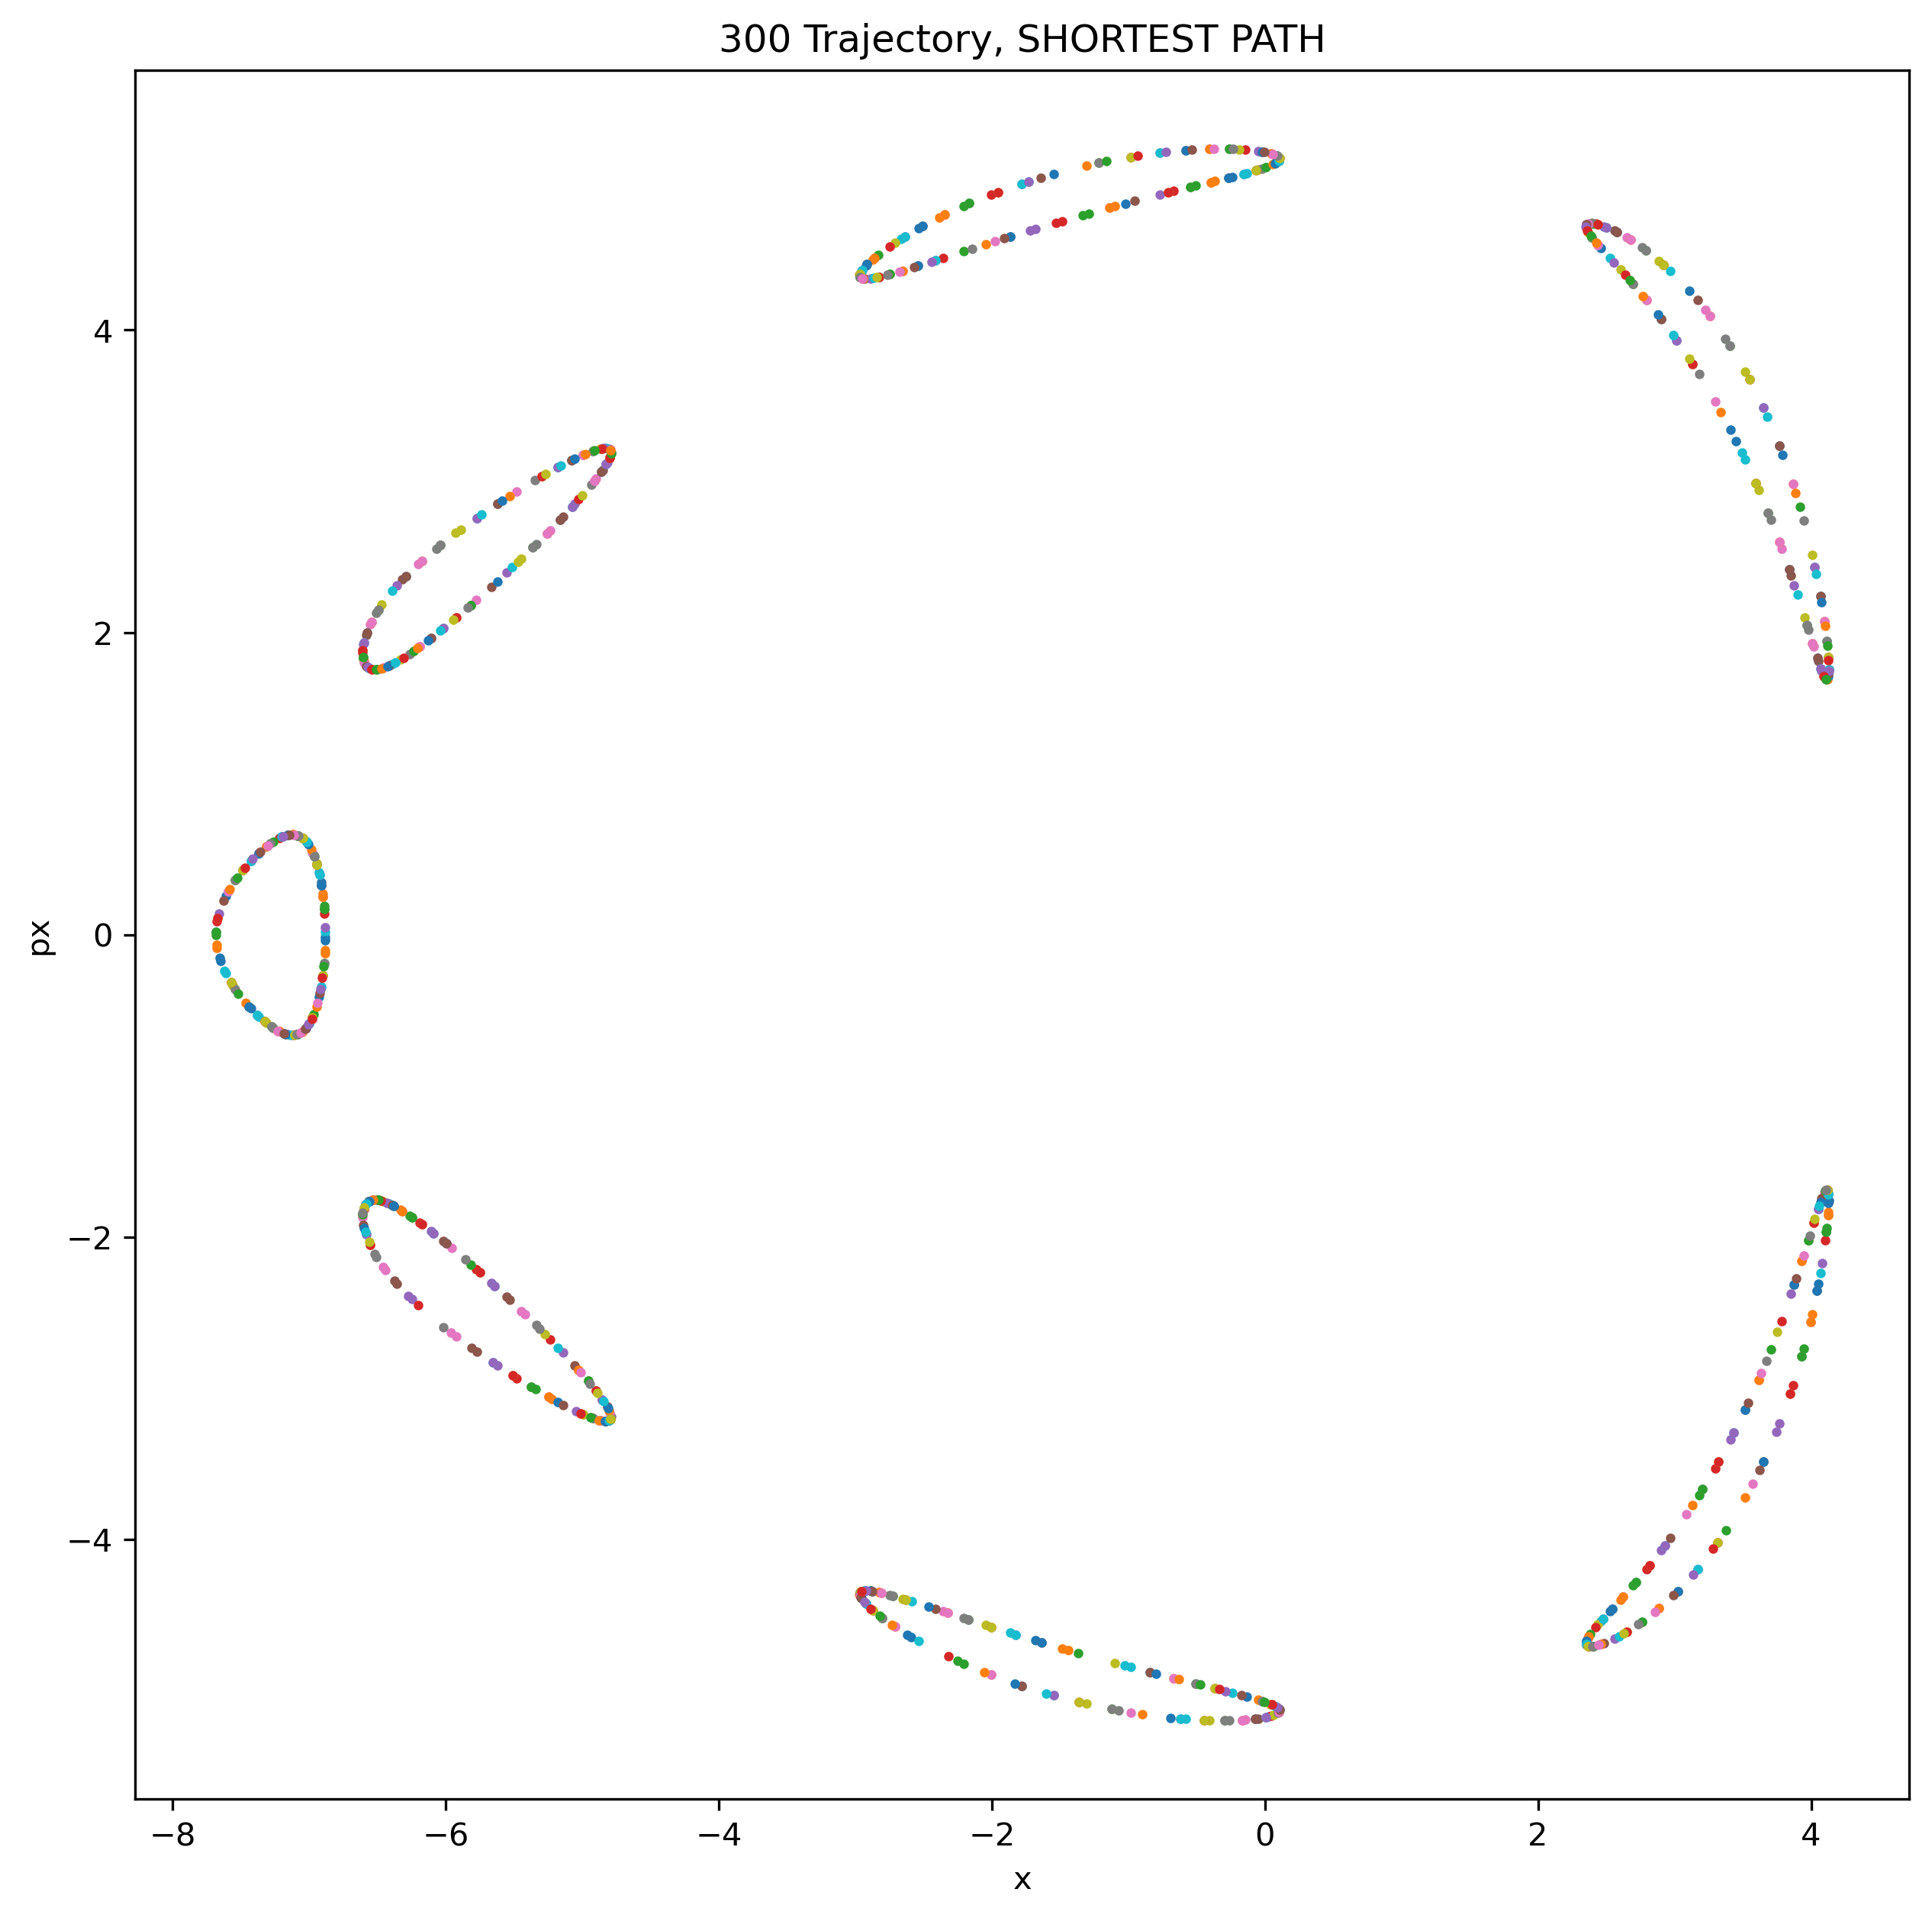

(1000, 2)
[3.59921962 3.62683407]


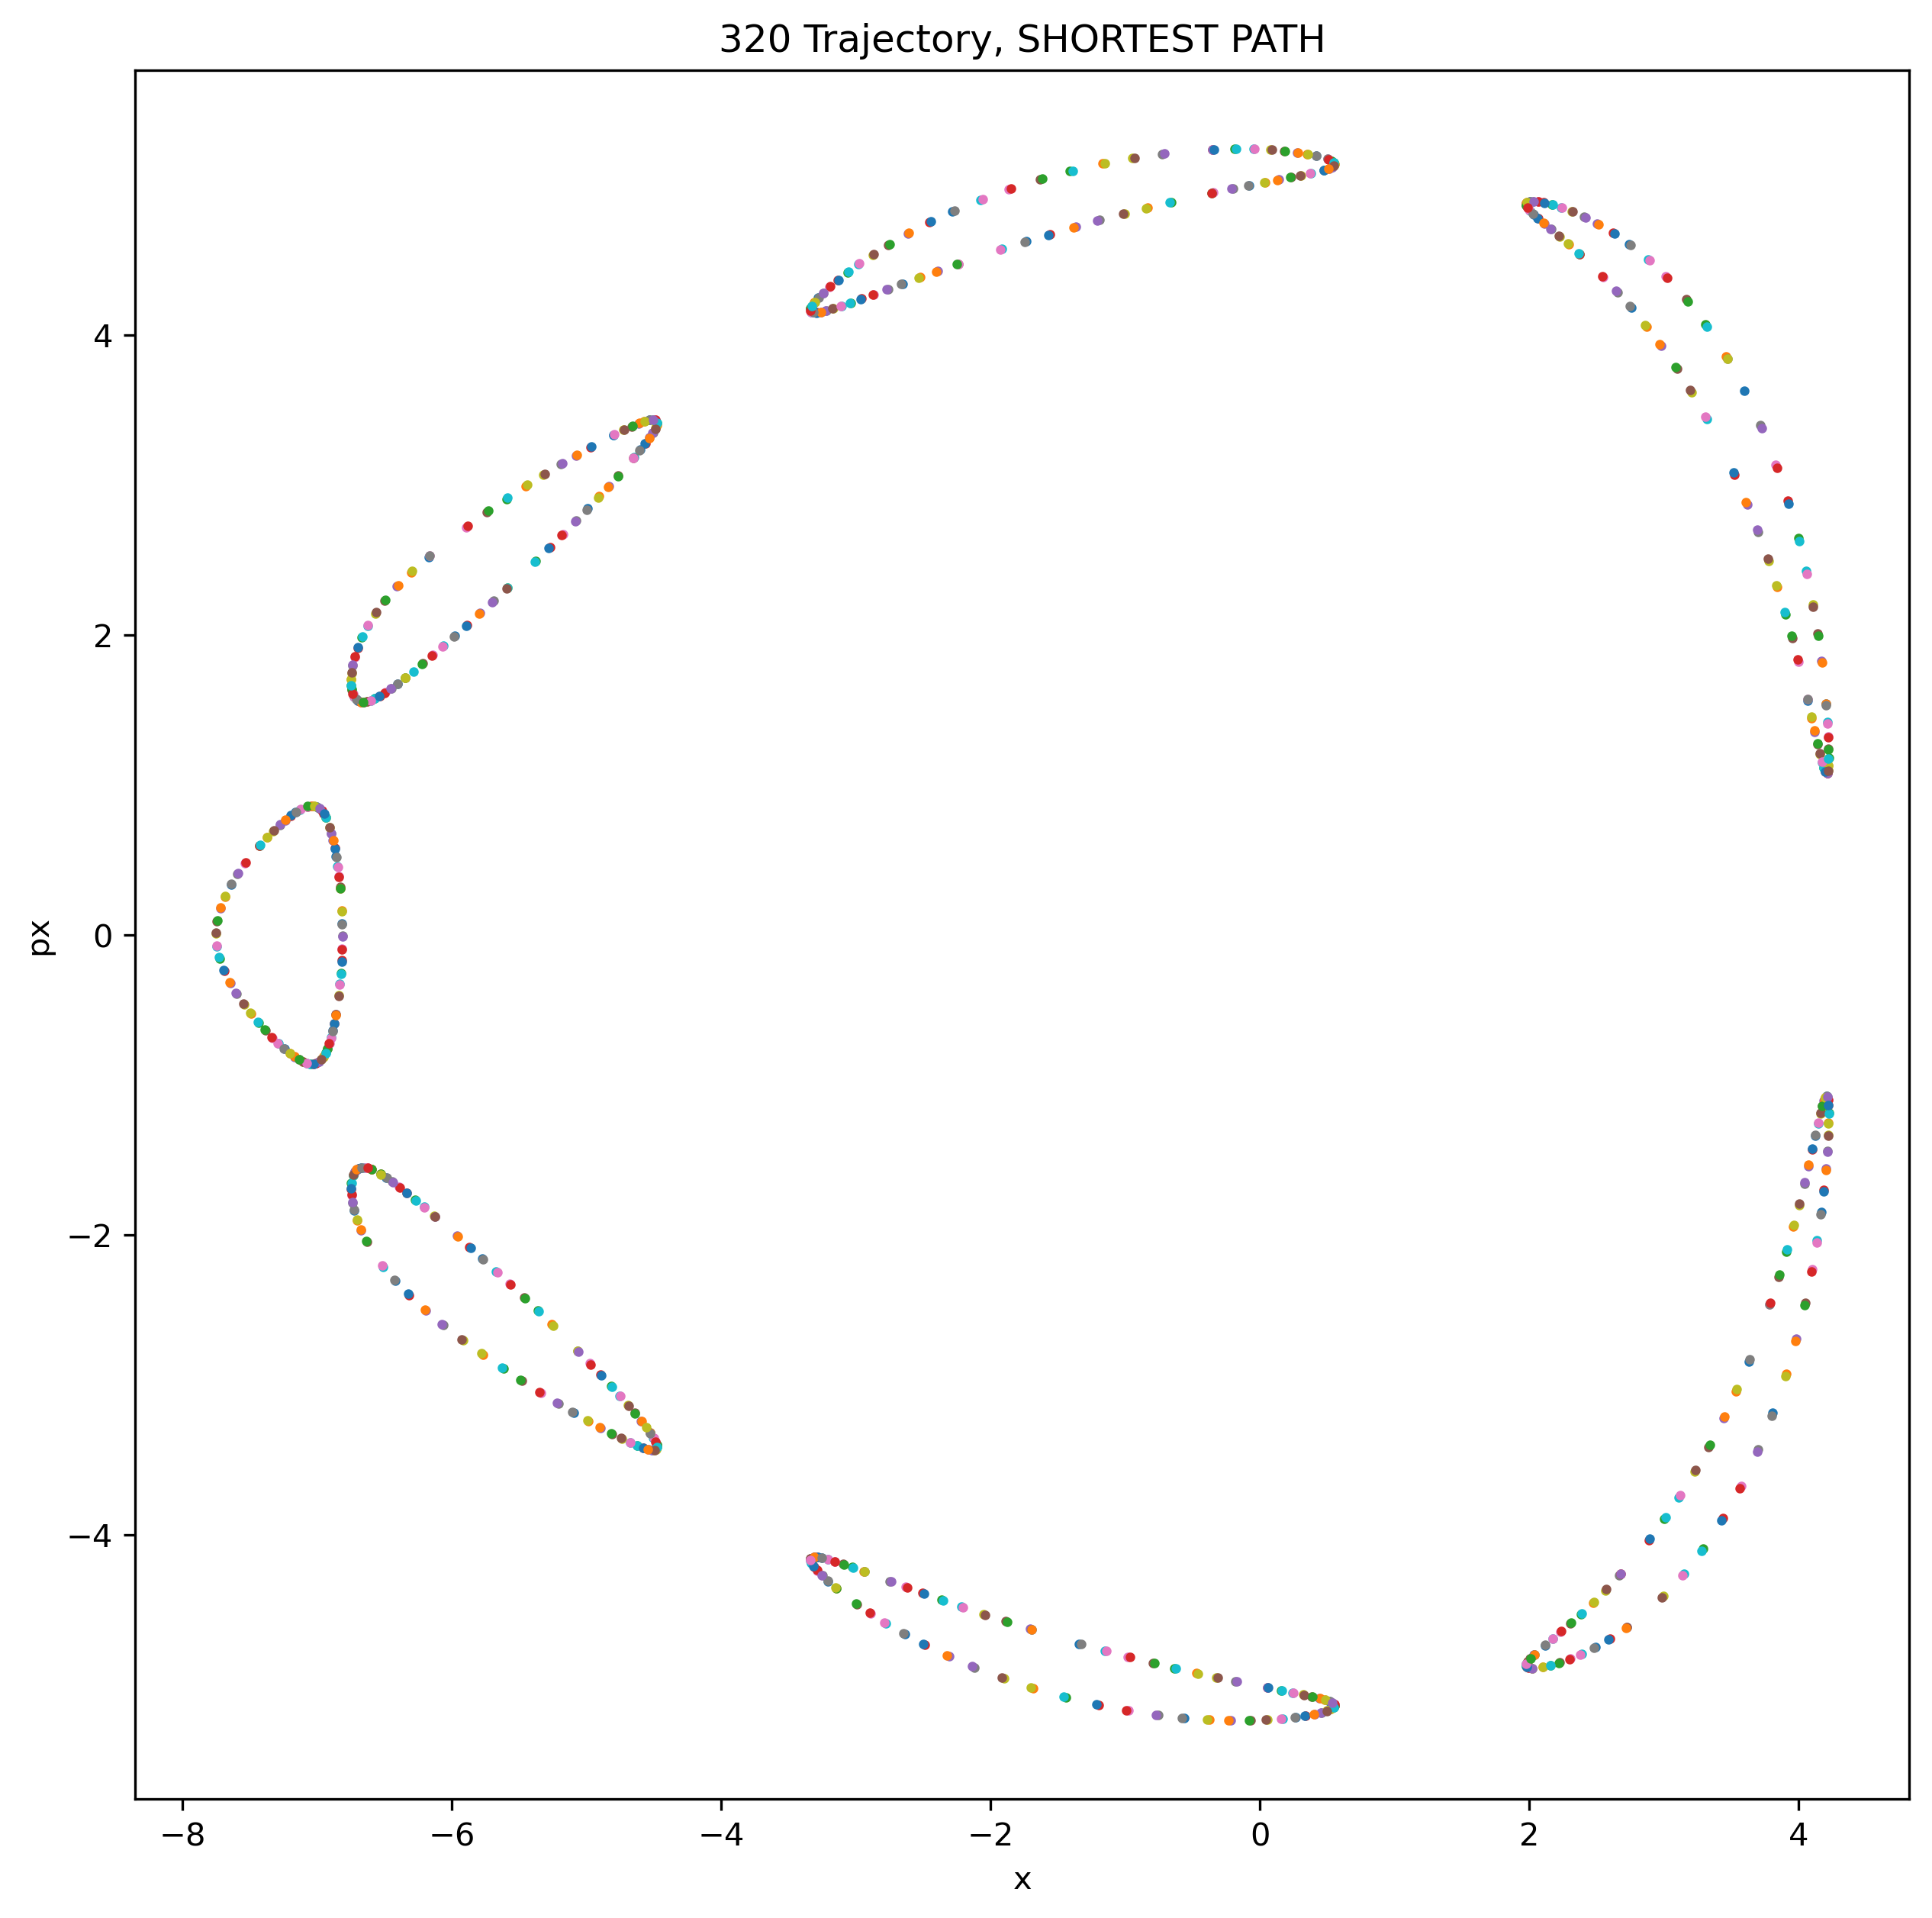

(1000, 2)
[3.8557763  3.79341804]


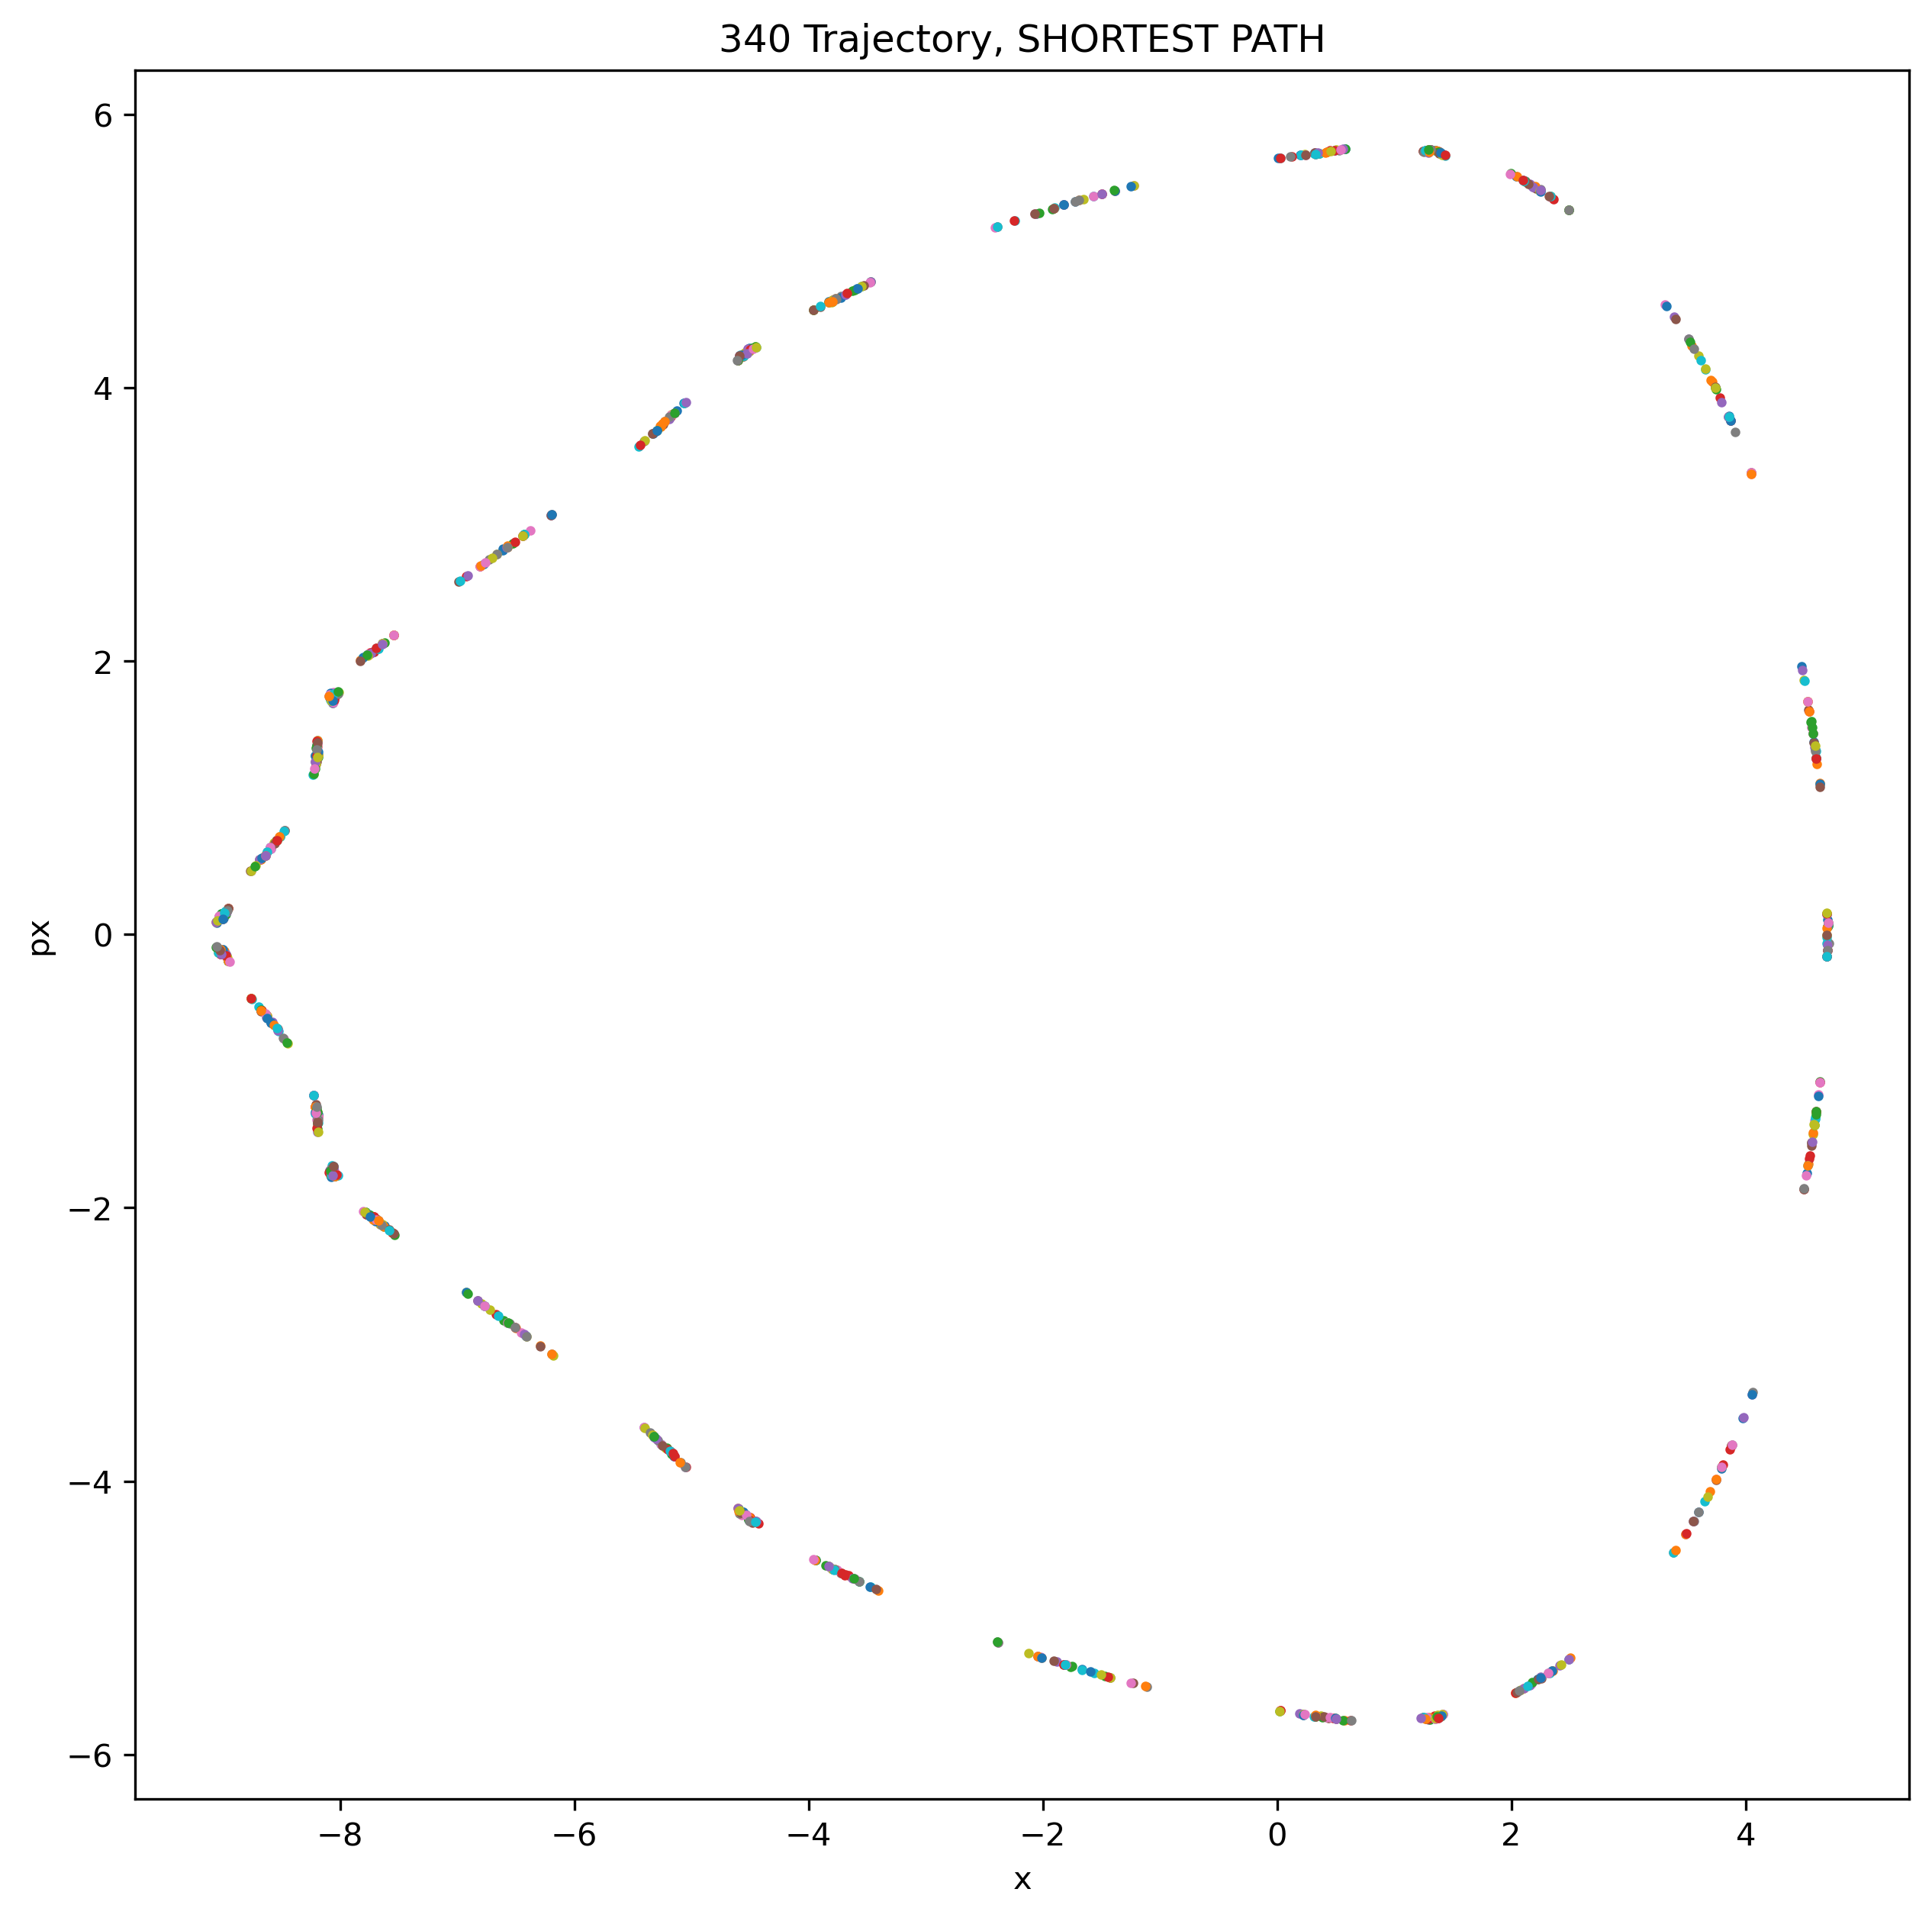

(1000, 2)
[3.96548709 4.28423863]


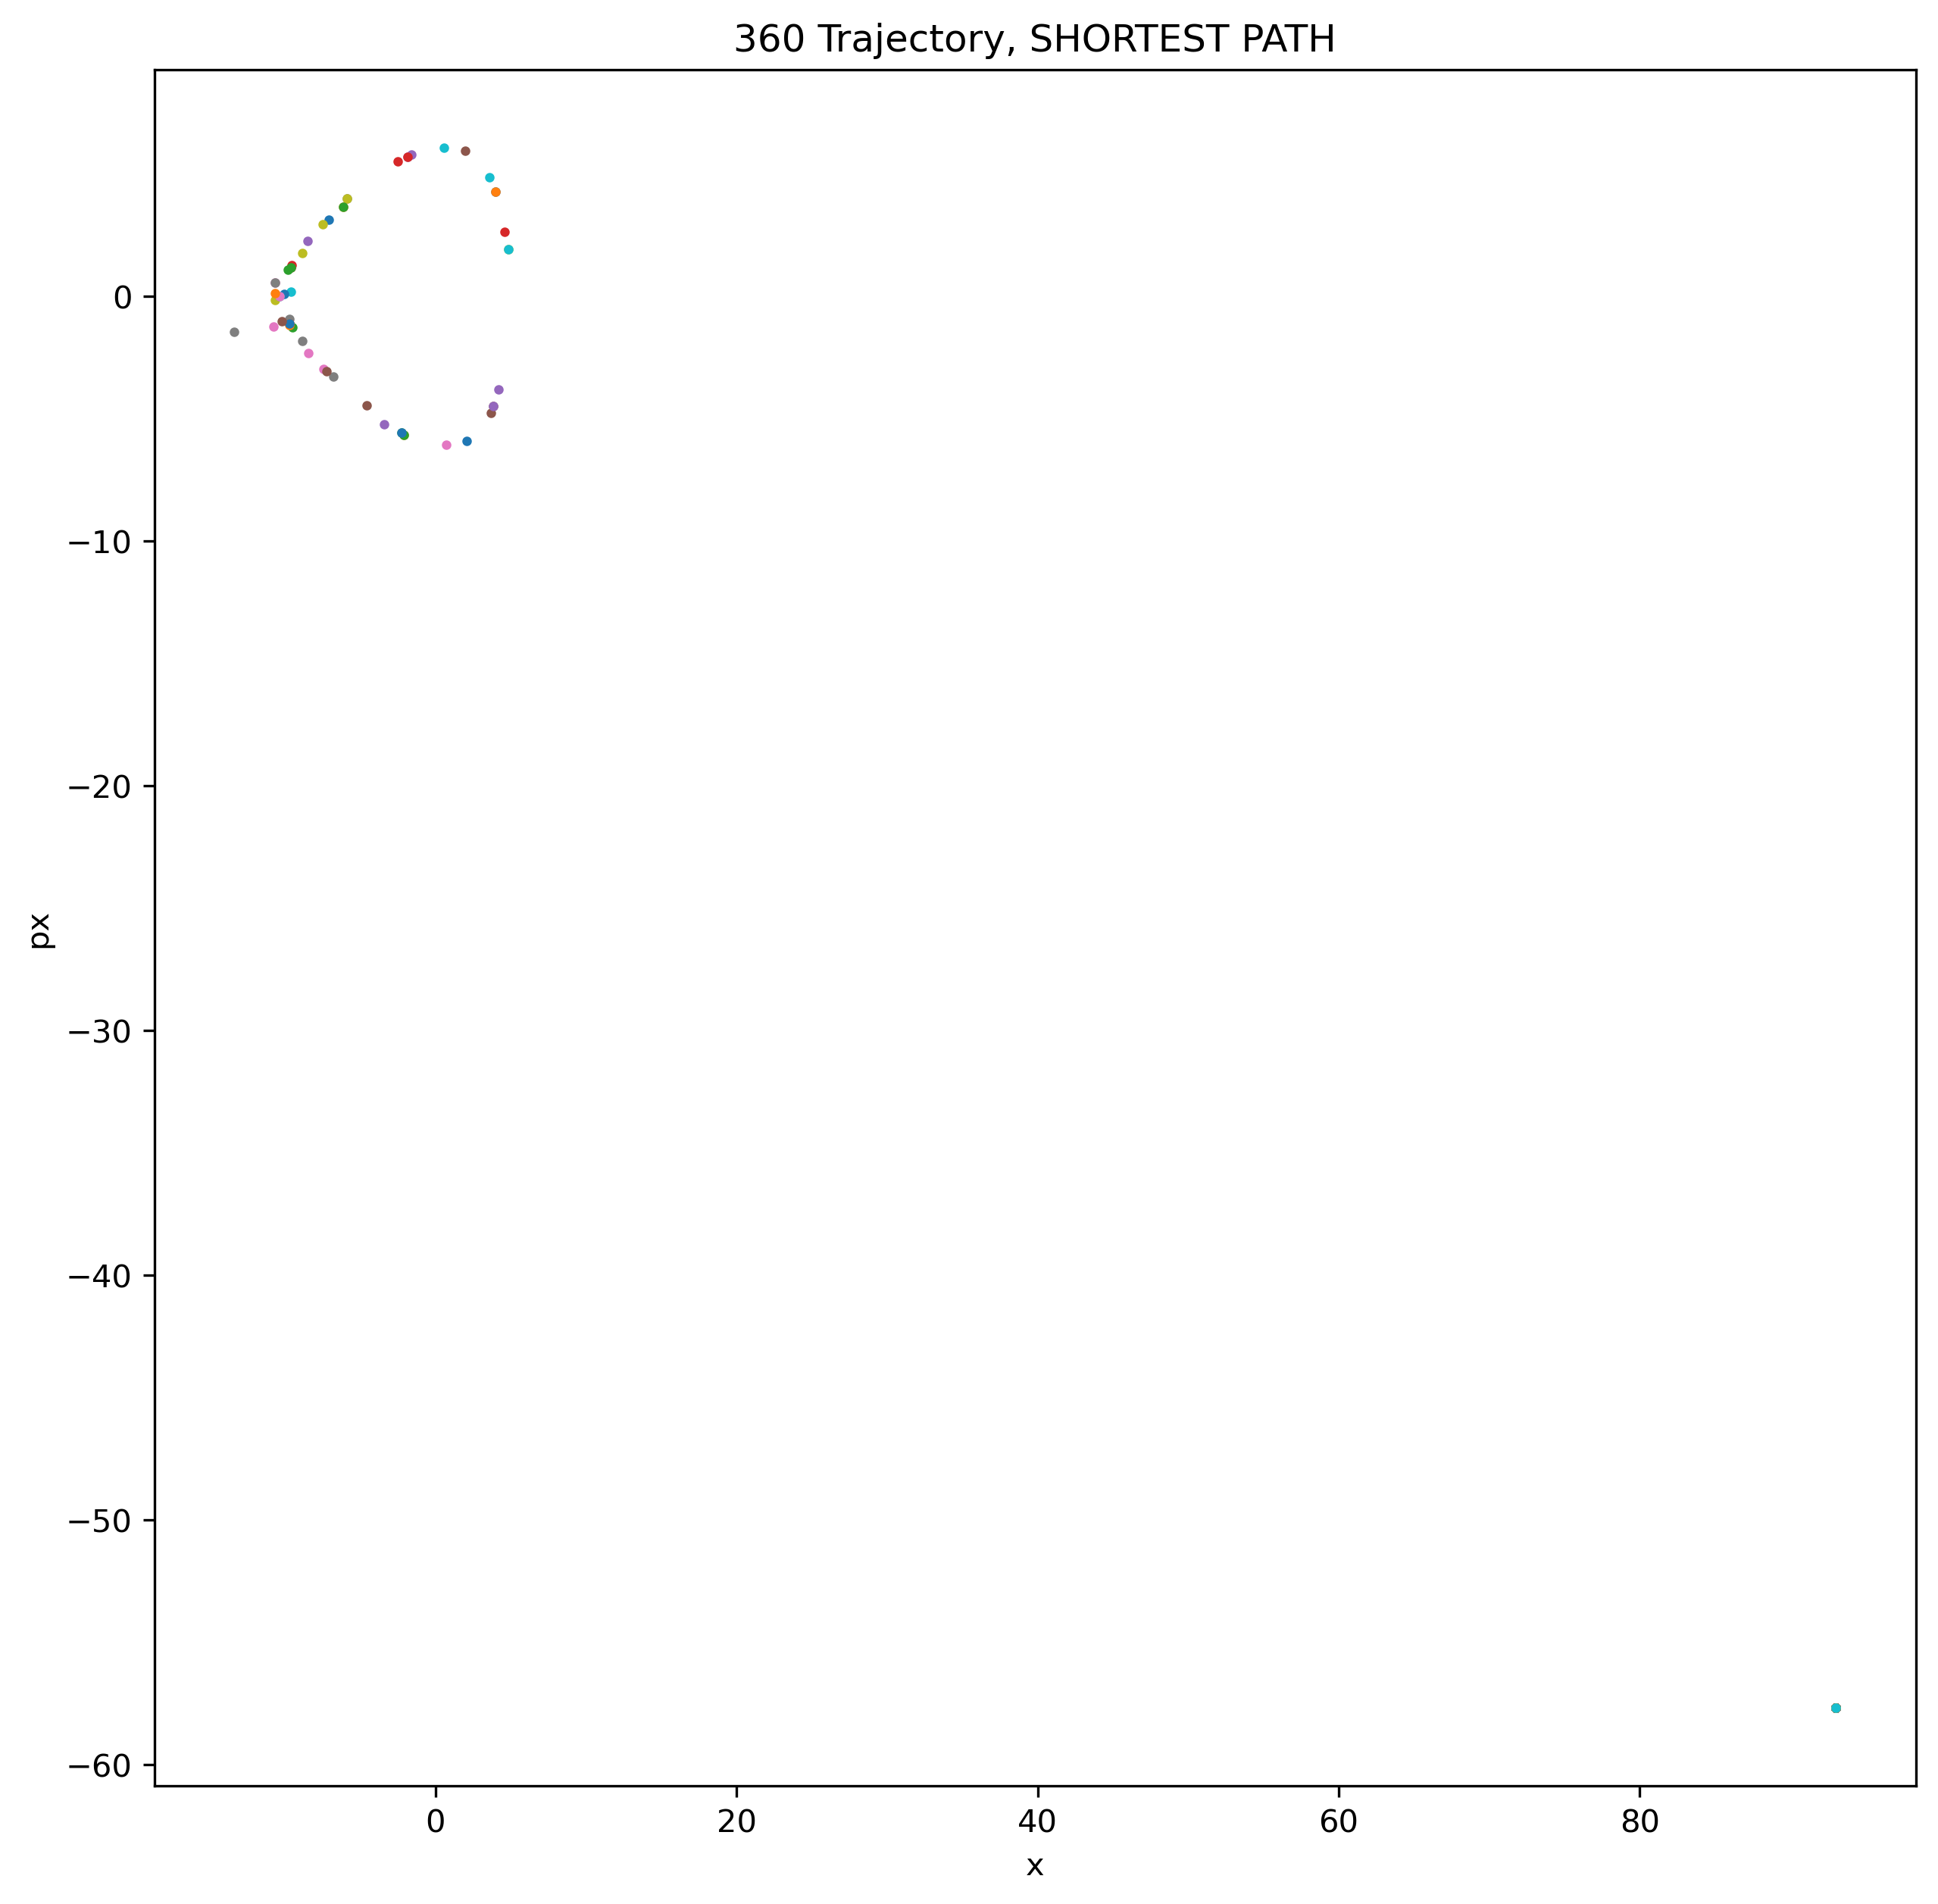

(1000, 2)
[-2.58985541 -5.86166778]


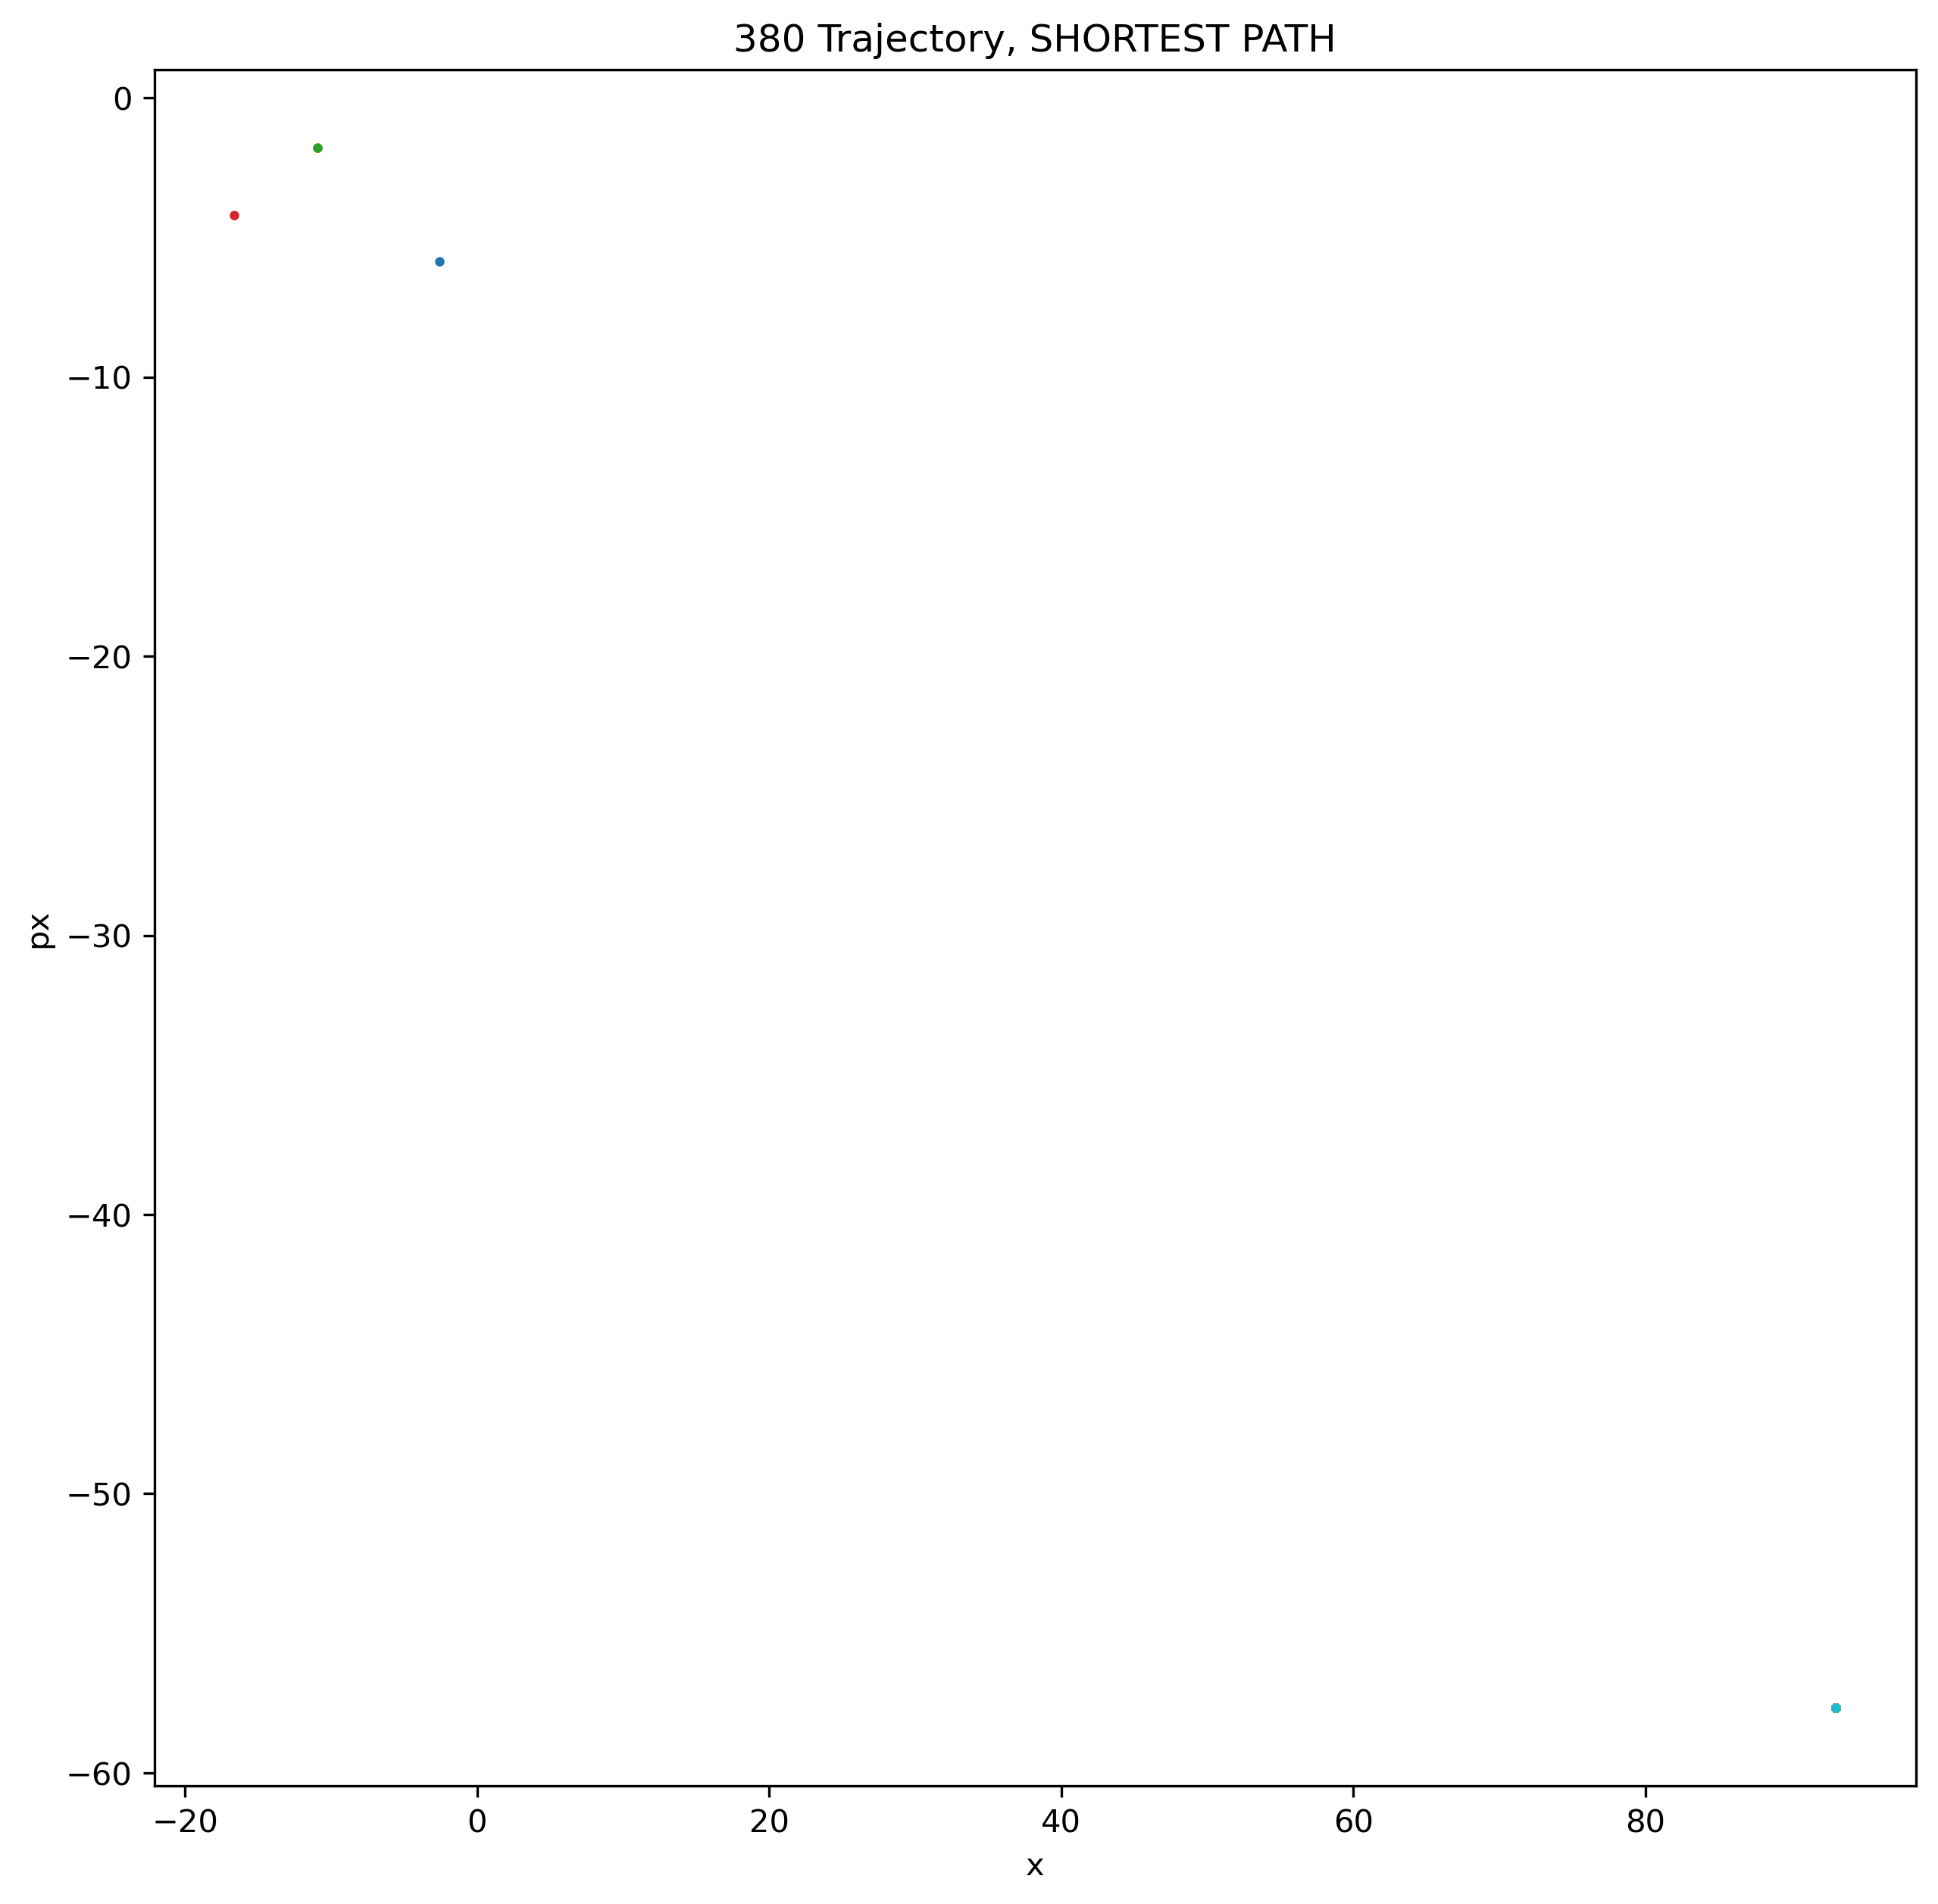

In [78]:
#graph the shortest path on phase space plot 

for i in range(len(data)):
    new_arr = []
    if (i % 20) == 0: #display every 20th traj 
        if i != 0:
            
            for j in range(1000):
                coord = data[i, main_dict[str(i)]["Index"][j]]
                #y_coord = data[i, main_dict[str(i)]["Index"][j], 1]
                #new_coord = np.concat(x_coord, y_coord)
                #print(type(str(coord)))
                #new_arr.append((x_coord, y_coord))
                new_arr.append(coord)
            
            print(np.shape(new_arr))
            print(new_arr[0])
            
            tpad = 7
            plt.figure(figsize=[10,10], dpi=300)
            plt.title('%s Trajectory, SHORTEST PATH' %i)
            plt.xlabel('x') 
            plt.ylabel('px')
            
            for k in range(1000):
                #print('IN')
                #print(new_arr[:][k][0])
                plt.plot(new_arr[:][k][0],new_arr[:][k][1], '-o', label='Traj %s' %i, markersize = 2)
                #plt.plot(data[i, main_dict[str(i)]["Index"][j], 0], data[i, main_dict[str(i)]["Index"][j], 1], '-bo', label='Traj %s' %i, markersize = 2)
                
            #plt.savefig(os.path.join("/global/u2/m/mmeitz/FRNN/Individual_ShortestPath{0}.png".format(str(i).zfill(3))))
            plt.show()
                #plt.close()

KeyError: '399'

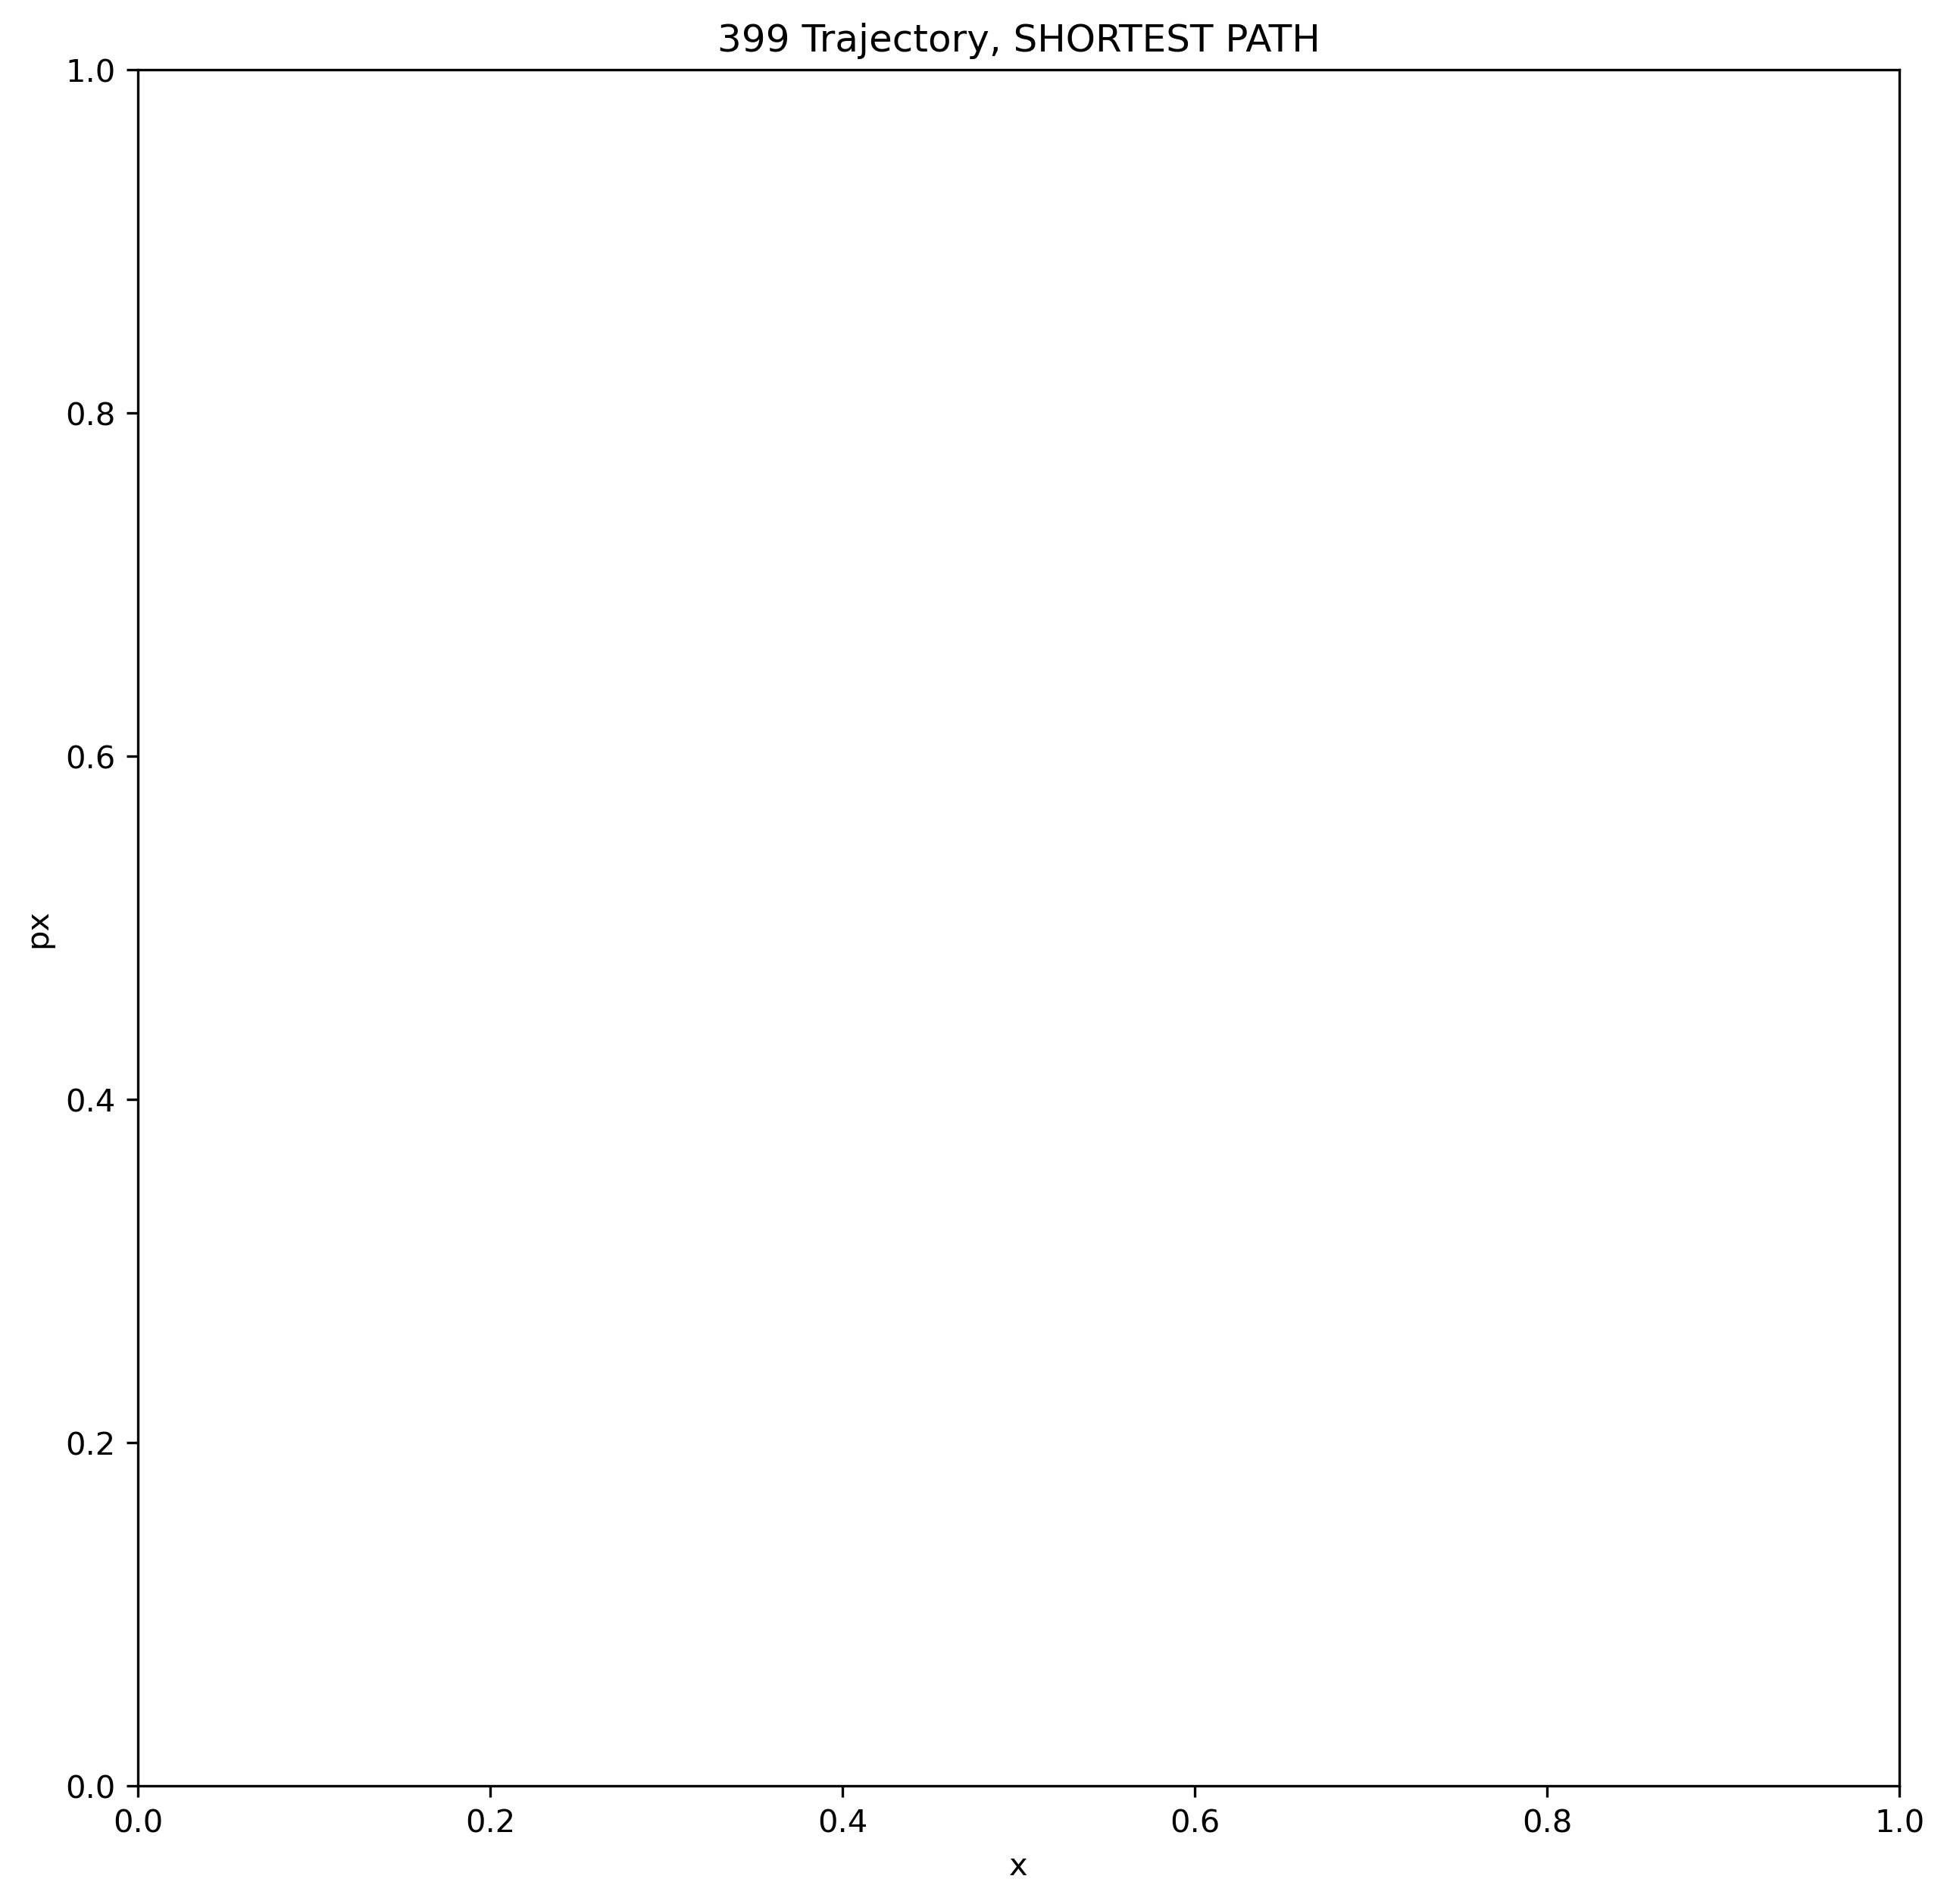

In [12]:
tpad = 7
plt.figure(figsize=[10,10], dpi=300)
plt.title('%s Trajectory, SHORTEST PATH' %i)
plt.xlabel('x') 
plt.ylabel('px')
plt.plot(main_dict[str(i)]["Index"], main_dict[str(i)]["Edge Weight"], '-o', label='Traj %s' %i, markersize = 2)
#plt.savefig(os.path.join("/global/u2/m/mmeitz/FRNN/Individual_ShortestPath{0}.png".format(str(i).zfill(3))))
#plt.show()
plt.close()